# CW + Diversity Regularization on CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

import pickle
import datetime
import glob
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('precision', 10)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# custom code imports
from neuron_coverage import *
from cw_div import *

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!')
    device = torch.device("cuda")
else:
    print('CUDA is not available...')

CUDA is available!


# Loading a Pretrained ResNet56
https://github.com/akamaster/pytorch_resnet_cifar10

In [2]:
from resnet import *

models_dir = 'pretrained_models/cifar10/' 
model = resnet56().cuda()
state_dict = torch.load(models_dir + 'resnet56.th', map_location='cuda')['state_dict'] # best_prec1, state_dict

new_state_dict = {}

for k, v in state_dict.items():
    if 'module' in k:
        k = k.replace('module.', '')
    new_state_dict[k]=v
    
model.load_state_dict(new_state_dict)

print('model loaded!')
# print(model)

model loaded!


# Load Data

In [3]:
data_dir = 'C:\data\CIFAR10'

classes = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

batch_size = 100 # determines how many of each class we want

def get_same_index(targets, label):
    '''
    Returns indices corresponding to the target label
    which the dataloader uses to serve downstream.
    '''
    label_indices = []
    for i in range(len(targets)):
        if targets[i] == label:
            label_indices.append(i)
    return label_indices

dataset = torchvision.datasets.CIFAR10(root=data_dir, 
                                       train=False, 
                                       download=True,
                                       transform=transforms.Compose([
                                           transforms.ToTensor()
                                       ]))

test_loader = DataLoader(dataset,
    batch_size=batch_size, 
    shuffle=False,
    pin_memory=True)

Files already downloaded and verified


## Generate per class batches for NC evaluation

In [4]:
# data = []
# labels = []

# for i in range(len(classes)):
    
#     target_indices = get_same_index(dataset.targets, i)
    
#     test_loader = torch.utils.data.DataLoader(dataset,
#         batch_size=batch_size, 
#         sampler=torch.utils.data.sampler.SubsetRandomSampler(target_indices),
#         shuffle=False,
#         num_workers=2, 
#         pin_memory=True)
    
#     inputs, targets = next(iter(test_loader))
    
#     data.append(inputs)
#     labels.append(targets)
    
# # torch.Size([10, batch_size, 3, 32, 32])
# inputs = torch.stack(data).to(device)

# # torch.Size([new_batch_size, 3, 32, 32])
# new_batch_size = len(classes) * batch_size
# all_inputs = inputs.view(new_batch_size,3,32,32)

# # torch.Size([10, batch_size])
# targets = torch.stack(labels).to(device)

# # torch.Size([new_batch_size])
# all_targets = targets.view(-1)

# # individual class performance
# for i in range(len(classes)):
#     # confirm that loading the weights actually worked
#     orig_output = model(inputs[i])
#     orig_pred = torch.argmax(orig_output, dim=1)
#     orig_correct = orig_pred.eq(targets[i].data).sum()
#     orig_acc = 100. * orig_correct / len(targets[i])
#     print(classes[i] + '\t accuracy: {}/{} ({:.0f}%)'.format(orig_correct, len(targets[i]), orig_acc))

# # all class performance
# orig_output = model(all_inputs)
# orig_pred = torch.argmax(orig_output, dim=1)
# orig_correct = orig_pred.eq(all_labels.data).sum()
# orig_acc = 100. * orig_correct / len(all_labels)
# print('total accuracy: {}/{} ({:.0f}%)'.format(orig_correct, len(all_labels), orig_acc))

In [5]:
# # confirm that all the images are still intact after reshaping the tensor view
# orig_inputs = all_inputs.clone().cpu().detach().numpy()
# for img in orig_inputs:
#     plt.imshow(np.transpose(np.squeeze(img), (1, 2, 0))) 
#     plt.show()

## Evaluate per class and overall accuracy

In [6]:
def get_acc(model, device, test_loader, sampler=False, class_idx=None, classes=None):
    # model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
#             # peek at images to make sure they're of the right class
#             x = 0            
#             if x % 100 == 0:
#                 np_data = data.clone().cpu().detach().numpy()
#                 plt.imshow(np.transpose(np.squeeze(np_data[0]), (1, 2, 0))) 
#                 plt.show()               
#             x += 1
            
    if sampler:
        if class_idx is None:
            raise Exception('you must provide an integer class index if sampler=True')
        if classes is None:
            raise Exception('you must provide an iterable of class indices if sampler=True')
        values, counts = np.unique(test_loader.dataset.targets, return_counts=True) 
        divisor = counts[class_idx]
        acc = 100. * correct / divisor
        print(classes[class_idx] + '\t accuracy: {}/{} ({:.2f}%)'.format(correct, divisor, acc))
    else:
        divisor = len(test_loader.dataset)
        acc = 100. * correct / divisor
        print('accuracy: {}/{} ({:.2f}%)'.format(correct, divisor, acc))

In [7]:
# evaluate on total test set
get_acc(model, device, test_loader)

accuracy: 9107/10000 (91.07%)


In [36]:
# evaluate on each class separately
for i in range(len(classes)):
    
    target_indices = get_same_index(dataset.targets, i)
    
    test_loader = DataLoader(dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(target_indices),
        shuffle=False,
        pin_memory=True)
    
    get_acc(model, device, test_loader, sampler=True, class_idx=i, classes=classes)

plane	 accuracy: 215/1000 (21.50%)
car	 accuracy: 304/1000 (30.40%)
bird	 accuracy: 243/1000 (24.30%)
cat	 accuracy: 244/1000 (24.40%)
deer	 accuracy: 238/1000 (23.80%)
dog	 accuracy: 259/1000 (25.90%)
frog	 accuracy: 188/1000 (18.80%)
horse	 accuracy: 281/1000 (28.10%)
ship	 accuracy: 210/1000 (21.00%)
truck	 accuracy: 262/1000 (26.20%)


# Evaluating Neuron Coverage Per Class

In [16]:
nc_thresholds = np.arange(0,1,0.1)

neuron_coverages_by_class = {}

for i in range(len(classes)):
    
    threshold_results = {}
    
    for t in nc_thresholds:
        
        t = round(t,2)

        covered_neurons, total_neurons, neuron_coverage = eval_nc(model, inputs[i], t)
        print(classes[i] + ' neuron_coverage_' + str(t), neuron_coverage)

        threshold_results[str(t)] = neuron_coverage
    
    neuron_coverages_by_class[classes[i]] = threshold_results

plane neuron_coverage_0.0 0.8185937764089466


plane neuron_coverage_0.1 0.3672275535690811


plane neuron_coverage_0.2 0.20617100790625176


plane neuron_coverage_0.3 0.11765103570020094


plane neuron_coverage_0.4 0.06495521042648689


plane neuron_coverage_0.5 0.03480816541155703


plane neuron_coverage_0.6 0.018911153261094105


plane neuron_coverage_0.7 0.009525061503502413


plane neuron_coverage_0.8 0.00339912486619467


plane neuron_coverage_0.9 0.0008751338053296776


car neuron_coverage_0.0 0.8338410110987999


car neuron_coverage_0.1 0.39302522113091326


car neuron_coverage_0.2 0.22464271629514168


car neuron_coverage_0.3 0.12897331405284607


car neuron_coverage_0.4 0.07169524310315686


car neuron_coverage_0.5 0.03917632256004808


car neuron_coverage_0.6 0.0200792503145599


car neuron_coverage_0.7 0.0088133110480948


car neuron_coverage_0.8 0.002937144359518489


car neuron_coverage_0.9 0.0006666791864635955


bird neuron_coverage_0.0 0.8354973802324926


bird neuron_coverage_0.1 0.3964224680275686


bird neuron_coverage_0.2 0.21960224605156906


bird neuron_coverage_0.3 0.12486807263986179


bird neuron_coverage_0.4 0.06970271742192341


bird neuron_coverage_0.5 0.039031718905519354


bird neuron_coverage_0.6 0.021420120565644424


bird neuron_coverage_0.7 0.009517549625345076


bird neuron_coverage_0.8 0.0030216529887885217


bird neuron_coverage_0.9 0.0007380420289582903


cat neuron_coverage_0.0 0.8376664350504235


cat neuron_coverage_0.1 0.40234558395462827


cat neuron_coverage_0.2 0.22606997314503557


cat neuron_coverage_0.3 0.12997990572592913


cat neuron_coverage_0.4 0.07498920167514883


cat neuron_coverage_0.5 0.042368870776916


cat neuron_coverage_0.6 0.02293939792296569


cat neuron_coverage_0.7 0.011406786981915154


cat neuron_coverage_0.8 0.003891152885500197


cat neuron_coverage_0.9 0.0008957914702623523


deer neuron_coverage_0.0 0.8410768277338542


deer neuron_coverage_0.1 0.42013746737027924


deer neuron_coverage_0.2 0.24404026366692333


deer neuron_coverage_0.3 0.14266558996413078


deer neuron_coverage_0.4 0.08242596105091175


deer neuron_coverage_0.5 0.04726285939642059


deer neuron_coverage_0.6 0.025470900861988017


deer neuron_coverage_0.7 0.01129410880955511


deer neuron_coverage_0.8 0.0036169693327574226


deer neuron_coverage_0.9 0.0007962590846776465


dog neuron_coverage_0.0 0.8376964825630528


dog neuron_coverage_0.1 0.3934947135157468


dog neuron_coverage_0.2 0.21995154838588518


dog neuron_coverage_0.3 0.12715356156923135


dog neuron_coverage_0.4 0.07310184228811809


dog neuron_coverage_0.5 0.03904298672275536


dog neuron_coverage_0.6 0.020606959755112772


dog neuron_coverage_0.7 0.009649007493098462


dog neuron_coverage_0.8 0.0031155514657552254


dog neuron_coverage_0.9 0.0007117504554076132


frog neuron_coverage_0.0 0.8356720313996507


frog neuron_coverage_0.1 0.40694285338691805


frog neuron_coverage_0.2 0.23220717759957935


frog neuron_coverage_0.3 0.13496779282240043


frog neuron_coverage_0.4 0.07763150481699187


frog neuron_coverage_0.5 0.042182951792521926


frog neuron_coverage_0.6 0.021545944524779807


frog neuron_coverage_0.7 0.009756051756840503


frog neuron_coverage_0.8 0.0032507652725872788


frog neuron_coverage_0.9 0.0007117504554076132


horse neuron_coverage_0.0 0.8336964074442712


horse neuron_coverage_0.1 0.4045578320719638


horse neuron_coverage_0.2 0.229664406843321


horse neuron_coverage_0.3 0.13203816034103927


horse neuron_coverage_0.4 0.07367837893669364


horse neuron_coverage_0.5 0.03994816804071438


horse neuron_coverage_0.6 0.020640763206820786


horse neuron_coverage_0.7 0.009427407087457042


horse neuron_coverage_0.8 0.003100527709440553


horse neuron_coverage_0.9 0.0007624556329696332


ship neuron_coverage_0.0 0.826280305733441


ship neuron_coverage_0.1 0.37701928674716895


ship neuron_coverage_0.2 0.2104828259685628


ship neuron_coverage_0.3 0.11996093823358185


ship neuron_coverage_0.4 0.06637871133730211


ship neuron_coverage_0.5 0.03523446449698586


ship neuron_coverage_0.6 0.01820315874476516


ship neuron_coverage_0.7 0.009232098255366299


ship neuron_coverage_0.8 0.0037371593832748033


ship neuron_coverage_0.9 0.0008488422317790005


truck neuron_coverage_0.0 0.830496347349246


truck neuron_coverage_0.1 0.3855490243948243


truck neuron_coverage_0.2 0.21524911265939267


truck neuron_coverage_0.3 0.12043043061841537


truck neuron_coverage_0.4 0.06625852128678472


truck neuron_coverage_0.5 0.03556686510544799


truck neuron_coverage_0.6 0.01858063062217131


truck neuron_coverage_0.7 0.008452740896542658


truck neuron_coverage_0.8 0.002916486694585814


truck neuron_coverage_0.9 0.0007474318766549607


In [17]:
save_file_path = "assets/neuron_coverages_cifar10_10.pkl"
pickle.dump(neuron_coverages_by_class, open(save_file_path, "wb")) 

In [21]:
df = pd.DataFrame.from_dict(neuron_coverages_by_class)
df.to_clipboard(excel=True)

## Create Extreme Case Inputs

In [41]:
input_shape = (batch_size, 3, 32, 32)
all_blacks = torch.zeros(input_shape).to(device)
all_whites = torch.ones(input_shape).to(device)

In [42]:
covered_neurons, total_neurons, neuron_coverage = eval_nc(model, all_blacks, 0.0)
print('all_blacks neuron_coverage', neuron_coverage)

covered_neurons, total_neurons, neuron_coverage = eval_nc(model, all_whites, 0.0)
print('all_whites neuron_coverage', neuron_coverage)


all_blacks neuron_coverage 0.42952919303648895



all_whites neuron_coverage 0.439799808447107


# Layer Specific Activations

In [5]:
inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

In [4]:
# load the results from file
with open('assets/results_cifar10_2019.08.15.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [109]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'layer', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

attack      layer  regularization_weight  orig_acc  pert_acc  \
0   cw_div4_attack    conv1-0                      0      0.93      0.29   
1   cw_div4_attack    conv1-0                      0      0.93      0.00   
2   cw_div4_attack    conv1-0                      0      0.93      0.00   
3   cw_div4_attack    conv1-0                      1      0.93      0.28   
4   cw_div4_attack    conv1-0                      1      0.93      0.01   
5   cw_div4_attack    conv1-0                      1      0.93      0.00   
6   cw_div4_attack    conv1-0                     10      0.93      0.29   
7   cw_div4_attack    conv1-0                     10      0.93      0.00   
8   cw_div4_attack    conv1-0                     10      0.93      0.01   
9   cw_div4_attack    conv1-0                    100      0.93      0.36   
10  cw_div4_attack    conv1-0                    100      0.93      0.01   
11  cw_div4_attack    conv1-0                    100      0.93      0.00   
12  cw_div4_attack    conv1-0                   1000      0.93      0.59   
13  cw_div4_attack    conv1-0                   1000      0.93      0.05   
14  cw_div4_attack    conv1-0                   1000      0.93      0.02   
15  cw_div4_attack    conv1-0                  10000      0.93      0.64   
16  cw_div4_attack    conv1-0                  10000      0.93      0.12   
17  cw_div4_attack    conv1-0                  10000      0.93      0.03   
18  cw_div4_attack   conv1-11                      0      0.93      0.27   
19  cw_div4_attack   conv1-11                      0      0.93      0.00   
20  cw_div4_attack   conv1-11                      0      0.93      0.00   
21  cw_div4_attack   conv1-11                      1      0.93      0.26   
22  cw_div4_attack   conv1-11                      1      0.93      0.03   
23  cw_div4_attack   conv1-11                      1      0.93      0.00   
24  cw_div4_attack   conv1-11                     10      0.93      0.32   
25  cw_div4_attack   conv1-11                     10      0.93      0.00   
26  cw_div4_attack   conv1-11                     10      0.93      0.00   
27  cw_div4_attack   conv1-11                    100      0.93      0.41   
28  cw_div4_attack   conv1-11                    100      0.93      0.01   
29  cw_div4_attack   conv1-11                    100      0.93      0.00   
30  cw_div4_attack   conv1-11                   1000      0.93      0.56   
31  cw_div4_attack   conv1-11                   1000      0.93      0.05   
32  cw_div4_attack   conv1-11                   1000      0.93      0.00   
33  cw_div4_attack   conv1-11                  10000      0.93      0.64   
34  cw_div4_attack   conv1-11                  10000      0.93      0.00   
35  cw_div4_attack   conv1-11                  10000      0.93      0.00   
36  cw_div4_attack   conv2-22                      0      0.93      0.29   
37  cw_div4_attack   conv2-22                      0      0.93      0.00   
38  cw_div4_attack   conv2-22                      0      0.93      0.00   
39  cw_div4_attack   conv2-22                      1      0.93      0.28   
40  cw_div4_attack   conv2-22                      1      0.93      0.01   
41  cw_div4_attack   conv2-22                      1      0.93      0.00   
42  cw_div4_attack   conv2-22                     10      0.93      0.34   
43  cw_div4_attack   conv2-22                     10      0.93      0.00   
44  cw_div4_attack   conv2-22                     10      0.93      0.01   
45  cw_div4_attack   conv2-22                    100      0.93      0.51   
46  cw_div4_attack   conv2-22                    100      0.93      0.05   
47  cw_div4_attack   conv2-22                    100      0.93      0.01   
48  cw_div4_attack   conv2-22                   1000      0.93      0.65   
49  cw_div4_attack   conv2-22                   1000      0.93      0.18   
50  cw_div4_attack   conv2-22                   1000      0.93      0.00   
51  cw_div4_attack   conv2-22                  10000      0.

In [26]:
nc_post_reg = {}

thresholds = [0., 0.2]

for t in thresholds:

    inputs_model_layer_dict = get_init_dict(model, inputs, False)
    update_coverage(model, inputs, inputs_model_layer_dict, threshold=t)

    for result in results:

        # reference data
        attack = result['attack']
        layer = result['layer']
        rw = result['regularization_weight']
        conf = result['confidence']
        pert_acc = result['pert_acc']
        adversaries = result['adversaries']

        print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc)

        o_covered_neurons, o_total_neurons, o_neuron_coverage = neurons_covered(inputs_model_layer_dict, layer)
        a_covered_neurons, a_total_neurons, a_neuron_coverage = eval_nc(model, adversaries, t, layer)
        
        pct_diff = (a_covered_neurons - o_covered_neurons) / o_covered_neurons

        print(o_covered_neurons, o_total_neurons, o_neuron_coverage)
        print(a_covered_neurons, a_total_neurons, a_neuron_coverage)
        
        nc_post_reg[(t, layer, rw, conf)] = {
            'o_covered_neurons':o_covered_neurons,
            'o_total_neurons':o_total_neurons,
            'o_neuron_coverage':o_neuron_coverage,
            'a_covered_neurons':a_covered_neurons,
            'a_total_neurons':a_total_neurons,
            'a_neuron_coverage':a_neuron_coverage,
            'pct_diff':pct_diff
        }

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29


14466 16384 0.8829345703125
14488 16384 0.88427734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


14466 16384 0.8829345703125
14441 16384 0.88140869140625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


14466 16384 0.8829345703125
14453 16384 0.88214111328125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28


14466 16384 0.8829345703125
14441 16384 0.88140869140625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01


14466 16384 0.8829345703125
14435 16384 0.88104248046875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


14466 16384 0.8829345703125
14443 16384 0.88153076171875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.29


14466 16384 0.8829345703125
14502 16384 0.8851318359375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


14466 16384 0.8829345703125
14510 16384 0.8856201171875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.01


14466 16384 0.8829345703125
14488 16384 0.88427734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.36


14466 16384 0.8829345703125
14537 16384 0.88726806640625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.01


14466 16384 0.8829345703125
14585 16384 0.89019775390625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0


14466 16384 0.8829345703125
14581 16384 0.88995361328125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.59


14466 16384 0.8829345703125
14686 16384 0.8963623046875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.05


14466 16384 0.8829345703125
14715 16384 0.89813232421875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.02


14466 16384 0.8829345703125
14673 16384 0.89556884765625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.64


14466 16384 0.8829345703125
14947 16384 0.91229248046875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.12


14466 16384 0.8829345703125
14935 16384 0.91156005859375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.03


14466 16384 0.8829345703125
14995 16384 0.91522216796875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.27


15372 16384 0.938232421875
15373 16384 0.93829345703125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


15372 16384 0.938232421875
15375 16384 0.93841552734375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15376 16384 0.9384765625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.26


15372 16384 0.938232421875
15372 16384 0.938232421875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.03


15372 16384 0.938232421875
15373 16384 0.93829345703125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15375 16384 0.93841552734375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.32


15372 16384 0.938232421875
15373 16384 0.93829345703125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


15372 16384 0.938232421875
15377 16384 0.93853759765625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15377 16384 0.93853759765625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.41


15372 16384 0.938232421875
15382 16384 0.9388427734375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.01


15372 16384 0.938232421875
15385 16384 0.93902587890625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15386 16384 0.9390869140625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.56


15372 16384 0.938232421875
15402 16384 0.9400634765625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.05


15372 16384 0.938232421875
15404 16384 0.940185546875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15404 16384 0.940185546875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.64


15372 16384 0.938232421875
15421 16384 0.94122314453125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.0


15372 16384 0.938232421875
15413 16384 0.94073486328125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15422 16384 0.9412841796875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29


7943 8192 0.9696044921875
7935 8192 0.9686279296875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


7943 8192 0.9696044921875
7935 8192 0.9686279296875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


7943 8192 0.9696044921875
7931 8192 0.9681396484375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28


7943 8192 0.9696044921875
7937 8192 0.9688720703125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01


7943 8192 0.9696044921875
7933 8192 0.9683837890625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


7943 8192 0.9696044921875
7931 8192 0.9681396484375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.34


7943 8192 0.9696044921875
7953 8192 0.9708251953125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


7943 8192 0.9696044921875
7948 8192 0.97021484375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.01


7943 8192 0.9696044921875
7952 8192 0.970703125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.51


7943 8192 0.9696044921875
7988 8192 0.97509765625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.05


7943 8192 0.9696044921875
7988 8192 0.97509765625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.01


7943 8192 0.9696044921875
8001 8192 0.9766845703125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.65


7943 8192 0.9696044921875
8033 8192 0.9805908203125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.18


7943 8192 0.9696044921875
8034 8192 0.980712890625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


7943 8192 0.9696044921875
8048 8192 0.982421875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.63


7943 8192 0.9696044921875
8044 8192 0.98193359375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.07


7943 8192 0.9696044921875
8050 8192 0.982666015625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0


7943 8192 0.9696044921875
8055 8192 0.9832763671875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.31


8121 8192 0.9913330078125
8120 8192 0.9912109375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


8121 8192 0.9913330078125
8117 8192 0.9908447265625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


8121 8192 0.9913330078125
8109 8192 0.9898681640625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.27


8121 8192 0.9913330078125
8119 8192 0.9910888671875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.0


8121 8192 0.9913330078125
8118 8192 0.990966796875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


8121 8192 0.9913330078125
8119 8192 0.9910888671875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.32


8121 8192 0.9913330078125
8133 8192 0.9927978515625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.01


8121 8192 0.9913330078125
8131 8192 0.9925537109375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0


8121 8192 0.9913330078125
8132 8192 0.99267578125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.53


8121 8192 0.9913330078125
8136 8192 0.9931640625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.1


8121 8192 0.9913330078125
8143 8192 0.9940185546875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.05


8121 8192 0.9913330078125
8140 8192 0.99365234375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.77


8121 8192 0.9913330078125
8162 8192 0.996337890625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.09


8121 8192 0.9913330078125
8163 8192 0.9964599609375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


8121 8192 0.9913330078125
8170 8192 0.997314453125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.74


8121 8192 0.9913330078125
8161 8192 0.9962158203125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.04


8121 8192 0.9913330078125
8169 8192 0.9971923828125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.01


8121 8192 0.9913330078125
8172 8192 0.99755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.27


4093 4096 0.999267578125
4091 4096 0.998779296875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


4093 4096 0.999267578125
4092 4096 0.9990234375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


4093 4096 0.999267578125
4094 4096 0.99951171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.25


4093 4096 0.999267578125
4093 4096 0.999267578125
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.02


4093 4096 0.999267578125
4092 4096 0.9990234375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


4093 4096 0.999267578125
4093 4096 0.999267578125
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.39


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.02


4093 4096 0.999267578125
4094 4096 0.99951171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.06


4093 4096 0.999267578125
4094 4096 0.99951171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.6


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.23


4093 4096 0.999267578125
4094 4096 0.99951171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.04


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.72


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.1


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.76


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.17


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.02


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.31


9 10 0.9
9 10 0.9
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


9 10 0.9
9 10 0.9
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


9 10 0.9
9 10 0.9


attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29


1358 16384 0.0828857421875
1359 16384 0.08294677734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


1358 16384 0.0828857421875
1356 16384 0.082763671875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


1358 16384 0.0828857421875
1357 16384 0.08282470703125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28


1358 16384 0.0828857421875
1358 16384 0.0828857421875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01


1358 16384 0.0828857421875
1359 16384 0.08294677734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


1358 16384 0.0828857421875
1359 16384 0.08294677734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.29


1358 16384 0.0828857421875
1358 16384 0.0828857421875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


1358 16384 0.0828857421875
1362 16384 0.0831298828125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.01


1358 16384 0.0828857421875
1361 16384 0.08306884765625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.36


1358 16384 0.0828857421875
1360 16384 0.0830078125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.01


1358 16384 0.0828857421875
1360 16384 0.0830078125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0


1358 16384 0.0828857421875
1364 16384 0.083251953125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.59


1358 16384 0.0828857421875
1362 16384 0.0831298828125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.05


1358 16384 0.0828857421875
1363 16384 0.08319091796875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.02


1358 16384 0.0828857421875
1369 16384 0.08355712890625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.64


1358 16384 0.0828857421875
1442 16384 0.0880126953125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.12


1358 16384 0.0828857421875
1525 16384 0.09307861328125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.03


1358 16384 0.0828857421875
1742 16384 0.1063232421875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.27


4452 16384 0.271728515625
4452 16384 0.271728515625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


4452 16384 0.271728515625
4458 16384 0.2720947265625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4456 16384 0.27197265625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.26


4452 16384 0.271728515625
4454 16384 0.2718505859375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.03


4452 16384 0.271728515625
4459 16384 0.27215576171875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4466 16384 0.2725830078125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.32


4452 16384 0.271728515625
4467 16384 0.27264404296875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


4452 16384 0.271728515625
4472 16384 0.27294921875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4475 16384 0.27313232421875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.41


4452 16384 0.271728515625
4513 16384 0.27545166015625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.01


4452 16384 0.271728515625
4520 16384 0.27587890625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4538 16384 0.2769775390625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.56


4452 16384 0.271728515625
4775 16384 0.29144287109375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.05


4452 16384 0.271728515625
4845 16384 0.29571533203125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4925 16384 0.30059814453125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.64


4452 16384 0.271728515625
5097 16384 0.31109619140625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.0


4452 16384 0.271728515625
5234 16384 0.3194580078125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
5292 16384 0.322998046875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29


2173 8192 0.2652587890625
2112 8192 0.2578125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


2173 8192 0.2652587890625
2160 8192 0.263671875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


2173 8192 0.2652587890625
2175 8192 0.2655029296875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28


2173 8192 0.2652587890625
2152 8192 0.2626953125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01


2173 8192 0.2652587890625
2194 8192 0.267822265625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


2173 8192 0.2652587890625
2235 8192 0.2728271484375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.34


2173 8192 0.2652587890625
2315 8192 0.2825927734375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


2173 8192 0.2652587890625
2396 8192 0.29248046875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.01


2173 8192 0.2652587890625
2434 8192 0.297119140625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.51


2173 8192 0.2652587890625
3076 8192 0.37548828125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.05


2173 8192 0.2652587890625
3252 8192 0.39697265625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.01


2173 8192 0.2652587890625
3533 8192 0.4312744140625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.65


2173 8192 0.2652587890625
4107 8192 0.5013427734375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.18


2173 8192 0.2652587890625
4400 8192 0.537109375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


2173 8192 0.2652587890625
4597 8192 0.5611572265625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.63


2173 8192 0.2652587890625
4304 8192 0.525390625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.07


2173 8192 0.2652587890625
4777 8192 0.5831298828125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0


2173 8192 0.2652587890625
4842 8192 0.591064453125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.31


1114 8192 0.135986328125
1107 8192 0.1351318359375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


1114 8192 0.135986328125
1141 8192 0.1392822265625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


1114 8192 0.135986328125
1173 8192 0.1431884765625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.27


1114 8192 0.135986328125
1167 8192 0.1424560546875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.0


1114 8192 0.135986328125
1201 8192 0.1466064453125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


1114 8192 0.135986328125
1212 8192 0.14794921875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.32


1114 8192 0.135986328125
1228 8192 0.14990234375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.01


1114 8192 0.135986328125
1255 8192 0.1531982421875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0


1114 8192 0.135986328125
1277 8192 0.1558837890625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.53


1114 8192 0.135986328125
1570 8192 0.191650390625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.1


1114 8192 0.135986328125
1750 8192 0.213623046875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.05


1114 8192 0.135986328125
1907 8192 0.2327880859375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.77


1114 8192 0.135986328125
2196 8192 0.26806640625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.09


1114 8192 0.135986328125
2414 8192 0.294677734375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


1114 8192 0.135986328125
2566 8192 0.313232421875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.74


1114 8192 0.135986328125
2439 8192 0.2977294921875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.04


1114 8192 0.135986328125
2680 8192 0.3271484375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.01


1114 8192 0.135986328125
2806 8192 0.342529296875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.27


1221 4096 0.298095703125
1333 4096 0.325439453125
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


1221 4096 0.298095703125
1330 4096 0.32470703125
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


1221 4096 0.298095703125
1343 4096 0.327880859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.25


1221 4096 0.298095703125
1337 4096 0.326416015625
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.02


1221 4096 0.298095703125
1379 4096 0.336669921875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


1221 4096 0.298095703125
1403 4096 0.342529296875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.39


1221 4096 0.298095703125
1486 4096 0.36279296875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.02


1221 4096 0.298095703125
1534 4096 0.37451171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.06


1221 4096 0.298095703125
1572 4096 0.3837890625
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.6


1221 4096 0.298095703125
1658 4096 0.40478515625
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.23


1221 4096 0.298095703125
1679 4096 0.409912109375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.04


1221 4096 0.298095703125
1676 4096 0.4091796875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.72


1221 4096 0.298095703125
1774 4096 0.43310546875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.1


1221 4096 0.298095703125
1894 4096 0.46240234375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


1221 4096 0.298095703125
1958 4096 0.47802734375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.76


1221 4096 0.298095703125
1769 4096 0.431884765625
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.17


1221 4096 0.298095703125
1903 4096 0.464599609375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.02


1221 4096 0.298095703125
1935 4096 0.472412109375
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.31


8 10 0.8
7 10 0.7
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


8 10 0.8
6 10 0.6
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


8 10 0.8
6 10 0.6


In [30]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

)


In [31]:
layer_dict

{'conv1-0': Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-1': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-2': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-3': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-4': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-5': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-6': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-7': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-8': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-9': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-10': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),

In [27]:
df = pd.DataFrame.from_dict(nc_post_reg)
df.T

o_covered_neurons  o_total_neurons  o_neuron_coverage  \
0.0 conv1-0   0     0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              1     0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              10    0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              100   0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              1000  0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              10000 0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
    conv1-11  0     0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              1     0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              10    0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              100   0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              1000  0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              10000 0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
    conv2-22  0     0              7943.0           8192.0       0.9696044922   
                    5              7943.0           8192.0       0.9696044922   
                    10             7943.0           8192.0       0.9696044922   
              1     0              7943.0           8192.0       0.9696044922   
                    5              7943.0           8192.0       0.9696044922   
                    10             7943.0           8192.0       0.9696044922   
              10    0              7943.0           8192.0       0.9696044922   
                    5              7943.0           8192.0       0.9696044922   
                    10             7943.0           8192.0       0.9696044922   
              100   0              7943.0           8192.0       0.9696044922   
                    5              7943.0           8192.0       0.9696044922   
                    10             7943.0           8192.0       0.9696044922   
              1000  0              7943.0           819

In [28]:
df.T['pct_diff'].mean()

0.13402441870837203

In [29]:
save_file_path = "assets/nc_post_reg_cifar10.pkl"
pickle.dump(nc_post_reg, open(save_file_path, "wb")) 

# Diversity Regularization applied to ALL layers

In [86]:
# load the results from file
with open('assets/results_cifar10_2019.08.28.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [87]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'confidence', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

attack  confidence  regularization_weight  orig_acc  pert_acc  \
0   cw_div4_attack           0                      0      0.93      0.64   
1   cw_div4_attack          10                      0      0.93      0.00   
2   cw_div4_attack          20                      0      0.93      0.00   
3   cw_div4_attack           0                      1      0.93      0.62   
4   cw_div4_attack          10                      1      0.93      0.00   
5   cw_div4_attack          20                      1      0.93      0.00   
6   cw_div4_attack           0                     10      0.93      0.68   
7   cw_div4_attack          10                     10      0.93      0.00   
8   cw_div4_attack          20                     10      0.93      0.00   
9   cw_div4_attack           0                    100      0.93      0.43   
10  cw_div4_attack          10                    100      0.93      0.00   
11  cw_div4_attack          20                    100      0.93      0.00   
12  cw_div4_attack           0                   1000      0.93      0.51   
13  cw_div4_attack          10                   1000      0.93      0.00   
14  cw_div4_attack          20                   1000      0.93      0.00   
15  cw_div4_attack           0                  10000      0.93      0.67   
16  cw_div4_attack          10                  10000      0.93      0.00   
17  cw_div4_attack          20                  10000      0.93      0.00   

    neuron_coverage_000  neuron_coverage_020  neuron_coverage_050  \
0          0.9521887735         0.2754530602         0.0561080959   
1          0.9520610716         0.2759432102         0.0561325095   
2          0.9514601213         0.2773009822         0.0563578659   
3          0.9522094312         0.2755939079         0.0559428346   
4          0.9520122444         0.2760521324         0.0558132547   
5          0.9514601213         0.2771507446         0.0563503540   
6          0.9520629495         0.2761817123         0.0559334448   
7          0.9516817217         0.2769178764         0.0557062104   
8          0.9514037822         0.2774737554         0.0558977633   
9          0.9516685759         0.2795113523         0.0562921369   
10         0.9512385209         0.2811113824         0.0566264155   
11         0.9506131571         0.2816728953         0.0565757103   
12         0.9501492986         0.2844410224         0.0586978159   
13         0.9495821518         0.2858419876         0.0591616744   
14         0.9491389510         0.2867584368         0.0592499390   
15         0.9501079832         0.2884016601         0.0613720445   
16         0.9481173355         0.2901312701         0.0637514320   
17         0.9480046574         0.2904261113         0.0621720596   

    neuron_coverage_075  
0          0.0132866345  
1          0.0131833462  
2          0.0132622209  
3          0.0132321734  
4          0.0131758343  
5          0.0131739563  
6          0.0130744239  
7          0.0131063494  
8          0.0129955492  
9          0.0130030611  
10         0.0132791226  
11         0.0131345190  
12         0.0131194952  
13         0.0129204304  
14         0.0128885049  
15         0.0131720783  
16         0.0137974422  
17         0.0136246690

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 0 - confidence: 0 - pert_acc: 0.64 inception_score 3.158318679887109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


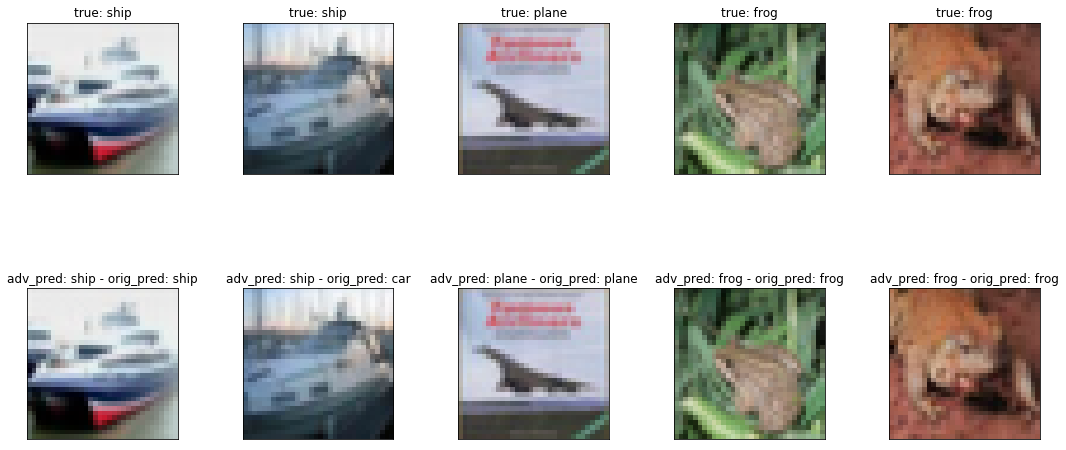

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0 inception_score 3.1480618132140377


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


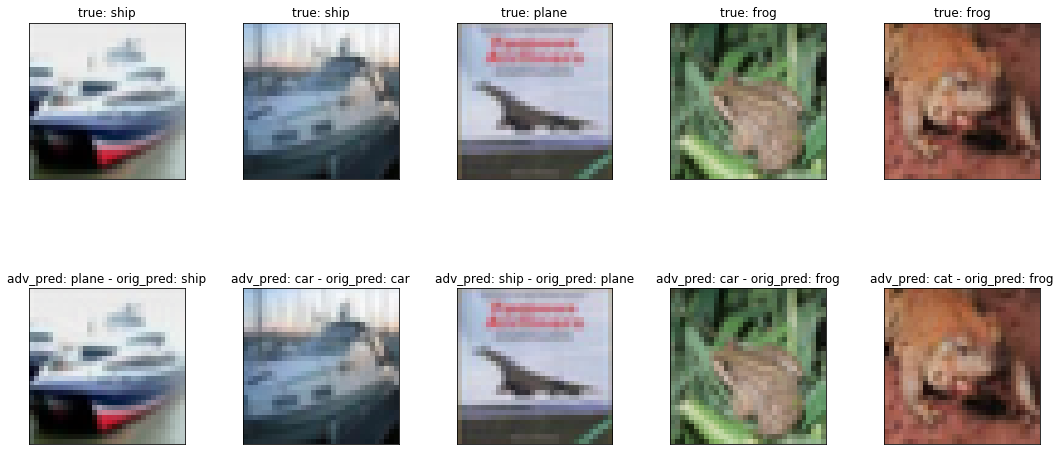

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 0 - confidence: 20 - pert_acc: 0.0 inception_score 3.1495628216614935


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


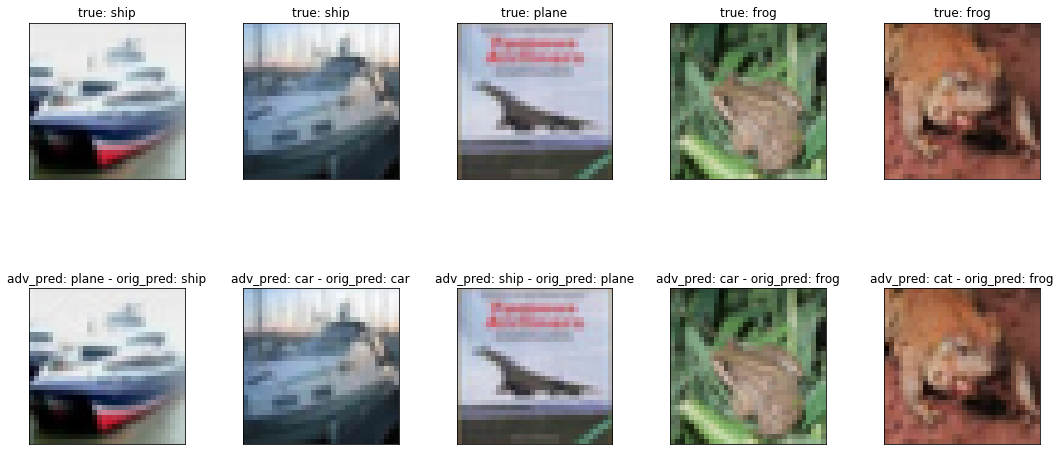

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1 - confidence: 0 - pert_acc: 0.62 inception_score 3.1568809506698456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


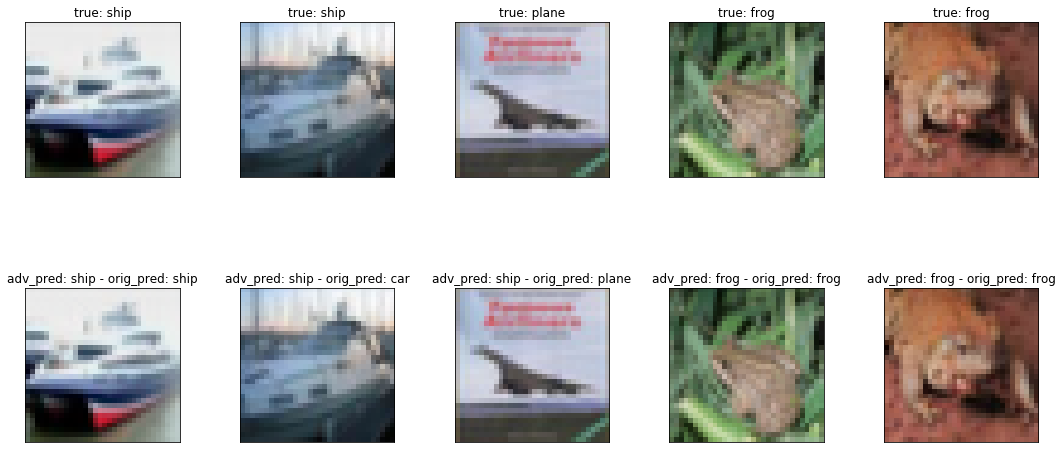

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0 inception_score 3.1517342996360442


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


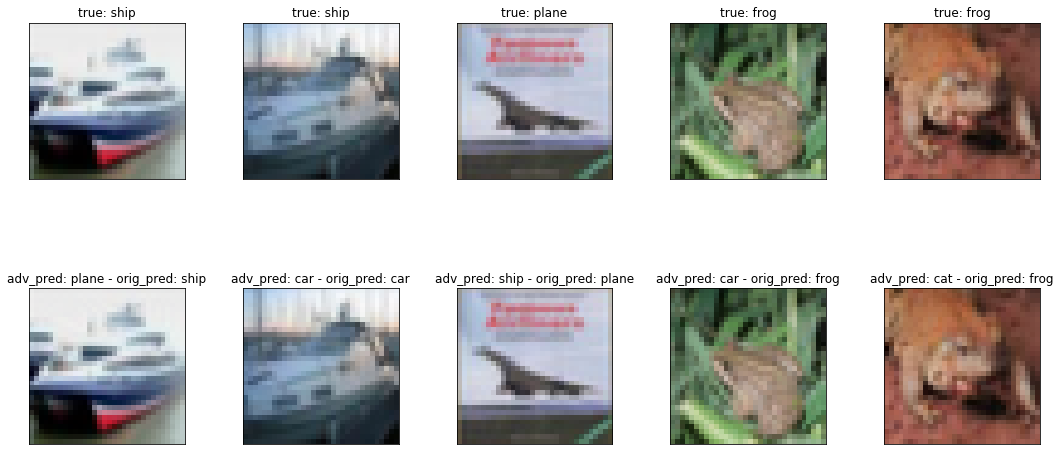

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1 - confidence: 20 - pert_acc: 0.0 inception_score 3.158640993603509


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


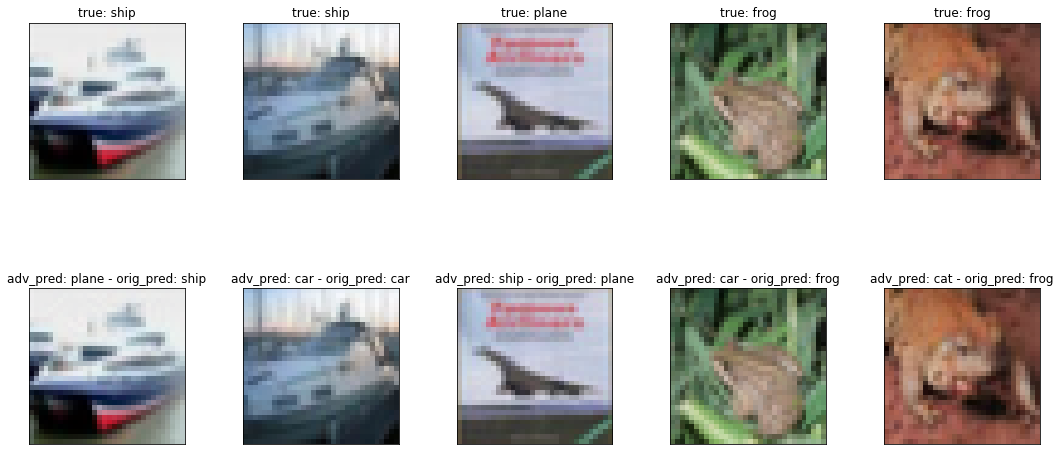

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10 - confidence: 0 - pert_acc: 0.68 inception_score 3.1638990472790227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


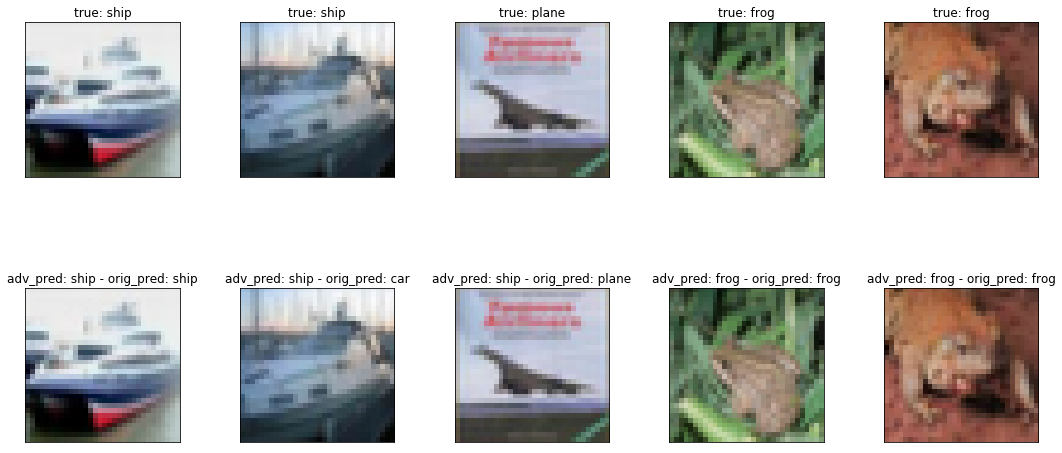

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0 inception_score 3.151744257501709


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


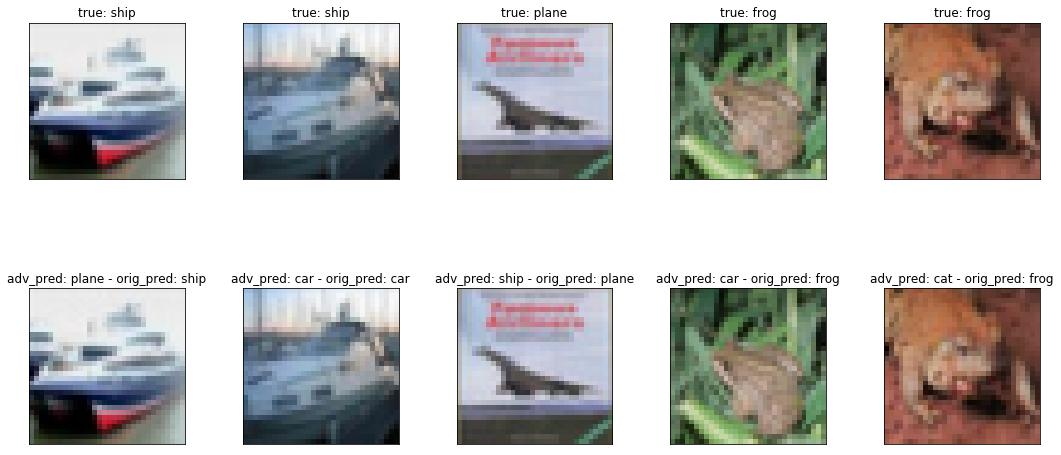

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10 - confidence: 20 - pert_acc: 0.0 inception_score 3.1601570354233375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


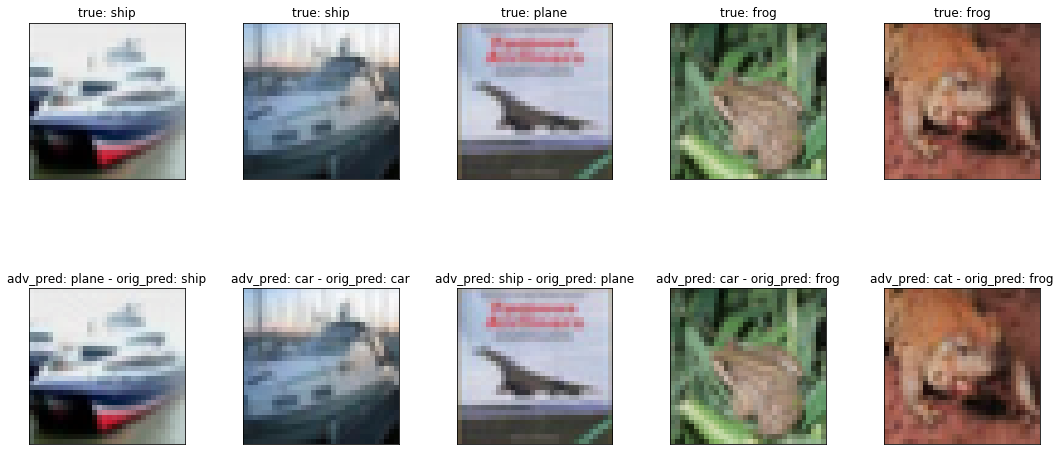

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 100 - confidence: 0 - pert_acc: 0.43 inception_score 3.1569117777961737


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


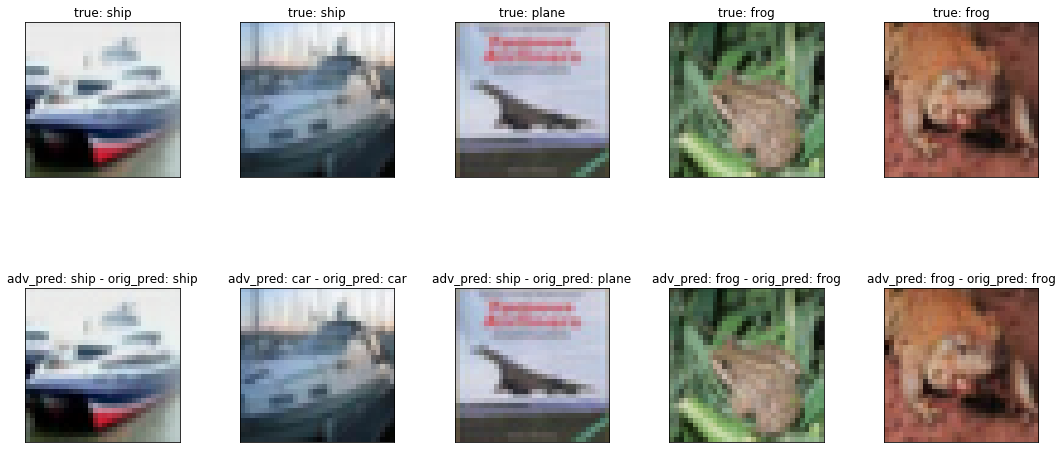

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0 inception_score 3.1521047617788036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


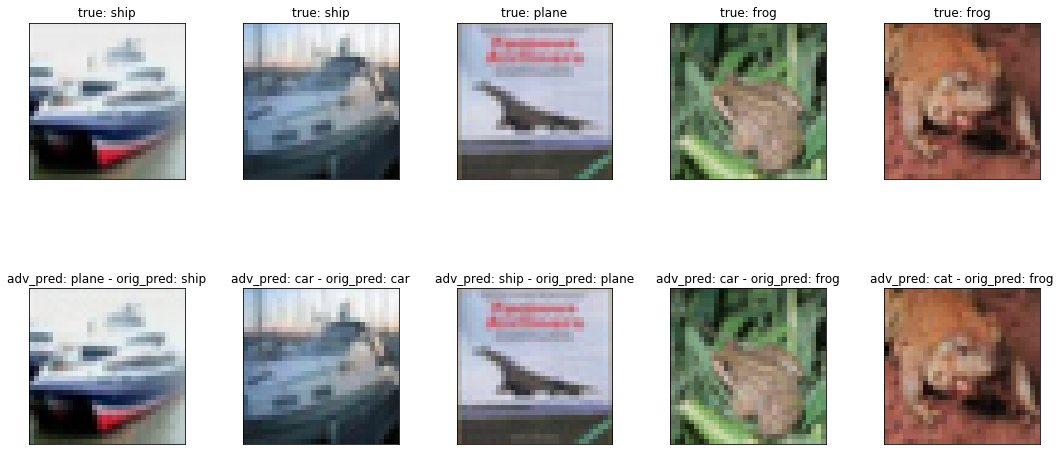

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 100 - confidence: 20 - pert_acc: 0.0 inception_score 3.1136585607744074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


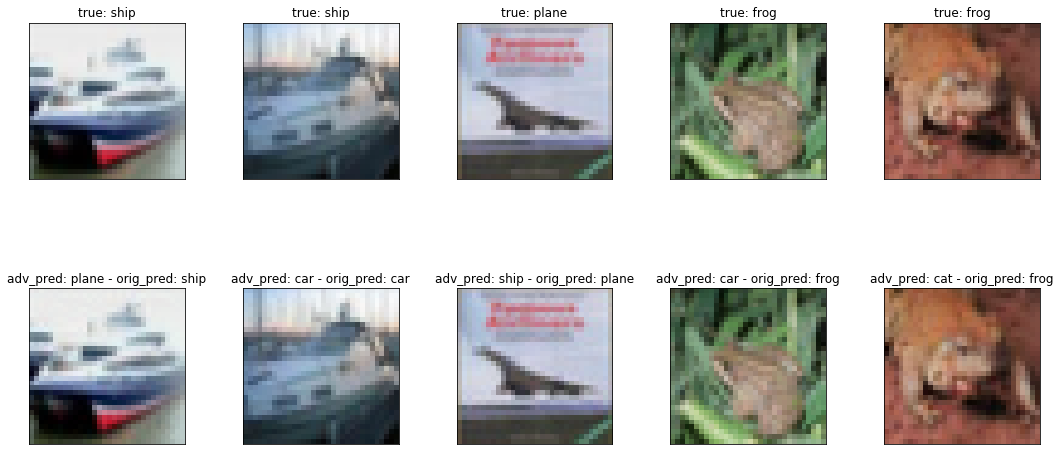

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.51 inception_score 3.03418203094154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


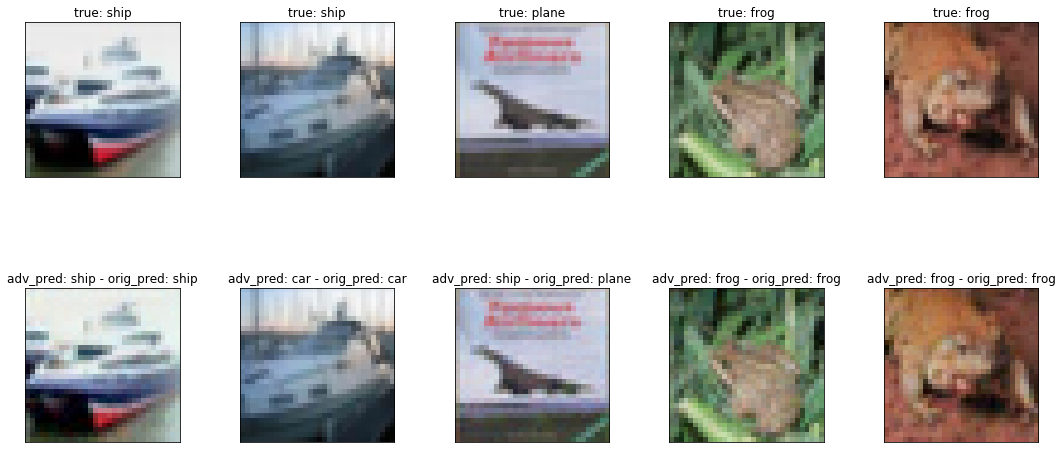

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0 inception_score 2.9469242329892387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


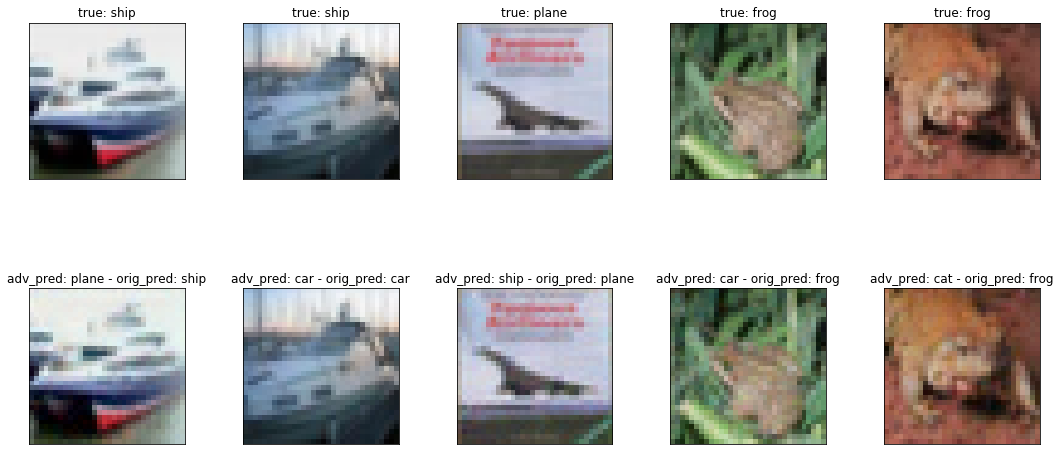

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1000 - confidence: 20 - pert_acc: 0.0 inception_score 2.871092437217052


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


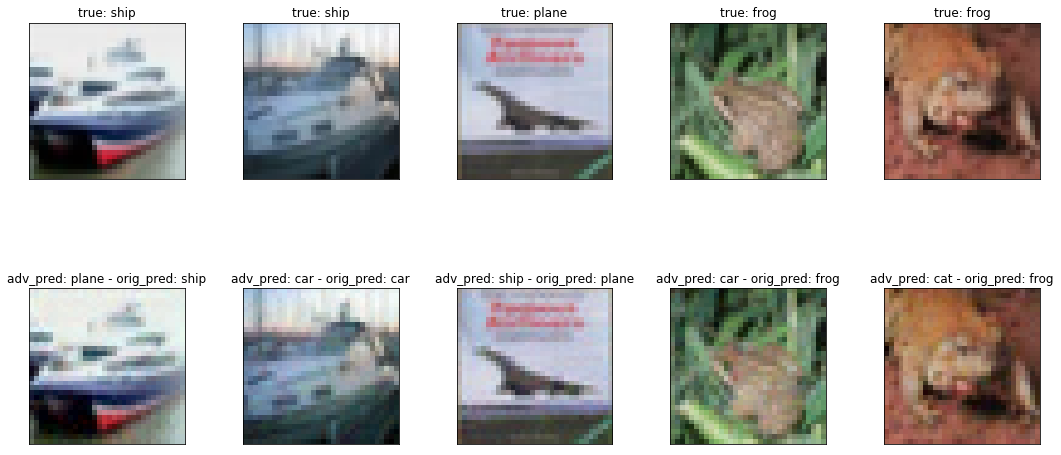

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.67 inception_score 2.4205223662881226


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


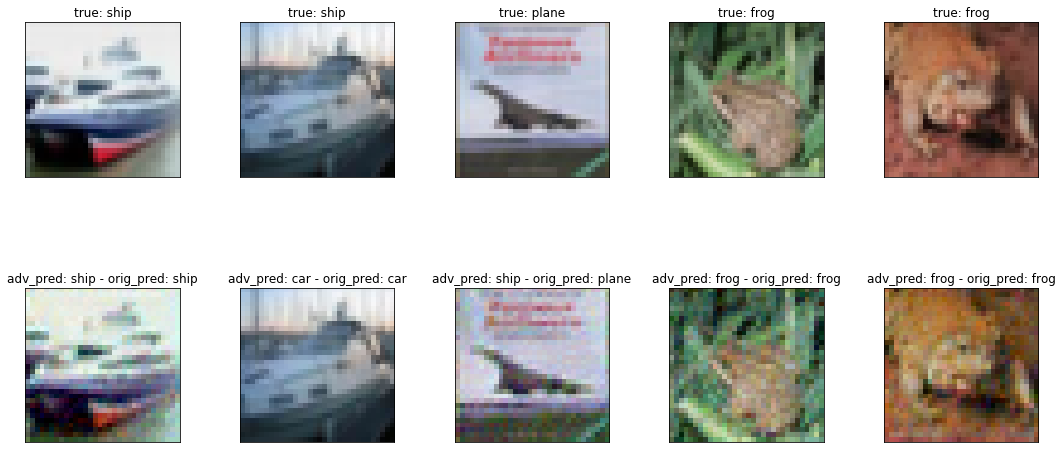

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0 inception_score 2.232126510277692


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


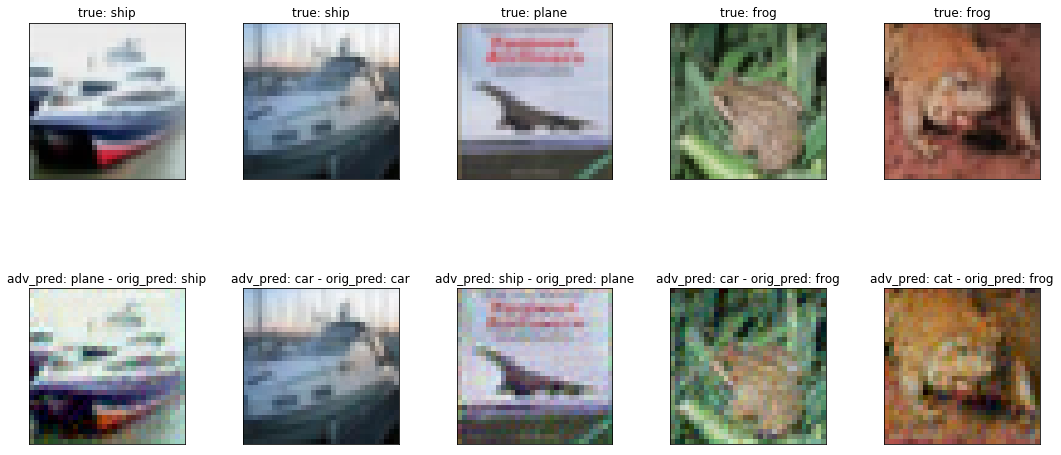

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10000 - confidence: 20 - pert_acc: 0.0 inception_score 2.118247882954889


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


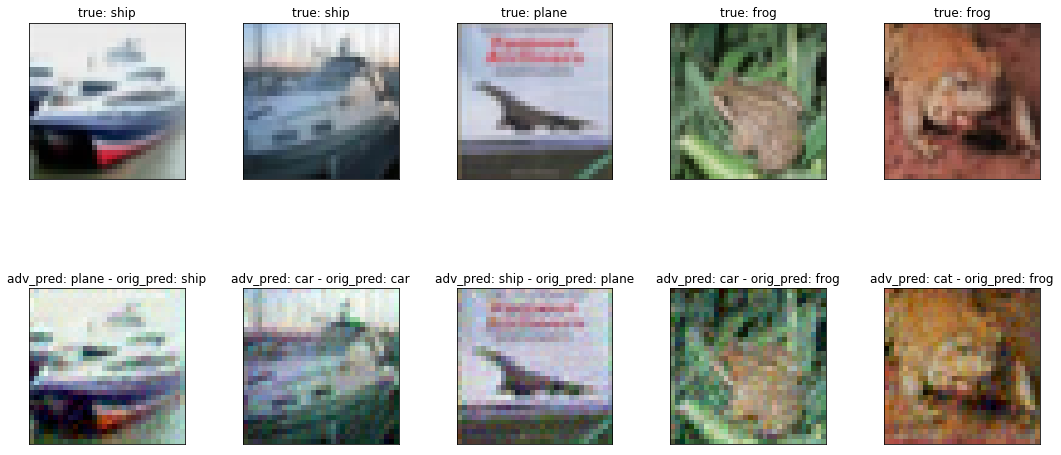

In [89]:
for result in results:
    
    # reference data
    attack = result['attack']
    layers = result['layers']
    rw = result['regularization_weight']
    conf = result['confidence']
    pert_acc = result['pert_acc']
    adversaries = result['adversaries']
    inception_score = result['inception_score']

    print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc, 'inception_score', inception_score)
        
    adversaries = result['adversaries']
    sample_3D_images(model, inputs, adversaries, targets, classes)

# Investigating small NC threshold behavior

In [66]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'confidence', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

attack  confidence  regularization_weight  orig_acc  pert_acc  \
0   cw_div4_attack           0                      0      0.93      0.64   
1   cw_div4_attack          10                      0      0.93      0.00   
2   cw_div4_attack          20                      0      0.93      0.00   
3   cw_div4_attack           0                      1      0.93      0.62   
4   cw_div4_attack          10                      1      0.93      0.00   
5   cw_div4_attack          20                      1      0.93      0.00   
6   cw_div4_attack           0                     10      0.93      0.68   
7   cw_div4_attack          10                     10      0.93      0.00   
8   cw_div4_attack          20                     10      0.93      0.00   
9   cw_div4_attack           0                    100      0.93      0.43   
10  cw_div4_attack          10                    100      0.93      0.00   
11  cw_div4_attack          20                    100      0.93      0.00   
12  cw_div4_attack           0                   1000      0.93      0.51   
13  cw_div4_attack          10                   1000      0.93      0.00   
14  cw_div4_attack          20                   1000      0.93      0.00   
15  cw_div4_attack           0                  10000      0.93      0.67   
16  cw_div4_attack          10                  10000      0.93      0.00   
17  cw_div4_attack          20                  10000      0.93      0.00   

    neuron_coverage_000  neuron_coverage_020  neuron_coverage_050  \
0          0.9521887735         0.2754530602         0.0561080959   
1          0.9520610716         0.2759432102         0.0561325095   
2          0.9514601213         0.2773009822         0.0563578659   
3          0.9522094312         0.2755939079         0.0559428346   
4          0.9520122444         0.2760521324         0.0558132547   
5          0.9514601213         0.2771507446         0.0563503540   
6          0.9520629495         0.2761817123         0.0559334448   
7          0.9516817217         0.2769178764         0.0557062104   
8          0.9514037822         0.2774737554         0.0558977633   
9          0.9516685759         0.2795113523         0.0562921369   
10         0.9512385209         0.2811113824         0.0566264155   
11         0.9506131571         0.2816728953         0.0565757103   
12         0.9501492986         0.2844410224         0.0586978159   
13         0.9495821518         0.2858419876         0.0591616744   
14         0.9491389510         0.2867584368         0.0592499390   
15         0.9501079832         0.2884016601         0.0613720445   
16         0.9481173355         0.2901312701         0.0637514320   
17         0.9480046574         0.2904261113         0.0621720596   

    neuron_coverage_075  
0          0.0132866345  
1          0.0131833462  
2          0.0132622209  
3          0.0132321734  
4          0.0131758343  
5          0.0131739563  
6          0.0130744239  
7          0.0131063494  
8          0.0129955492  
9          0.0130030611  
10         0.0132791226  
11         0.0131345190  
12         0.0131194952  
13         0.0129204304  
14         0.0128885049  
15         0.0131720783  
16         0.0137974422  
17         0.0136246690

In [39]:
inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

In [40]:
nc_per_threshold = {}

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    
    print('threshold', t)
    
    covered_neurons, total_neurons, neuron_coverage = eval_nc(model, inputs, t)
    
    print(covered_neurons, total_neurons, neuron_coverage)

    nc_per_threshold[t] = {
        'covered_neurons':covered_neurons,
        'total_neurons':total_neurons,
        'neuron_coverage':neuron_coverage
    }

threshold 0.0


507181 532490 0.952470468928994
threshold 0.01


439025 532490 0.8244755770061409
threshold 0.02


406279 532490 0.7629795864711074
threshold 0.03


378613 532490 0.711023681195891
threshold 0.04


352765 532490 0.6624819245431839
threshold 0.05


329463 532490 0.6187214783376214
threshold 0.06


309340 532490 0.5809310972976018
threshold 0.07


291612 532490 0.5476384533042874
threshold 0.08


275689 532490 0.517735544329471
threshold 0.09


260303 532490 0.48884110499727695
threshold 0.1


245829 532490 0.4616593738849556
threshold 0.11


232238 532490 0.4361358898758662
threshold 0.12


220158 532490 0.4134500178407106
threshold 0.13


208947 532490 0.39239610133523634
threshold 0.14


198426 532490 0.37263798381190255
threshold 0.15


188591 532490 0.354168153392552
threshold 0.16


179608 532490 0.337298353020714
threshold 0.17


170909 532490 0.3209618959980469
threshold 0.18


162411 532490 0.30500291085278597
threshold 0.19


154125 532490 0.2894420552498638
threshold 0.2


145941 532490 0.2740727525399538
threshold 0.21


138069 532490 0.259289376326316
threshold 0.22


130397 532490 0.244881594020545
threshold 0.23


123295 532490 0.23154425435219442
threshold 0.24


116462 532490 0.21871208848992468
threshold 0.25


110161 532490 0.2068790024225807
threshold 0.26


104391 532490 0.19604311818062312
threshold 0.27


98982 532490 0.1858851809423651
threshold 0.28


94031 532490 0.17658735375312212
threshold 0.29


89330 532490 0.16775901894871265
threshold 0.3


84939 532490 0.15951285470149673
threshold 0.31


80887 532490 0.15190332212811508
threshold 0.32


77065 532490 0.14472572254878027
threshold 0.33


73660 532490 0.13833123626734775
threshold 0.34


70444 532490 0.13229168622884938
threshold 0.35000000000000003


67478 532490 0.12672162857518451
threshold 0.36


64490 532490 0.12111025559165431
threshold 0.37


61520 532490 0.11553268605983211
threshold 0.38


58653 532490 0.11014854739056132
threshold 0.39


55752 532490 0.10470055775695318
threshold 0.4


52735 532490 0.09903472365678229
threshold 0.41000000000000003


49858 532490 0.09363180529211816
threshold 0.42


47190 532490 0.08862138256117486
threshold 0.43


44553 532490 0.08366917688595091
threshold 0.44


42073 532490 0.07901181242840241
threshold 0.45


39680 532490 0.07451783132077598
threshold 0.46


37437 532490 0.07030554564404966
threshold 0.47000000000000003


35198 532490 0.06610077184548066
threshold 0.48


33190 532490 0.06232980901049785
threshold 0.49


31314 532490 0.05880673815470713
threshold 0.5


29534 532490 0.05546395237469248
threshold 0.51


27927 532490 0.05244605532498263
threshold 0.52


26377 532490 0.04953520253901482
threshold 0.53


24903 532490 0.0467670754380364
threshold 0.54


23655 532490 0.044423369452947475
threshold 0.55


22437 532490 0.04213600255403857
threshold 0.56


21289 532490 0.03998009352288306
threshold 0.5700000000000001


20203 532490 0.037940618603166255
threshold 0.58


19254 532490 0.036158425510338224
threshold 0.59


18352 532490 0.03446449698585889
threshold 0.6


17514 532490 0.032890758511896934
threshold 0.61


16601 532490 0.03117617232248493
threshold 0.62


15738 532490 0.029555484610039626
threshold 0.63


14865 532490 0.02791601720220098
threshold 0.64


14028 532490 0.026344156697778363
threshold 0.65


13235 532490 0.024854926853086445
threshold 0.66


12471 532490 0.02342015812503521
threshold 0.67


11734 532490 0.022036094574546
threshold 0.68


11014 532490 0.020683956506225468
threshold 0.6900000000000001


10339 532490 0.01941632706717497
threshold 0.7000000000000001


9710 532490 0.01823508422693384
threshold 0.71


9092 532490 0.01707449905162538
threshold 0.72


8535 532490 0.016028470018216303
threshold 0.73


8005 532490 0.015033146162369247
threshold 0.74


7465 532490 0.014019042611128848
threshold 0.75


6975 532490 0.013098837536855153
threshold 0.76


6492 532490 0.012191778249356796
threshold 0.77


5986 532490 0.011241525662453756
threshold 0.78


5445 532490 0.010225544141674023
threshold 0.79


4919 532490 0.0092377321639843
threshold 0.8


4430 532490 0.008319405059249938
threshold 0.81


3974 532490 0.007463050949313602
threshold 0.8200000000000001


3561 532490 0.00668744952956863
threshold 0.8300000000000001


3121 532490 0.005861142932261638
threshold 0.84


2747 532490 0.005158782324550696
threshold 0.85


2410 532490 0.0045259065897951135
threshold 0.86


2088 532490 0.003921200398129542
threshold 0.87


1774 532490 0.0033315179627786437
threshold 0.88


1484 532490 0.002786906796371763
threshold 0.89


1214 532490 0.0022798550207515636
threshold 0.9


987 532490 0.001853555935322729
threshold 0.91


770 532490 0.0014460365452872354
threshold 0.92


581 532490 0.001091100302353096
threshold 0.93


449 532490 0.0008432083231609983
threshold 0.9400000000000001


340 532490 0.0006385096433735844
threshold 0.9500000000000001


257 532490 0.0004826381716088565
threshold 0.96


194 532490 0.00036432609063081
threshold 0.97


146 532490 0.0002741835527427745
threshold 0.98


116 532490 0.00021784446656275235
threshold 0.99


72 532490 0.00013521380683205318
threshold 1.0


0 532490 0.0


In [45]:
df = pd.DataFrame.from_dict(nc_per_threshold).T
df.reset_index(level=0, inplace=True)
df.rename(columns={"index": "threshold"}, inplace=True)
df

threshold  covered_neurons  total_neurons  neuron_coverage
0         0.00         507181.0       532490.0     0.9524704689
1         0.01         439025.0       532490.0     0.8244755770
2         0.02         406279.0       532490.0     0.7629795865
3         0.03         378613.0       532490.0     0.7110236812
4         0.04         352765.0       532490.0     0.6624819245
5         0.05         329463.0       532490.0     0.6187214783
6         0.06         309340.0       532490.0     0.5809310973
7         0.07         291612.0       532490.0     0.5476384533
8         0.08         275689.0       532490.0     0.5177355443
9         0.09         260303.0       532490.0     0.4888411050
10        0.10         245829.0       532490.0     0.4616593739
11        0.11         232238.0       532490.0     0.4361358899
12        0.12         220158.0       532490.0     0.4134500178
13        0.13         208947.0       532490.0     0.3923961013
14        0.14         198426.0       532490.0     0.3726379838
15        0.15         188591.0       532490.0     0.3541681534
16        0.16         179608.0       532490.0     0.3372983530
17        0.17         170909.0       532490.0     0.3209618960
18        0.18         162411.0       532490.0     0.3050029109
19        0.19         154125.0       532490.0     0.2894420552
20        0.20         145941.0       532490.0     0.2740727525
21        0.21         138069.0       532490.0     0.2592893763
22        0.22         130397.0       532490.0     0.2448815940
23        0.23         123295.0       532490.0     0.2315442544
24        0.24         116462.0       532490.0     0.2187120885
25        0.25         110161.0       532490.0     0.2068790024
26        0.26         104391.0       532490.0     0.1960431182
27        0.27          98982.0       532490.0     0.1858851809
28        0.28          94031.0       532490.0     0.1765873538
29        0.29          89330.0       532490.0     0.1677590189
30        0.30          84939.0       532490.0     0.1595128547
31        0.31          80887.0       532490.0     0.1519033221
32        0.32          77065.0       532490.0     0.1447257225
33        0.33          73660.0       532490.0     0.1383312363
34        0.34          70444.0       532490.0     0.1322916862
35        0.35          67478.0       532490.0     0.1267216286
36        0.36          64490.0       532490.0     0.1211102556
37        0.37          61520.0       532490.0     0.1155326861
38        0.38          58653.0       532490.0     0.1101485474
39        0.39          55752.0       532490.0     0.1047005578
40        0.40          52735.0       532490.0     0.0990347237
41        0.41          49858.0       532490.0     0.0936318053
42        0.42          47190.0       532490.0     0.0886213826
43        0.43          44553.0       532490.0     0.0836691769
44        0.44          42073.0       532490.0     0.0790118124
45        0.45          39680.0       532490.0     0.0745178313
46        0.46          37437.0       532490.0     0.0703055456
47        0.47          35198.0       532490.0     0.0661007718
48        0.48          33190.0       532490.0     0.0623298090
49        0.49          31314.0       532490.0     0.0588067382
50        0.50          29534.0       532490.0     0.0554639524
51        0.51          27927.0       532490.0     0.0524460553
52        0.52          26377.0       532490.0     0.0495352025
53        0.53          24903.0       532490.0     0.0467670754
54        0.54          23655.0       532490.0     0.0444233695
55        0.55          22437.0       532490.0     0.0421360026
56        0.56          21289.0       532490.0     0.0399800935
57        0.57          20203.0       532490.0     0.0379406186
58        0.58          19254.0       532490.0     0.0361584255
59        0.59          18352.0       532490.0     0.0344644970
60        0.60          17514.0       532490.0     0.0328907585
61        0.61          16601.0      

In [46]:
df.corr()

threshold  covered_neurons  total_neurons  neuron_coverage
threshold        1.0000000000    -0.8308252224            NaN    -0.8308252224
covered_neurons -0.8308252224     1.0000000000            NaN     1.0000000000
total_neurons             NaN              NaN            NaN              NaN
neuron_coverage -0.8308252224     1.0000000000            NaN     1.0000000000

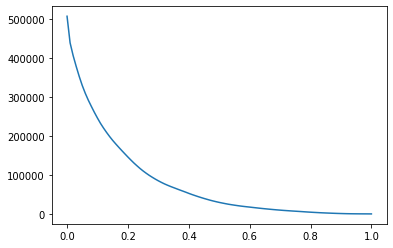

In [47]:
X = df['threshold'].values.reshape(-1, 1)
y = df['covered_neurons'].values.reshape(-1, 1)
plt.plot(X, y)

In [48]:
save_file_path = "assets/nc_threshold_analysis_cifar10.pkl"
pickle.dump(nc_per_threshold, open(save_file_path, "wb")) 

# Heatmap Visualization

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# load the results from file
with open('assets/results_cifar10_2019.08.28.pkl', 'rb') as handle:
    results = pickle.load(handle)

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29


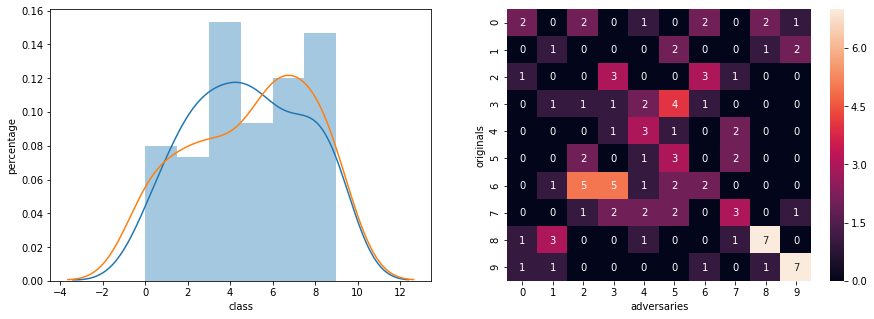

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


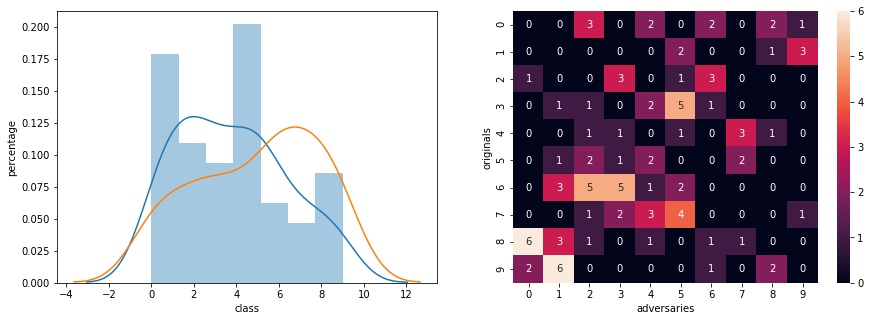

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


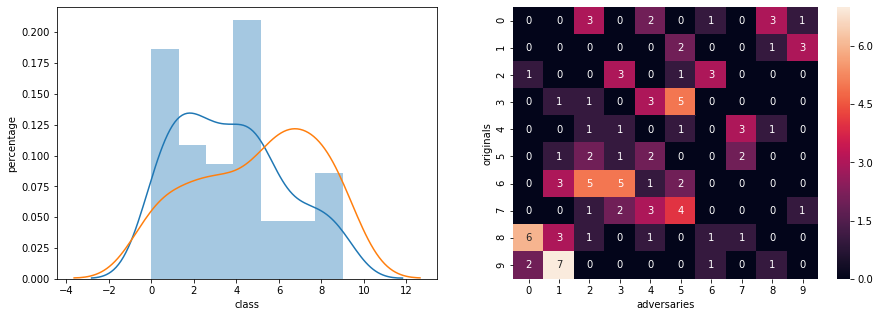

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28


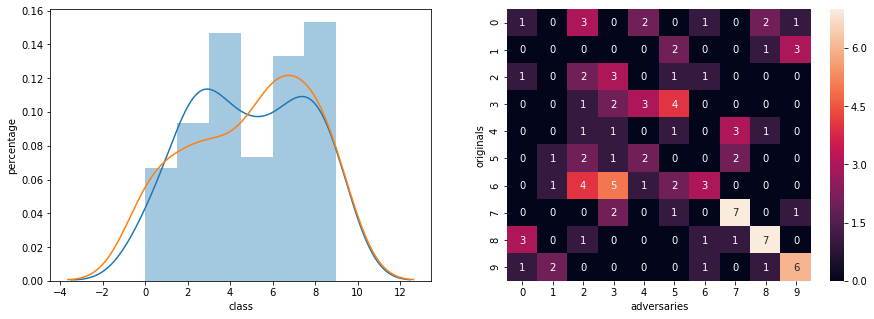

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01


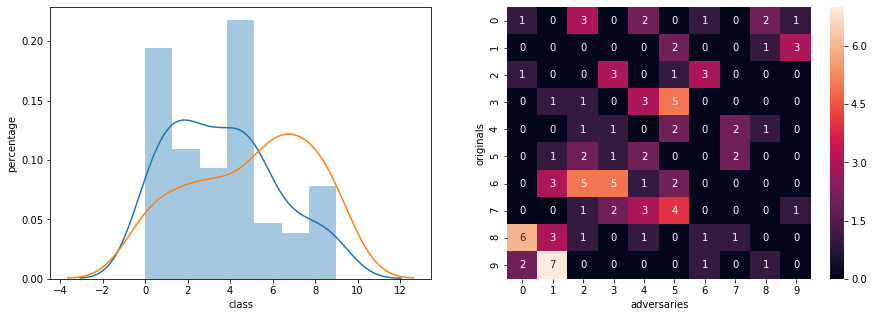

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


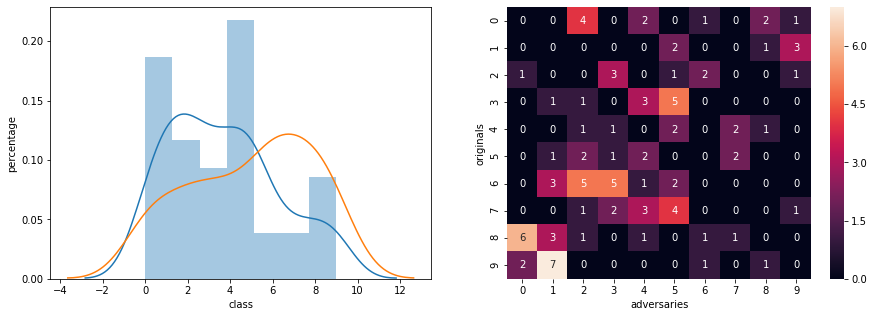

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.29


KeyboardInterrupt: 

<Figure size 1080x360 with 0 Axes>

In [14]:
y_true = targets.cpu().numpy()

for result in results:
    
    # reference data
    attack = result['attack']
    layer = result['layer']
    rw = result['regularization_weight']
    conf = result['confidence']
    pert_acc = result['pert_acc']
    print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc)
    
    # adversary class predictions
    pert_output = model(result['adversaries'])
    y_pred = torch.argmax(pert_output, dim=1).cpu().numpy()
    
    # plots
    fig, ax = plt.subplots(1, 2, figsize = (15,5))

    # distplot
    sns.distplot(y_pred, ax=ax[0])
    sns.distplot(y_true, hist=False, ax=ax[0])
    ax[0].set_xlabel('class')
    ax[0].set_ylabel('percentage')
    
    # heatmap
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, ax=ax[1])
    ax[1].set_xlabel('adversaries')
    ax[1].set_ylabel('originals')
    
    plt.show()

# Investigating how Adversarial Perturbation Affects NC distribution

In [7]:
nc_per_threshold_adv = {}

thresholds = np.linspace(0, 1, 101)

for result in results:
    
    # reference data
    attack = result['attack']
    layer = result['layer']
    rw = result['regularization_weight']
    conf = result['confidence']
    pert_acc = result['pert_acc']
    adversaries = result['adversaries']

    print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc)

    for t in thresholds:

        print('threshold', t)

        covered_neurons, total_neurons, neuron_coverage = eval_nc(model, adversaries, t)

        print(covered_neurons, total_neurons, neuron_coverage)

        nc_per_threshold_adv[(t, layer, rw, conf)] = {
            'covered_neurons':covered_neurons,
            'total_neurons':total_neurons,
            'neuron_coverage':neuron_coverage
        }

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29
threshold 0.0



506901 532490 0.9519446374579804
threshold 0.01



438860 532490 0.8241657120321508
threshold 0.02



406376 532490 0.7631617495164228
threshold 0.03



379031 532490 0.7118086724633327
threshold 0.04



353325 532490 0.663533587485211
threshold 0.05



330029 532490 0.6197844090968845
threshold 0.06



309692 532490 0.5815921425754474
threshold 0.07



292101 532490 0.5485567804090218
threshold 0.08



276264 532490 0.5188153768145881
threshold 0.09



260971 532490 0.4900955886495521
threshold 0.1



246893 532490 0.46365753347480704
threshold 0.11



233388 532490 0.4382955548461004
threshold 0.12



221346 532490 0.4156810456534395
threshold 0.13



210186 532490 0.39472290559447126
threshold 0.14



199787 532490 0.3751939003549362
threshold 0.15



190097 532490 0.3569963755187891
threshold 0.16



181176 532490 0.34024300925838985
threshold 0.17



172543 532490 0.32403049822531876
threshold 0.18



164176 532490 0.3083175270897106
threshold 0.19



155840 532490 0.2926627730098218
threshold 0.2



147659 532490 0.2772991042085297
threshold 0.21



139554 532490 0.2620781610922271
threshold 0.22



131838 532490 0.24758774812672538
threshold 0.23



124501 532490 0.2338090856166313
threshold 0.24



117652 532490 0.22094687224173223
threshold 0.25



111318 532490 0.20905181317959023
threshold 0.26



105420 532490 0.19797554883659788
threshold 0.27



99922 532490 0.18765047230933915
threshold 0.28



94896 532490 0.1782117974046461
threshold 0.29



90132 532490 0.16926515051925858
threshold 0.3



85757 532490 0.161049033784672
threshold 0.31



81623 532490 0.15328550770906496
threshold 0.32



77843 532490 0.14618678285038217
threshold 0.33



74379 532490 0.13968149636612895
threshold 0.34



71127 532490 0.13357433942421454
threshold 0.35000000000000003



68147 532490 0.12797799019699901
threshold 0.36



65093 532490 0.12224267122387275
threshold 0.37



62177 532490 0.1167665120471746
threshold 0.38



59271 532490 0.11130913256586979
threshold 0.39



56341 532490 0.10580668181562095
threshold 0.4



53299 532490 0.1000938984769667
threshold 0.41000000000000003



50407 532490 0.09466281056921257
threshold 0.42



47765 532490 0.08970121504629194
threshold 0.43



45158 532490 0.08480534845724802
threshold 0.44



42752 532490 0.08028695374561025
threshold 0.45



40354 532490 0.07578358279028714
threshold 0.46



38031 532490 0.0714210595504141
threshold 0.47000000000000003



35859 532490 0.0673421097109805
threshold 0.48



33885 532490 0.06363499784033504
threshold 0.49



31930 532490 0.05996356739093692
threshold 0.5



30115 532490 0.05655505267704558
threshold 0.51



28476 532490 0.053477060602077034
threshold 0.52



26915 532490 0.050545550151176545
threshold 0.53



25478 532490 0.047846907923153485
threshold 0.54



24160 532490 0.04537174407031118
threshold 0.55



22927 532490 0.04305620762831227
threshold 0.56



21703 532490 0.04075757291216736
threshold 0.5700000000000001



20644 532490 0.038768803170012585
threshold 0.58



19649 532490 0.03690022347837518
threshold 0.59



18719 532490 0.035153711806794496
threshold 0.6



17828 532490 0.033480440947247836
threshold 0.61



16937 532490 0.031807170087701175
threshold 0.62



16032 532490 0.03010760765460384
threshold 0.63



15202 532490 0.028548892936956564
threshold 0.64



14338 532490 0.026926327254971925
threshold 0.65



13538 532490 0.025423951623504668
threshold 0.66



12745 532490 0.023934721778812746
threshold 0.67



12023 532490 0.022578827771413547
threshold 0.68



11294 532490 0.02120978797723901
threshold 0.6900000000000001



10594 532490 0.01989520929970516
threshold 0.7000000000000001



9928 532490 0.018644481586508665
threshold 0.71



9281 532490 0.017429435294559523
threshold 0.72



8700 532490 0.016338334992206428
threshold 0.73



8127 532490 0.015262258446168003
threshold 0.74



7605 532490 0.014281958346635617
threshold 0.75



7104 532490 0.013341095607429248
threshold 0.76



6634 532490 0.012458449923942233
threshold 0.77



6081 532490 0.011419932768690492
threshold 0.78



5530 532490 0.010385171552517418
threshold 0.79



4946 532490 0.00928843734154632
threshold 0.8



4441 532490 0.008340062724182614
threshold 0.81



3973 532490 0.007461172979774268
threshold 0.8200000000000001



3512 532490 0.006595429022141261
threshold 0.8300000000000001



3113 532490 0.0058461191759469665
threshold 0.84



2719 532490 0.005106199177449342
threshold 0.85



2367 532490 0.0044451538996037486
threshold 0.86



2031 532490 0.0038141561343875002
threshold 0.87



1736 532490 0.003260155120283949
threshold 0.88



1420 532490 0.002666716745854382
threshold 0.89



1161 532490 0.0021803226351668576
threshold 0.9



939 532490 0.0017634133974346936
threshold 0.91



725 532490 0.0013615279160172022
threshold 0.92



564 532490 0.0010591748201844167
threshold 0.93



446 532490 0.0008375744145429961
threshold 0.9400000000000001



343 532490 0.0006441435519915867
threshold 0.9500000000000001



264 532490 0.000495783958384195
threshold 0.96



205 532490 0.00038498375556348475
threshold 0.97



156 532490 0.00029296324813611526
threshold 0.98



118 532490 0.00022160040564142048
threshold 0.99



81 532490 0.00015211553268605984
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0
threshold 0.0



506753 532490 0.951666697966159
threshold 0.01



439019 532490 0.824464309188905
threshold 0.02



406593 532490 0.7635692689064584
threshold 0.03



379395 532490 0.7124922533756503
threshold 0.04



353583 532490 0.6640181036263592
threshold 0.05



330379 532490 0.6204416984356513
threshold 0.06



310141 532490 0.5824353508986084
threshold 0.07



292698 532490 0.5496779282240042
threshold 0.08



276737 532490 0.5197036564066931
threshold 0.09



261371 532490 0.49084677646528574
threshold 0.1



247252 532490 0.46433172453942795
threshold 0.11



233872 532490 0.4392044921031381
threshold 0.12



221986 532490 0.4168829461586133
threshold 0.13



210758 532490 0.39579710417097036
threshold 0.14



200362 532490 0.37627373284005333
threshold 0.15



190699 532490 0.3581269131814682
threshold 0.16



181712 532490 0.3412496009314729
threshold 0.17



173147 532490 0.3251647918270766
threshold 0.18



164799 532490 0.30948750211271575
threshold 0.19



156403 532490 0.29372006986046684
threshold 0.2



148216 532490 0.2783451332419388
threshold 0.21



140220 532490 0.2633288888054236
threshold 0.22



132468 532490 0.24877086893650585
threshold 0.23



125125 532490 0.23498093860917577
threshold 0.24



118145 532490 0.22187271122462393
threshold 0.25



111751 532490 0.20986497399012188
threshold 0.26



105797 532490 0.19868354335292682
threshold 0.27



100488 532490 0.18871340306860224
threshold 0.28



95427 532490 0.1792089992300325
threshold 0.29



90648 532490 0.17023418280155495
threshold 0.3



86322 532490 0.16211008657439577
threshold 0.31



82170 532490 0.1543127570470807
threshold 0.32



78261 532490 0.1469717741178238
threshold 0.33



74824 532490 0.1405171928111326
threshold 0.34



71527 532490 0.13432552723994817
threshold 0.35000000000000003



68493 532490 0.12862776765760858
threshold 0.36



65499 532490 0.12300512685684238
threshold 0.37



62523 532490 0.11741628950778418
threshold 0.38



59628 532490 0.11197956769141204
threshold 0.39



56723 532490 0.10652406617964656
threshold 0.4



53754 532490 0.10094837461736371
threshold 0.41000000000000003



50798 532490 0.09539709665909218
threshold 0.42



48020 532490 0.09018009727882213
threshold 0.43



45435 532490 0.08532554601964357
threshold 0.44



42939 532490 0.08063813404946572
threshold 0.45



40506 532490 0.07606903416026592
threshold 0.46



38217 532490 0.07177036188473022
threshold 0.47000000000000003



36012 532490 0.0676294390504986
threshold 0.48



33979 532490 0.06381152697703243
threshold 0.49



32060 532490 0.06020770343105035
threshold 0.5



30281 532490 0.056866795620575034
threshold 0.51



28577 532490 0.05366673552554978
threshold 0.52



27025 532490 0.0507521268005033
threshold 0.53



25566 532490 0.04801216924261489
threshold 0.54



24230 532490 0.045503201938064564
threshold 0.55



22978 532490 0.04315198407481831
threshold 0.56



21774 532490 0.04089090874946008
threshold 0.5700000000000001



20696 532490 0.03886645758605795
threshold 0.58



19742 532490 0.03707487464553325
threshold 0.59



18792 532490 0.03529080358316588
threshold 0.6



17899 532490 0.033613776784540556
threshold 0.61



17021 532490 0.03196491952900524
threshold 0.62



16110 532490 0.0302540892786719
threshold 0.63



15267 532490 0.028670960957013276
threshold 0.64



14389 532490 0.02702210370147796
threshold 0.65



13592 532490 0.025525361978628706
threshold 0.66



12781 532490 0.024002328682228773
threshold 0.67



12085 532490 0.02269526188285226
threshold 0.68



11355 532490 0.02132434411913839
threshold 0.6900000000000001



10643 532490 0.01998722980713253
threshold 0.7000000000000001



10008 532490 0.018794719149655394
threshold 0.71



9332 532490 0.01752521174106556
threshold 0.72



8735 532490 0.01640406392608312
threshold 0.73



8201 532490 0.015401228192078724
threshold 0.74



7666 532490 0.014396514488534996
threshold 0.75



7162 532490 0.013450017840710624
threshold 0.76



6681 532490 0.012546714492290934
threshold 0.77



6170 532490 0.011587072057691224
threshold 0.78



5580 532490 0.010479070029484122
threshold 0.79



5026 532490 0.009438674904693046
threshold 0.8



4495 532490 0.008441473079306653
threshold 0.81



4055 532490 0.007615166481999662
threshold 0.8200000000000001



3586 532490 0.006734398768051982
threshold 0.8300000000000001



3151 532490 0.0059174820184416605
threshold 0.84



2790 532490 0.005239535014742061
threshold 0.85



2434 532490 0.004570977858739131
threshold 0.86



2093 532490 0.003930590245826213
threshold 0.87



1773 532490 0.0033296399932393095
threshold 0.88



1482 532490 0.002783150857293095
threshold 0.89



1212 532490 0.002276099081672895
threshold 0.9



964 532490 0.0018103626359180455
threshold 0.91



772 532490 0.0014497924843659036
threshold 0.92



588 532490 0.0011042460891284344
threshold 0.93



468 532490 0.0008788897444083457
threshold 0.9400000000000001



362 532490 0.0006798249732389341
threshold 0.9500000000000001



282 532490 0.0005295874100922083
threshold 0.96



215 532490 0.0004037634509568255
threshold 0.97



156 532490 0.00029296324813611526
threshold 0.98



120 532490 0.00022535634472008864
threshold 0.99



82 532490 0.0001539935022253939
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0
threshold 0.0



506615 532490 0.9514075381697309
threshold 0.01



438888 532490 0.8242182951792522
threshold 0.02



406620 532490 0.7636199740840204
threshold 0.03



379267 532490 0.7122518732746155
threshold 0.04



353657 532490 0.6641570733722699
threshold 0.05



330447 532490 0.6205694003643261
threshold 0.06



310147 532490 0.5824466187158445
threshold 0.07



292691 532490 0.5496647824372288
threshold 0.08



276809 532490 0.5198388702135252
threshold 0.09



261575 532490 0.49122988225130987
threshold 0.1



247449 532490 0.4647016845386768
threshold 0.11



234113 532490 0.4396570827621176
threshold 0.12



222282 532490 0.4174388251422562
threshold 0.13



211077 532490 0.3963961764540179
threshold 0.14



200707 532490 0.3769216323311236
threshold 0.15



191136 532490 0.3589475858701572
threshold 0.16



182180 532490 0.34212849067588125
threshold 0.17



173515 532490 0.3258558846175515
threshold 0.18



165207 532490 0.310253713684764
threshold 0.19



156681 532490 0.29424214539240173
threshold 0.2



148622 532490 0.27910758887490844
threshold 0.21



140517 532490 0.2638866457586058
threshold 0.22



132685 532490 0.24917838832654135
threshold 0.23



125361 532490 0.2354241394204586
threshold 0.24



118424 532490 0.22239666472609815
threshold 0.25



112036 532490 0.21040019530883208
threshold 0.26



106133 532490 0.19931454111814306
threshold 0.27



100700 532490 0.18911153261094105
threshold 0.28



95617 532490 0.17956581344250597
threshold 0.29



90798 532490 0.17051587823245506
threshold 0.3



86495 532490 0.16243497530470055
threshold 0.31



82366 532490 0.15468083907679017
threshold 0.32



78477 532490 0.14737741553831996
threshold 0.33



74977 532490 0.14080452215065073
threshold 0.34



71710 532490 0.1346691956656463
threshold 0.35000000000000003



68644 532490 0.12891134105804805
threshold 0.36



65623 532490 0.1232379950797198
threshold 0.37



62664 532490 0.11768108321283029
threshold 0.38



59742 532490 0.11219365621889613
threshold 0.39



56864 532490 0.10678885988469267
threshold 0.4



53849 532490 0.10112678172360044
threshold 0.41000000000000003



50883 532490 0.09555672406993558
threshold 0.42



48157 532490 0.09043737910571091
threshold 0.43



45477 532490 0.0854044207402956
threshold 0.44



42947 532490 0.08065315780578039
threshold 0.45



40490 532490 0.07603898664763657
threshold 0.46



38161 532490 0.07166519559052752
threshold 0.47000000000000003



36001 532490 0.06760878138556592
threshold 0.48



34025 532490 0.0638979135758418
threshold 0.49



32131 532490 0.06034103926834307
threshold 0.5



30301 532490 0.056904355011361714
threshold 0.51



28643 532490 0.05379068151514582
threshold 0.52



27055 532490 0.05080846588668332
threshold 0.53



25590 532490 0.0480572405115589
threshold 0.54



24228 532490 0.045499445998985893
threshold 0.55



22962 532490 0.04312193656218896
threshold 0.56



21790 532490 0.04092095626208943
threshold 0.5700000000000001



20717 532490 0.03890589494638397
threshold 0.58



19762 532490 0.03711243403631993
threshold 0.59



18815 532490 0.035333996882570565
threshold 0.6



17908 532490 0.033630678510394564
threshold 0.61



17036 532490 0.03199308907209525
threshold 0.62



16130 532490 0.03029164866945858
threshold 0.63



15283 532490 0.028701008469642623
threshold 0.64



14423 532490 0.027085954665815322
threshold 0.65



13587 532490 0.025515972130932037
threshold 0.66



12783 532490 0.024006084621307443
threshold 0.67



12070 532490 0.02266709233976225
threshold 0.68



11347 532490 0.021309320362823715
threshold 0.6900000000000001



10620 532490 0.019944036507727844
threshold 0.7000000000000001



9942 532490 0.018670773160059342
threshold 0.71



9294 532490 0.017453848898570865
threshold 0.72



8691 532490 0.01632143326635242
threshold 0.73



8143 532490 0.015292305958797348
threshold 0.74



7627 532490 0.014323273676500967
threshold 0.75



7139 532490 0.01340682454130594
threshold 0.76



6637 532490 0.012464083832560235
threshold 0.77



6132 532490 0.01151570921519653
threshold 0.78



5552 532490 0.010426486882382768
threshold 0.79



4993 532490 0.009376701909895022
threshold 0.8



4475 532490 0.008403913688519973
threshold 0.81



4032 532490 0.007571973182594978
threshold 0.8200000000000001



3560 532490 0.006685571560029296
threshold 0.8300000000000001



3142 532490 0.0059005802925876545
threshold 0.84



2750 532490 0.005164416233168698
threshold 0.85



2395 532490 0.004497737046705102
threshold 0.86



2074 532490 0.003894908824578865
threshold 0.87



1756 532490 0.0032977145110706305
threshold 0.88



1477 532490 0.0027737610095964244
threshold 0.89



1184 532490 0.0022235159345715414
threshold 0.9



945 532490 0.001774681214670698
threshold 0.91



750 532490 0.001408477154500554
threshold 0.92



572 532490 0.001074198576499089
threshold 0.93



460 532490 0.0008638659880936731
threshold 0.9400000000000001



351 532490 0.0006591673083062593
threshold 0.9500000000000001



273 532490 0.0005126856842382016
threshold 0.96



221 532490 0.00041503126819282993
threshold 0.97



161 532490 0.0003023530958327856
threshold 0.98



120 532490 0.00022535634472008864
threshold 0.99



83 532490 0.00015587147176472798
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28
threshold 0.0



507157 532490 0.95242539766005
threshold 0.01



439185 532490 0.8247760521324344
threshold 0.02



406769 532490 0.7638997915453811
threshold 0.03



379308 532490 0.7123288700257282
threshold 0.04



353507 532490 0.6638753779413697
threshold 0.05



330233 532490 0.6201675148829086
threshold 0.06



309964 532490 0.5821029502901462
threshold 0.07



292511 532490 0.5493267479201487
threshold 0.08



276642 532490 0.5195252493004563
threshold 0.09



261198 532490 0.49052188773498095
threshold 0.1



247038 532490 0.4639298390580105
threshold 0.11



233385 532490 0.43828992093748237
threshold 0.12



221355 532490 0.4156979473792935
threshold 0.13



210034 532490 0.3944374542244925
threshold 0.14



199538 532490 0.3747262859396421
threshold 0.15



189795 532490 0.3564292287179102
threshold 0.16



180880 532490 0.33968713027474695
threshold 0.17



172151 532490 0.3232943341658998
threshold 0.18



163716 532490 0.3074536611016169
threshold 0.19



155374 532490 0.2917876392044921
threshold 0.2



147211 532490 0.27645777385490805
threshold 0.21



139158 532490 0.2613344851546508
threshold 0.22



131475 532490 0.24690604518394713
threshold 0.23



124263 532490 0.23336212886626978
threshold 0.24



117322 532490 0.220327142293752
threshold 0.25



110884 532490 0.20823677439951924
threshold 0.26



105078 532490 0.19733328325414562
threshold 0.27



99685 532490 0.18720539352851698
threshold 0.28



94713 532490 0.17786812897894796
threshold 0.29



89977 532490 0.1689740652406618
threshold 0.3



85658 532490 0.16086311480027793
threshold 0.31



81456 532490 0.15297188679599616
threshold 0.32



77663 532490 0.14584874833330203
threshold 0.33



74291 532490 0.13951623504666755
threshold 0.34



70986 532490 0.13330954571916845
threshold 0.35000000000000003



67973 532490 0.12765122349715488
threshold 0.36



64985 532490 0.12203985051362468
threshold 0.37



62059 532490 0.11654491164153317
threshold 0.38



59130 532490 0.11104433886082368
threshold 0.39



56216 532490 0.10557193562320419
threshold 0.4



53234 532490 0.09997183045691
threshold 0.41000000000000003



50288 532490 0.09443933219403182
threshold 0.42



47595 532490 0.08938196022460515
threshold 0.43



44932 532490 0.08438092734135852
threshold 0.44



42459 532490 0.07973670867058537
threshold 0.45



40017 532490 0.07515070705553156
threshold 0.46



37769 532490 0.07092903153110856
threshold 0.47000000000000003



35606 532490 0.06686698341752897
threshold 0.48



33605 532490 0.06310916636932148
threshold 0.49



31705 532490 0.05954102424458675
threshold 0.5



29908 532490 0.056166312982403425
threshold 0.51



28264 532490 0.05307893105973821
threshold 0.52



26685 532490 0.05011361715712971
threshold 0.53



25250 532490 0.04741873086818532
threshold 0.54



23951 532490 0.04497924843659036
threshold 0.55



22737 532490 0.042699393415838796
threshold 0.56



21554 532490 0.04047775545080659
threshold 0.5700000000000001



20502 532490 0.038502131495427146
threshold 0.58



19552 532490 0.03671806043305977
threshold 0.59



18631 532490 0.034988450487333095
threshold 0.6



17757 532490 0.033347105109955116
threshold 0.61



16827 532490 0.03160059343837443
threshold 0.62



15949 532490 0.029951736182839115
threshold 0.63



15105 532490 0.028366729891641157
threshold 0.64



14247 532490 0.026755432026892526
threshold 0.65



13445 532490 0.025249300456346598
threshold 0.66



12672 532490 0.02379763000244136
threshold 0.67



11935 532490 0.02241356645195215
threshold 0.68



11216 532490 0.02106330635317095
threshold 0.6900000000000001



10558 532490 0.019827602396289133
threshold 0.7000000000000001



9874 532490 0.018543071231384628
threshold 0.71



9238 532490 0.017348682604368157
threshold 0.72



8669 532490 0.01628011793648707
threshold 0.73



8092 532490 0.01519652951229131
threshold 0.74



7581 532490 0.0142368870776916
threshold 0.75



7100 532490 0.013333583729271912
threshold 0.76



6591 532490 0.01237769723375087
threshold 0.77



6084 532490 0.011425566677308494
threshold 0.78



5501 532490 0.01033071043587673
threshold 0.79



4952 532490 0.009299705158782324
threshold 0.8



4454 532490 0.008364476328193957
threshold 0.81



3992 532490 0.007496854401021615
threshold 0.8200000000000001



3546 532490 0.006659279986478619
threshold 0.8300000000000001



3138 532490 0.005893068414430318
threshold 0.84



2752 532490 0.005168172172247366
threshold 0.85



2413 532490 0.004531540498413116
threshold 0.86



2057 532490 0.003862983342410186
threshold 0.87



1747 532490 0.0032808127852166236
threshold 0.88



1461 532490 0.002743713496967079
threshold 0.89



1192 532490 0.002238539690886214
threshold 0.9



956 532490 0.0017953388796033728
threshold 0.91



741 532490 0.0013915754286465474
threshold 0.92



591 532490 0.0011098799977464365
threshold 0.93



451 532490 0.0008469642622396665
threshold 0.9400000000000001



351 532490 0.0006591673083062593
threshold 0.9500000000000001



266 532490 0.0004995398974628632
threshold 0.96



208 532490 0.000390617664181487
threshold 0.97



151 532490 0.00028357340043944486
threshold 0.98



119 532490 0.00022347837518075456
threshold 0.99



78 532490 0.00014648162406805763
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01
threshold 0.0



507040 532490 0.9522056752239478
threshold 0.01



439268 532490 0.8249319236041991
threshold 0.02



407064 532490 0.7644537925594846
threshold 0.03



379693 532490 0.7130518882983718
threshold 0.04



353931 532490 0.6646716370260475
threshold 0.05



330624 532490 0.6209018009727882
threshold 0.06



310333 532490 0.5827959210501605
threshold 0.07



293009 532490 0.5502619767507371
threshold 0.08



277072 532490 0.52033277620237
threshold 0.09



261697 532490 0.49145899453510866
threshold 0.1



247474 532490 0.46474863377716014
threshold 0.11



233934 532490 0.4393209262145768
threshold 0.12



221914 532490 0.41674773235178125
threshold 0.13



210669 532490 0.3956299648819696
threshold 0.14



200191 532490 0.3759526000488272
threshold 0.15



190466 532490 0.35768934627880333
threshold 0.16



181467 532490 0.34078949839433603
threshold 0.17



172823 532490 0.3245563296963323
threshold 0.18



164413 532490 0.3087626058705328
threshold 0.19



155945 532490 0.29285995981145185
threshold 0.2



147812 532490 0.27758643354804785
threshold 0.21



139818 532490 0.26257394505061127
threshold 0.22



132016 532490 0.24792202670472685
threshold 0.23



124777 532490 0.2343274052094875
threshold 0.24



117789 532490 0.221204154068621
threshold 0.25



111332 532490 0.2090781047531409
threshold 0.26



105431 532490 0.19799620650153055
threshold 0.27



100110 532490 0.18800353058273395
threshold 0.28



95074 532490 0.17854607598264757
threshold 0.29



90367 532490 0.16970647336100209
threshold 0.3



85989 532490 0.1614847227177975
threshold 0.31



81843 532490 0.15369866100771845
threshold 0.32



77976 532490 0.1464365527991136
threshold 0.33



74590 532490 0.14007774793892844
threshold 0.34



71289 532490 0.13387857048958665
threshold 0.35000000000000003



68238 532490 0.1281488854250784
threshold 0.36



65290 532490 0.12261263122312156
threshold 0.37



62302 532490 0.11700125823959136
threshold 0.38



59395 532490 0.11154200078874721
threshold 0.39



56497 532490 0.10609964506375706
threshold 0.4



53457 532490 0.10039061766418149
threshold 0.41000000000000003



50515 532490 0.09486563127946064
threshold 0.42



47777 532490 0.08972375068076396
threshold 0.43



45094 532490 0.08468515840673065
threshold 0.44



42579 532490 0.07996206501530545
threshold 0.45



40116 532490 0.07533662603992564
threshold 0.46



37804 532490 0.07099476046498526
threshold 0.47000000000000003



35713 532490 0.06706792615823771
threshold 0.48



33699 532490 0.0632856955060189
threshold 0.49



31786 532490 0.059693139777272815
threshold 0.5



29995 532490 0.05632969633232549
threshold 0.51



28335 532490 0.05321226689703093
threshold 0.52



26805 532490 0.0503389735018498
threshold 0.53



25339 532490 0.04758587015718605
threshold 0.54



24032 532490 0.04513136396927642
threshold 0.55



22796 532490 0.0428101936186595
threshold 0.56



21651 532490 0.040659918496121994
threshold 0.5700000000000001



20578 532490 0.038644857180416534
threshold 0.58



19640 532490 0.036883321752521174
threshold 0.59



18712 532490 0.03514056602001916
threshold 0.6



17817 532490 0.033459783282315164
threshold 0.61



16908 532490 0.031752708971060487
threshold 0.62



16014 532490 0.030073804202895828
threshold 0.63



15174 532490 0.02849630978985521
threshold 0.64



14314 532490 0.02688125598602791
threshold 0.65



13505 532490 0.025361978628706643
threshold 0.66



12730 532490 0.023906552235722738
threshold 0.67



11996 532490 0.022528122593851528
threshold 0.68



11264 532490 0.021153448891058985
threshold 0.6900000000000001



10602 532490 0.01991023305601983
threshold 0.7000000000000001



9918 532490 0.018625701891115325
threshold 0.71



9263 532490 0.01739563184285151
threshold 0.72



8666 532490 0.016274484027869067
threshold 0.73



8093 532490 0.015198407481830645
threshold 0.74



7563 532490 0.014203083625983586
threshold 0.75



7104 532490 0.013341095607429248
threshold 0.76



6588 532490 0.012372063325132866
threshold 0.77



6061 532490 0.01138237337790381
threshold 0.78



5481 532490 0.010293151045090048
threshold 0.79



4952 532490 0.009299705158782324
threshold 0.8



4431 532490 0.008321283028789274
threshold 0.81



3987 532490 0.007487464553324945
threshold 0.8200000000000001



3541 532490 0.006649890138781949
threshold 0.8300000000000001



3104 532490 0.00582921745009296
threshold 0.84



2731 532490 0.005128734811921351
threshold 0.85



2384 532490 0.004477079381772428
threshold 0.86



2047 532490 0.0038442036470168455
threshold 0.87



1736 532490 0.003260155120283949
threshold 0.88



1438 532490 0.0027005201975623954
threshold 0.89



1160 532490 0.0021784446656275235
threshold 0.9



930 532490 0.001746511671580687
threshold 0.91



742 532490 0.0013934533981858814
threshold 0.92



583 532490 0.001094856241431764
threshold 0.93



447 532490 0.0008394523840823301
threshold 0.9400000000000001



343 532490 0.0006441435519915867
threshold 0.9500000000000001



261 532490 0.0004901500497661928
threshold 0.96



206 532490 0.00038686172510281883
threshold 0.97



147 532490 0.0002760615222821086
threshold 0.98



117 532490 0.00021972243610208643
threshold 0.99



82 532490 0.0001539935022253939
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0
threshold 0.0



506981 532490 0.9520948750211271
threshold 0.01



439417 532490 0.82521174106556
threshold 0.02



407404 532490 0.7650923022028583
threshold 0.03



380167 532490 0.7139420458600162
threshold 0.04



354440 532490 0.6656275235215685
threshold 0.05



331212 532490 0.6220060470619166
threshold 0.06



310907 532490 0.5838738755657383
threshold 0.07



293560 532490 0.5512967379669101
threshold 0.08



277705 532490 0.5215215309207685
threshold 0.09



262336 532490 0.4926590170707431
threshold 0.1



248115 532490 0.4659524122518733
threshold 0.11



234630 532490 0.44062799301395333
threshold 0.12



222623 532490 0.4180792127551691
threshold 0.13



211440 532490 0.3970778793967962
threshold 0.14



200861 532490 0.37721083964018104
threshold 0.15



191257 532490 0.3591748201844166
threshold 0.16



182282 532490 0.34232004356889334
threshold 0.17



173586 532490 0.32598922045484424
threshold 0.18



165223 532490 0.31028376119739337
threshold 0.19



156784 532490 0.29443557625495315
threshold 0.2



148579 532490 0.2790268361847171
threshold 0.21



140530 532490 0.26391105936261716
threshold 0.22



132763 532490 0.2493248699506094
threshold 0.23



125430 532490 0.23555371931867264
threshold 0.24



118487 532490 0.2225149768070762
threshold 0.25



111925 532490 0.21019174068996602
threshold 0.26



105998 532490 0.19906101523033295
threshold 0.27



100649 532490 0.189015756164435
threshold 0.28



95606 532490 0.1795451557775733
threshold 0.29



90935 532490 0.17077316005934384
threshold 0.3



86496 532490 0.1624368532742399
threshold 0.31



82367 532490 0.15468271704632952
threshold 0.32



78440 532490 0.1473079306653646
threshold 0.33



74973 532490 0.1407970102724934
threshold 0.34



71673 532490 0.13459971079269095
threshold 0.35000000000000003



68648 532490 0.12891885293620536
threshold 0.36



65650 532490 0.12328870025728182
threshold 0.37



62721 532490 0.11778812747657233
threshold 0.38



59742 532490 0.11219365621889613
threshold 0.39



56894 532490 0.10684519897087269
threshold 0.4



53824 532490 0.1010798324851171
threshold 0.41000000000000003



50872 532490 0.09553606640500291
threshold 0.42



48058 532490 0.09025146012131684
threshold 0.43



45390 532490 0.08524103739037353
threshold 0.44



42830 532490 0.0804334353696783
threshold 0.45



40378 532490 0.07582865405923116
threshold 0.46



38038 532490 0.07143420533718943
threshold 0.47000000000000003



35910 532490 0.06743788615748653
threshold 0.48



33886 532490 0.06363687580987436
threshold 0.49



32002 532490 0.06009878119776897
threshold 0.5



30166 532490 0.05665082912355161
threshold 0.51



28496 532490 0.053514619992863714
threshold 0.52



26974 532490 0.05065635035399726
threshold 0.53



25460 532490 0.047813104471445475
threshold 0.54



24137 532490 0.045328550770906494
threshold 0.55



22898 532490 0.04300174651167158
threshold 0.56



21722 532490 0.040793254333414714
threshold 0.5700000000000001



20643 532490 0.03876692520047325
threshold 0.58



19677 532490 0.036952806625476536
threshold 0.59



18758 532490 0.03522695261882852
threshold 0.6



17865 532490 0.0335499258202032
threshold 0.61



16974 532490 0.03187665496065654
threshold 0.62



16095 532490 0.030225919735581887
threshold 0.63



15254 532490 0.028646547353001935
threshold 0.64



14388 532490 0.02702022573193863
threshold 0.65



13559 532490 0.025463388983830684
threshold 0.66



12785 532490 0.02400984056038611
threshold 0.67



12057 532490 0.022642678735750908
threshold 0.68



11320 532490 0.021258615185261696
threshold 0.6900000000000001



10627 532490 0.019957182294503183
threshold 0.7000000000000001



9950 532490 0.018685796916374016
threshold 0.71



9290 532490 0.017446337020413528
threshold 0.72



8704 532490 0.016345846870363764
threshold 0.73



8123 532490 0.015254746568010668
threshold 0.74



7598 532490 0.014268812559860278
threshold 0.75



7128 532490 0.013386166876373265
threshold 0.76



6612 532490 0.012417134594076885
threshold 0.77



6085 532490 0.011427444646847829
threshold 0.78



5512 532490 0.010351368100809406
threshold 0.79



4978 532490 0.00934853236680501
threshold 0.8



4458 532490 0.008371988206351292
threshold 0.81



4022 532490 0.007553193487201637
threshold 0.8200000000000001



3562 532490 0.006689327499107964
threshold 0.8300000000000001



3123 532490 0.005864898871340307
threshold 0.84



2736 532490 0.005138124659618021
threshold 0.85



2395 532490 0.004497737046705102
threshold 0.86



2046 532490 0.0038423256774775113
threshold 0.87



1738 532490 0.0032639110593626172
threshold 0.88



1457 532490 0.0027362016188097428
threshold 0.89



1170 532490 0.002197224361020864
threshold 0.9



926 532490 0.0017389997934233506
threshold 0.91



735 532490 0.001380307611410543
threshold 0.92



585 532490 0.001098612180510432
threshold 0.93



443 532490 0.0008319405059249939
threshold 0.9400000000000001



347 532490 0.000651655430148923
threshold 0.9500000000000001



267 532490 0.0005014178670021972
threshold 0.96



213 532490 0.00040000751187815734
threshold 0.97



163 532490 0.0003061090349114537
threshold 0.98



118 532490 0.00022160040564142048
threshold 0.99



83 532490 0.00015587147176472798
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.29
threshold 0.0



507211 532490 0.952526808015174
threshold 0.01



439234 532490 0.8248680726398617
threshold 0.02



406846 532490 0.7640443951999099
threshold 0.03



379379 532490 0.7124622058630209
threshold 0.04



353653 532490 0.6641495614941125
threshold 0.05



330331 532490 0.6203515558977634
threshold 0.06



310086 532490 0.5823320625739451
threshold 0.07



292594 532490 0.5494826193919135
threshold 0.08



276691 532490 0.5196172698078837
threshold 0.09



261227 532490 0.4905763488516216
threshold 0.1



247105 532490 0.46405566301714585
threshold 0.11



233398 532490 0.4383143345414937
threshold 0.12



221363 532490 0.4157129711356082
threshold 0.13



210055 532490 0.39447689158481847
threshold 0.14



199577 532490 0.3747995267516761
threshold 0.15



189854 532490 0.3565400289207309
threshold 0.16



180956 532490 0.33982985595973636
threshold 0.17



172198 532490 0.3233825987342485
threshold 0.18



163756 532490 0.3075287798831903
threshold 0.19



155460 532490 0.2919491445848748
threshold 0.2



147229 532490 0.2764915773066161
threshold 0.21



139209 532490 0.26143026160115684
threshold 0.22



131536 532490 0.2470206013258465
threshold 0.23



124327 532490 0.23348231891678717
threshold 0.24



117370 532490 0.22041728483164003
threshold 0.25



110972 532490 0.20840203571898064
threshold 0.26



105166 532490 0.19749854457360702
threshold 0.27



99754 532490 0.18733497342673103
threshold 0.28



94781 532490 0.17799583090762267
threshold 0.29



89993 532490 0.16900411275329114
threshold 0.3



85654 532490 0.16085560292212062
threshold 0.31



81494 532490 0.15304324963849086
threshold 0.32



77692 532490 0.14590320944994273
threshold 0.33



74290 532490 0.1395143570771282
threshold 0.34



70970 532490 0.1332794982065391
threshold 0.35000000000000003



68008 532490 0.12771695243103157
threshold 0.36



65005 532490 0.12207740990441135
threshold 0.37



62047 532490 0.11652237600706117
threshold 0.38



59125 532490 0.11103494901312701
threshold 0.39



56219 532490 0.1055775695318222
threshold 0.4



53221 532490 0.09994741685289865
threshold 0.41000000000000003



50337 532490 0.09453135270145918
threshold 0.42



47665 532490 0.08951341809235855
threshold 0.43



45015 532490 0.08453679881312325
threshold 0.44



42529 532490 0.07986816653833875
threshold 0.45



40158 532490 0.07541550076057767
threshold 0.46



37860 532490 0.07109992675918797
threshold 0.47000000000000003



35651 532490 0.066951492046799
threshold 0.48



33670 532490 0.06323123438937821
threshold 0.49



31768 532490 0.0596593363255648
threshold 0.5



29944 532490 0.05623391988581945
threshold 0.51



28303 532490 0.05315217187177224
threshold 0.52



26744 532490 0.050224417359950424
threshold 0.53



25293 532490 0.04749948355837668
threshold 0.54



23991 532490 0.04505436721816372
threshold 0.55



22772 532490 0.04276512234971549
threshold 0.56



21597 532490 0.040558508140997956
threshold 0.5700000000000001



20557 532490 0.03860541982009052
threshold 0.58



19600 532490 0.03680820297094781
threshold 0.59



18643 532490 0.0350109861218051
threshold 0.6



17777 532490 0.0333846645007418
threshold 0.61



16852 532490 0.03164754267685778
threshold 0.62



15977 532490 0.03000431932994047
threshold 0.63



15120 532490 0.02839489943473117
threshold 0.64



14262 532490 0.026783601569982534
threshold 0.65



13474 532490 0.025303761572987287
threshold 0.66



12702 532490 0.023853969088621384
threshold 0.67



11957 532490 0.0224548817818175
threshold 0.68



11228 532490 0.02108584198764296
threshold 0.6900000000000001



10577 532490 0.01986328381753648
threshold 0.7000000000000001



9883 532490 0.018559972957238633
threshold 0.71



9231 532490 0.01733553681759282
threshold 0.72



8662 532490 0.01626697214971173
threshold 0.73



8098 532490 0.015207797329527315
threshold 0.74



7576 532490 0.01422749722999493
threshold 0.75



7100 532490 0.013333583729271912
threshold 0.76



6599 532490 0.012392720990065541
threshold 0.77



6084 532490 0.011425566677308494
threshold 0.78



5508 532490 0.010343856222652069
threshold 0.79



4946 532490 0.00928843734154632
threshold 0.8



4457 532490 0.008370110236811959
threshold 0.81



3999 532490 0.0075100001877969535
threshold 0.8200000000000001



3541 532490 0.006649890138781949
threshold 0.8300000000000001



3132 532490 0.0058818005971943135
threshold 0.84



2748 532490 0.00516066029409003
threshold 0.85



2407 532490 0.004520272681177111
threshold 0.86



2053 532490 0.0038554714642528498
threshold 0.87



1749 532490 0.003284568724295292
threshold 0.88



1452 532490 0.0027268117711130727
threshold 0.89



1181 532490 0.0022178820259535392
threshold 0.9



944 532490 0.0017728032451313639
threshold 0.91



736 532490 0.001382185580949877
threshold 0.92



585 532490 0.001098612180510432
threshold 0.93



450 532490 0.0008450862927003324
threshold 0.9400000000000001



351 532490 0.0006591673083062593
threshold 0.9500000000000001



263 532490 0.0004939059888448609
threshold 0.96



207 532490 0.0003887396946421529
threshold 0.97



156 532490 0.00029296324813611526
threshold 0.98



120 532490 0.00022535634472008864
threshold 0.99



81 532490 0.00015211553268605984
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0
threshold 0.0



507173 532490 0.9524554451726793
threshold 0.01



439279 532490 0.8249525812691318
threshold 0.02



407104 532490 0.764528911341058
threshold 0.03



379740 532490 0.7131401528667205
threshold 0.04



354015 532490 0.6648293864673515
threshold 0.05



330759 532490 0.6211553268605983
threshold 0.06



310448 532490 0.583011887547184
threshold 0.07



293016 532490 0.5502751225375124
threshold 0.08



277100 532490 0.5203853593494714
threshold 0.09



261708 532490 0.4914796522000413
threshold 0.1



247545 532490 0.46488196961445283
threshold 0.11



233988 532490 0.43942233656970087
threshold 0.12



221882 532490 0.4166876373265226
threshold 0.13



210611 532490 0.39552104264868826
threshold 0.14



200199 532490 0.37596762380514187
threshold 0.15



190492 532490 0.357738173486826
threshold 0.16



181502 532490 0.3408552273282127
threshold 0.17



172823 532490 0.3245563296963323
threshold 0.18



164382 532490 0.30870438881481344
threshold 0.19



155990 532490 0.2929444684407219
threshold 0.2



147836 532490 0.2776315048169919
threshold 0.21



139812 532490 0.2625626772333753
threshold 0.22



132066 532490 0.24801592518169355
threshold 0.23



124743 532490 0.23426355424515014
threshold 0.24



117824 532490 0.2212698830024977
threshold 0.25



111324 532490 0.20906308099682624
threshold 0.26



105470 532490 0.19806944731356457
threshold 0.27



100115 532490 0.1880129204304306
threshold 0.28



95102 532490 0.17859865912974893
threshold 0.29



90344 532490 0.1696632800615974
threshold 0.3



86008 532490 0.16152040413904487
threshold 0.31



81815 532490 0.1536460778606171
threshold 0.32



77993 532490 0.1464684782812823
threshold 0.33



74496 532490 0.13990121880223103
threshold 0.34



71229 532490 0.1337658923172266
threshold 0.35000000000000003



68188 532490 0.1280549869481117
threshold 0.36



65216 532490 0.12247366147721084
threshold 0.37



62271 532490 0.116943041183872
threshold 0.38



59331 532490 0.11142181073822982
threshold 0.39



56482 532490 0.10607147552066705
threshold 0.4



53444 532490 0.10036620406017015
threshold 0.41000000000000003



50507 532490 0.09485060752314597
threshold 0.42



47830 532490 0.08982328306634867
threshold 0.43



45134 532490 0.084760277188304
threshold 0.44



42642 532490 0.0800803770962835
threshold 0.45



40227 532490 0.07554508065879172
threshold 0.46



37892 532490 0.07116002178444665
threshold 0.47000000000000003



35781 532490 0.06719562808691243
threshold 0.48



33784 532490 0.06344532291686229
threshold 0.49



31870 532490 0.059850889218576876
threshold 0.5



30060 532490 0.0564517643523822
threshold 0.51



28386 532490 0.05330804334353697
threshold 0.52



26831 532490 0.050387800709872484
threshold 0.53



25386 532490 0.04767413472553475
threshold 0.54



24067 532490 0.04519709290315311
threshold 0.55



22814 532490 0.04284399707036752
threshold 0.56



21681 532490 0.04071625758230202
threshold 0.5700000000000001



20603 532490 0.03869180641889988
threshold 0.58



19641 532490 0.03688519972206051
threshold 0.59



18704 532490 0.035125542263704485
threshold 0.6



17855 532490 0.033531146124809855
threshold 0.61



16947 532490 0.03182594978309452
threshold 0.62



16007 532490 0.03006065841612049
threshold 0.63



15180 532490 0.028507577607091213
threshold 0.64



14312 532490 0.026877500046949238
threshold 0.65



13511 532490 0.025373246445942646
threshold 0.66



12752 532490 0.023947867565588084
threshold 0.67



11994 532490 0.022524366654772858
threshold 0.68



11283 532490 0.021189130312306334
threshold 0.6900000000000001



10590 532490 0.019887697421547824
threshold 0.7000000000000001



9921 532490 0.018631335799733327
threshold 0.71



9276 532490 0.01742004544686285
threshold 0.72



8655 532490 0.016253826362936392
threshold 0.73



8098 532490 0.015207797329527315
threshold 0.74



7554 532490 0.01418618190012958
threshold 0.75



7095 532490 0.013324193881575241
threshold 0.76



6587 532490 0.012370185355593533
threshold 0.77



6069 532490 0.011397397134218484
threshold 0.78



5503 532490 0.010334466374955399
threshold 0.79



4945 532490 0.009286559372006986
threshold 0.8



4426 532490 0.008311893181092603
threshold 0.81



3992 532490 0.007496854401021615
threshold 0.8200000000000001



3536 532490 0.006640500291085279
threshold 0.8300000000000001



3104 532490 0.00582921745009296
threshold 0.84



2709 532490 0.005087419482056001
threshold 0.85



2366 532490 0.004443275930064414
threshold 0.86



2022 532490 0.0037972544085334934
threshold 0.87



1729 532490 0.0032470093335086104
threshold 0.88



1425 532490 0.0026761065935510526
threshold 0.89



1156 532490 0.002170932787470187
threshold 0.9



922 532490 0.0017314879152660143
threshold 0.91



727 532490 0.0013652838550958703
threshold 0.92



583 532490 0.001094856241431764
threshold 0.93



448 532490 0.0008413303536216642
threshold 0.9400000000000001



344 532490 0.0006460215215309208
threshold 0.9500000000000001



261 532490 0.0004901500497661928
threshold 0.96



208 532490 0.000390617664181487
threshold 0.97



155 532490 0.0002910852785967812
threshold 0.98



117 532490 0.00021972243610208643
threshold 0.99



88 532490 0.00016526131946139832
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.01
threshold 0.0



507076 532490 0.9522732821273638
threshold 0.01



439411 532490 0.8252004732483239
threshold 0.02



407370 532490 0.7650284512385209
threshold 0.03



380248 532490 0.7140941613927022
threshold 0.04



354516 532490 0.6657702492065579
threshold 0.05



331311 532490 0.6221919660463108
threshold 0.06



310933 532490 0.583922702773761
threshold 0.07



293622 532490 0.5514131720783488
threshold 0.08



277661 532490 0.5214389002610378
threshold 0.09



262327 532490 0.4926421153448891
threshold 0.1



248099 532490 0.4659223647392439
threshold 0.11



234587 532490 0.44054724032376197
threshold 0.12



222557 532490 0.41795526676557304
threshold 0.13



211338 532490 0.3968863265037841
threshold 0.14



200799 532490 0.37709440552874235
threshold 0.15



191180 532490 0.35903021652988787
threshold 0.16



182185 532490 0.3421378805235779
threshold 0.17



173582 532490 0.3259817085766869
threshold 0.18



165139 532490 0.31012601175608934
threshold 0.19



156718 532490 0.2943116302653571
threshold 0.2



148504 532490 0.27888598846926704
threshold 0.21



140530 532490 0.26391105936261716
threshold 0.22



132683 532490 0.24917463238746268
threshold 0.23



125378 532490 0.23545606490262727
threshold 0.24



118387 532490 0.2223271798531428
threshold 0.25



111839 532490 0.21003023530958329
threshold 0.26



105938 532490 0.1989483370579729
threshold 0.27



100551 532490 0.18883171514958028
threshold 0.28



95532 532490 0.17940618603166256
threshold 0.29



90807 532490 0.17053277995830907
threshold 0.3



86385 532490 0.1622283986553738
threshold 0.31



82228 532490 0.15442167928036207
threshold 0.32



78325 532490 0.1470919641683412
threshold 0.33



74824 532490 0.1405171928111326
threshold 0.34



71549 532490 0.13436684256981352
threshold 0.35000000000000003



68506 532490 0.12865218126161992
threshold 0.36



65567 532490 0.1231328287855171
threshold 0.37



62607 532490 0.11757403894908824
threshold 0.38



59634 532490 0.11199083550864805
threshold 0.39



56789 532490 0.10664801216924262
threshold 0.4



53725 532490 0.10089391350072302
threshold 0.41000000000000003



50786 532490 0.09537456102462018
threshold 0.42



48026 532490 0.09019136509605814
threshold 0.43



45369 532490 0.08520160003004751
threshold 0.44



42861 532490 0.08049165242539766
threshold 0.45



40387 532490 0.07584555578508517
threshold 0.46



38036 532490 0.07143044939811076
threshold 0.47000000000000003



35930 532490 0.06747544554827321
threshold 0.48



33905 532490 0.06367255723112171
threshold 0.49



32013 532490 0.06011943886270165
threshold 0.5



30188 532490 0.056692144453416964
threshold 0.51



28489 532490 0.053501474206088376
threshold 0.52



26968 532490 0.050645082536761254
threshold 0.53



25502 532490 0.047891979192097506
threshold 0.54



24143 532490 0.0453398185881425
threshold 0.55



22905 532490 0.04301489229844692
threshold 0.56



21734 532490 0.04081578996788672
threshold 0.5700000000000001



20660 532490 0.038798850682641925
threshold 0.58



19694 532490 0.03698473210764521
threshold 0.59



18756 532490 0.03522319667974985
threshold 0.6



17881 532490 0.03357997333283254
threshold 0.61



16980 532490 0.03188792277789254
threshold 0.62



16091 532490 0.030218407857424554
threshold 0.63



15226 532490 0.02859396420590058
threshold 0.64



14355 532490 0.026958252737140604
threshold 0.65



13559 532490 0.025463388983830684
threshold 0.66



12797 532490 0.02403237619485812
threshold 0.67



12061 532490 0.02265019061390824
threshold 0.68



11311 532490 0.021241713459407688
threshold 0.6900000000000001



10627 532490 0.019957182294503183
threshold 0.7000000000000001



9941 532490 0.01866889519052001
threshold 0.71



9285 532490 0.01743694717271686
threshold 0.72



8673 532490 0.016287629814644405
threshold 0.73



8114 532490 0.01523784484215666
threshold 0.74



7566 532490 0.01420871753460159
threshold 0.75



7118 532490 0.013367387180979925
threshold 0.76



6594 532490 0.012383331142368871
threshold 0.77



6056 532490 0.01137298353020714
threshold 0.78



5489 532490 0.010308174801404722
threshold 0.79



4949 532490 0.009294071250164323
threshold 0.8



4449 532490 0.008355086480497285
threshold 0.81



4003 532490 0.00751751206595429
threshold 0.8200000000000001



3528 532490 0.006625476534770606
threshold 0.8300000000000001



3089 532490 0.005801047907002949
threshold 0.84



2706 532490 0.005081785573437999
threshold 0.85



2356 532490 0.004424496234671073
threshold 0.86



2016 532490 0.003785986591297489
threshold 0.87



1713 532490 0.003216961820879265
threshold 0.88



1414 532490 0.002655448928618378
threshold 0.89



1134 532490 0.0021296174576048376
threshold 0.9



907 532490 0.0017033183721760032
threshold 0.91



715 532490 0.0013427482206238616
threshold 0.92



573 532490 0.0010760765460384233
threshold 0.93



436 532490 0.0008187947191496554
threshold 0.9400000000000001



344 532490 0.0006460215215309208
threshold 0.9500000000000001



267 532490 0.0005014178670021972
threshold 0.96



203 532490 0.0003812278164848166
threshold 0.97



160 532490 0.0003004751262934515
threshold 0.98



123 532490 0.00023099025333809086
threshold 0.99



81 532490 0.00015211553268605984
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.36
threshold 0.0



507281 532490 0.9526582658829273
threshold 0.01



439394 532490 0.8251685477661552
threshold 0.02



407009 532490 0.7643505042348213
threshold 0.03



379704 532490 0.7130725459633045
threshold 0.04



353989 532490 0.6647805592593288
threshold 0.05



330760 532490 0.6211572048301377
threshold 0.06



310386 532490 0.5828954534357452
threshold 0.07



292816 532490 0.5498995286296456
threshold 0.08



276927 532490 0.5200604706191666
threshold 0.09



261474 532490 0.49104020732783715
threshold 0.1



247297 532490 0.464416233168698
threshold 0.11



233656 532490 0.4387988506826419
threshold 0.12



221483 532490 0.4159383274803283
threshold 0.13



210187 532490 0.3947247835640106
threshold 0.14



199606 532490 0.37485398786831675
threshold 0.15



189890 532490 0.35660763582414695
threshold 0.16



180945 532490 0.33980919829480366
threshold 0.17



172364 532490 0.323694341677778
threshold 0.18



163933 532490 0.30786118049165245
threshold 0.19



155513 532490 0.29204867697045955
threshold 0.2



147539 532490 0.27707374786380967
threshold 0.21



139480 532490 0.2619391913463164
threshold 0.22



131897 532490 0.2476985483295461
threshold 0.23



124620 532490 0.23403256399181205
threshold 0.24



117768 532490 0.221164716708295
threshold 0.25



111287 532490 0.20899359612387086
threshold 0.26



105473 532490 0.19807508122218256
threshold 0.27



100121 532490 0.18802418824766662
threshold 0.28



95094 532490 0.17858363537343425
threshold 0.29



90266 532490 0.16951679843752934
threshold 0.3



85908 532490 0.16133260718511147
threshold 0.31



81663 532490 0.15336062649063834
threshold 0.32



77904 532490 0.14630133899228154
threshold 0.33



74422 532490 0.13976224905632031
threshold 0.34



71169 532490 0.13365321414486658
threshold 0.35000000000000003



68186 532490 0.12805123100903304
threshold 0.36



65206 532490 0.1224548817818175
threshold 0.37



62333 532490 0.11705947529531072
threshold 0.38



59339 532490 0.1114368344945445
threshold 0.39



56465 532490 0.10603955003849838
threshold 0.4



53440 532490 0.10035869218201281
threshold 0.41000000000000003



50537 532490 0.094906946609326
threshold 0.42



47880 532490 0.08991718154331536
threshold 0.43



45337 532490 0.08514150500478883
threshold 0.44



42864 532490 0.08049728633401566
threshold 0.45



40491 532490 0.07604086461717591
threshold 0.46



38245 532490 0.07182294503183158
threshold 0.47000000000000003



35951 532490 0.06751488290859922
threshold 0.48



33883 532490 0.06363124190125637
threshold 0.49



31911 532490 0.05992788596968957
threshold 0.5



30092 532490 0.056511859377640895
threshold 0.51



28433 532490 0.05339630791188567
threshold 0.52



26846 532490 0.050415970252962496
threshold 0.53



25392 532490 0.047685402542770754
threshold 0.54



24090 532490 0.045240286202557795
threshold 0.55



22823 532490 0.04286089879622153
threshold 0.56



21681 532490 0.04071625758230202
threshold 0.5700000000000001



20612 532490 0.03870870814475389
threshold 0.58



19584 532490 0.036778155458318466
threshold 0.59



18628 532490 0.0349828165787151
threshold 0.6



17769 532490 0.03336964074442712
threshold 0.61



16849 532490 0.03164190876823978
threshold 0.62



15938 532490 0.02993107851790644
threshold 0.63



15115 532490 0.028385509587034497
threshold 0.64



14262 532490 0.026783601569982534
threshold 0.65



13457 532490 0.02527183609081861
threshold 0.66



12644 532490 0.023745046855340006
threshold 0.67



11906 532490 0.02235910533531146
threshold 0.68



11181 532490 0.02099757741929426
threshold 0.6900000000000001



10482 532490 0.019684876711299742
threshold 0.7000000000000001



9806 532490 0.01841536930270991
threshold 0.71



9184 532490 0.017247272249244116
threshold 0.72



8592 532490 0.016135514281958346
threshold 0.73



8077 532490 0.0151683599692013
threshold 0.74



7527 532490 0.01413547672256756
threshold 0.75



7036 532490 0.01321339367875453
threshold 0.76



6560 532490 0.012319480178031512
threshold 0.77



6042 532490 0.011346691956656463
threshold 0.78



5471 532490 0.010274371349696708
threshold 0.79



4926 532490 0.009250877950759639
threshold 0.8



4442 532490 0.008341940693721947
threshold 0.81



4003 532490 0.00751751206595429
threshold 0.8200000000000001



3559 532490 0.006683693590489963
threshold 0.8300000000000001



3131 532490 0.005879922627654979
threshold 0.84



2737 532490 0.005140002629157355
threshold 0.85



2386 532490 0.0044808353208510955
threshold 0.86



2053 532490 0.0038554714642528498
threshold 0.87



1757 532490 0.0032995924806099646
threshold 0.88



1455 532490 0.002732445679731075
threshold 0.89



1184 532490 0.0022235159345715414
threshold 0.9



927 532490 0.0017408777629626848
threshold 0.91



736 532490 0.001382185580949877
threshold 0.92



583 532490 0.001094856241431764
threshold 0.93



452 532490 0.0008488422317790005
threshold 0.9400000000000001



343 532490 0.0006441435519915867
threshold 0.9500000000000001



265 532490 0.0004976619279235291
threshold 0.96



203 532490 0.0003812278164848166
threshold 0.97



152 532490 0.00028545136997877894
threshold 0.98



126 532490 0.00023662416195609307
threshold 0.99



83 532490 0.00015587147176472798
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.01
threshold 0.0



507324 532490 0.9527390185731187
threshold 0.01



439642 532490 0.8256342842119101
threshold 0.02



407414 532490 0.7651110818982516
threshold 0.03



380261 532490 0.7141185749967136
threshold 0.04



354527 532490 0.6657909068714906
threshold 0.05



331306 532490 0.6221825761986141
threshold 0.06



311030 532490 0.5841048658190764
threshold 0.07



293369 532490 0.5509380457848974
threshold 0.08



277507 532490 0.5211496929519803
threshold 0.09



262166 532490 0.49233976224905635
threshold 0.1



247909 532490 0.46556555052677046
threshold 0.11



234327 532490 0.4400589682435351
threshold 0.12



222093 532490 0.4170838888993221
threshold 0.13



210889 532490 0.3960431181806231
threshold 0.14



200329 532490 0.3762117598452553
threshold 0.15



190581 532490 0.35790531277582677
threshold 0.16



181519 532490 0.3408871528103814
threshold 0.17



173039 532490 0.3249619711168285
threshold 0.18



164612 532490 0.30913632180886025
threshold 0.19



156252 532490 0.2934364964600274
threshold 0.2



148139 532490 0.2782005295874101
threshold 0.21



140130 532490 0.26315987154688353
threshold 0.22



132552 532490 0.2489286183778099
threshold 0.23



125218 532490 0.23515558977633383
threshold 0.24



118327 532490 0.22221450168078274
threshold 0.25



111795 532490 0.20994760464985257
threshold 0.26



105927 532490 0.19892767939304024
threshold 0.27



100516 532490 0.1887659862157036
threshold 0.28



95486 532490 0.1793197994328532
threshold 0.29



90671 532490 0.17027737610095964
threshold 0.3



86182 532490 0.161847170838889
threshold 0.31



81969 532490 0.15393528516967456
threshold 0.32



78169 532490 0.14679900092020506
threshold 0.33



74689 532490 0.1402636669233225
threshold 0.34



71438 532490 0.13415838795094742
threshold 0.35000000000000003



68446 532490 0.1285395030892599
threshold 0.36



65485 532490 0.1229788352832917
threshold 0.37



62582 532490 0.1175270897106049
threshold 0.38



59597 532490 0.1119213506356927
threshold 0.39



56724 532490 0.1065259441491859
threshold 0.4



53734 532490 0.10091081522657702
threshold 0.41000000000000003



50832 532490 0.09546094762342955
threshold 0.42



48167 532490 0.09045615880110425
threshold 0.43



45582 532490 0.08560160754192567
threshold 0.44



43118 532490 0.08097429059700652
threshold 0.45



40757 532490 0.07654040451463877
threshold 0.46



38402 532490 0.07211778624950703
threshold 0.47000000000000003



36179 532490 0.06794305996356739
threshold 0.48



34113 532490 0.0640631748953032
threshold 0.49



32091 532490 0.0602659204867697
threshold 0.5



30235 532490 0.05678040902176567
threshold 0.51



28599 532490 0.05370805085541513
threshold 0.52



27003 532490 0.05071081147063795
threshold 0.53



25506 532490 0.04789949107025484
threshold 0.54



24208 532490 0.04546188660819921
threshold 0.55



22941 532490 0.043082499201862946
threshold 0.56



21752 532490 0.04084959341959474
threshold 0.5700000000000001



20674 532490 0.0388251422561926
threshold 0.58



19665 532490 0.03693027099100452
threshold 0.59



18691 532490 0.03510112865969314
threshold 0.6



17827 532490 0.0334785629777085
threshold 0.61



16901 532490 0.03173956318428515
threshold 0.62



16001 532490 0.030049390598884486
threshold 0.63



15153 532490 0.028456872429529195
threshold 0.64



14284 532490 0.026824916899847884
threshold 0.65



13474 532490 0.025303761572987287
threshold 0.66



12672 532490 0.02379763000244136
threshold 0.67



11902 532490 0.022351593457154127
threshold 0.68



11201 532490 0.02103513681008094
threshold 0.6900000000000001



10485 532490 0.019690510619917743
threshold 0.7000000000000001



9840 532490 0.018479220267047267
threshold 0.71



9197 532490 0.01727168585325546
threshold 0.72



8579 532490 0.016111100677947004
threshold 0.73



8055 532490 0.01512704463933595
threshold 0.74



7487 532490 0.014060357940994197
threshold 0.75



7023 532490 0.013188980074743189
threshold 0.76



6530 532490 0.01226314109185149
threshold 0.77



6004 532490 0.011275329114161767
threshold 0.78



5448 532490 0.010231178050292025
threshold 0.79



4897 532490 0.00919641683411895
threshold 0.8



4419 532490 0.008298747394317265
threshold 0.81



3983 532490 0.007479952675167609
threshold 0.8200000000000001



3512 532490 0.006595429022141261
threshold 0.8300000000000001



3078 532490 0.005780390242070273
threshold 0.84



2688 532490 0.005047982121729986
threshold 0.85



2337 532490 0.004388814813423726
threshold 0.86



2009 532490 0.0037728408045221507
threshold 0.87



1705 532490 0.003201938064564593
threshold 0.88



1410 532490 0.0026479370504610415
threshold 0.89



1150 532490 0.002159664970234183
threshold 0.9



900 532490 0.0016901725854006648
threshold 0.91



712 532490 0.0013371143120058592
threshold 0.92



555 532490 0.00104227309433041
threshold 0.93



445 532490 0.000835696445003662
threshold 0.9400000000000001



342 532490 0.0006422655824522526
threshold 0.9500000000000001



263 532490 0.0004939059888448609
threshold 0.96



197 532490 0.00036995999924881217
threshold 0.97



151 532490 0.00028357340043944486
threshold 0.98



115 532490 0.00021596649702341827
threshold 0.99



83 532490 0.00015587147176472798
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0
threshold 0.0



507277 532490 0.9526507540047701
threshold 0.01



439742 532490 0.8258220811658434
threshold 0.02



407758 532490 0.7657571034197825
threshold 0.03



380706 532490 0.7149542714417172
threshold 0.04



355146 532490 0.6669533700163384
threshold 0.05



331830 532490 0.6231666322372251
threshold 0.06



311473 532490 0.5849368063250014
threshold 0.07



293872 532490 0.5518826644631825
threshold 0.08



277971 532490 0.5220210708182313
threshold 0.09



262691 532490 0.4933256962572067
threshold 0.1



248441 532490 0.4665646303216962
threshold 0.11



234869 532490 0.44107682773385415
threshold 0.12



222641 532490 0.41811301620687713
threshold 0.13



211432 532490 0.3970628556404815
threshold 0.14



200793 532490 0.3770831377115063
threshold 0.15



191191 532490 0.35905087419482057
threshold 0.16



182047 532490 0.3418787207271498
threshold 0.17



173608 532490 0.3260305357847096
threshold 0.18



165242 532490 0.31031944261864075
threshold 0.19



156876 532490 0.29460834945257186
threshold 0.2



148666 532490 0.27919021953463913
threshold 0.21



140772 532490 0.264365527991136
threshold 0.22



133088 532490 0.24993521005089298
threshold 0.23



125786 532490 0.23622227647467559
threshold 0.24



118911 532490 0.22331123589175383
threshold 0.25



112316 532490 0.21092602677984562
threshold 0.26



106356 532490 0.19973332832541457
threshold 0.27



100942 532490 0.1895660012394599
threshold 0.28



95823 532490 0.1799526751676088
threshold 0.29



91057 532490 0.17100227234314258
threshold 0.3



86547 532490 0.16253262972074592
threshold 0.31



82317 532490 0.1545888185693628
threshold 0.32



78457 532490 0.14733985614753328
threshold 0.33



74936 532490 0.140727525399538
threshold 0.34



71703 532490 0.13465604987887098
threshold 0.35000000000000003



68707 532490 0.1290296531390261
threshold 0.36



65741 532490 0.12345959548536123
threshold 0.37



62859 532490 0.11804728727300043
threshold 0.38



59861 532490 0.11241713459407689
threshold 0.39



56979 532490 0.10700482638171609
threshold 0.4



54036 532490 0.10147796202745592
threshold 0.41000000000000003



51140 532490 0.09603936224154444
threshold 0.42



48445 532490 0.09097823433303912
threshold 0.43



45875 532490 0.08615185261695055
threshold 0.44



43379 532490 0.0814644406467727
threshold 0.45



40991 532490 0.07697984938684295
threshold 0.46



38656 532490 0.07259479051249788
threshold 0.47000000000000003



36420 532490 0.0683956506225469
threshold 0.48



34317 532490 0.06444628068132735
threshold 0.49



32275 532490 0.06061146688200717
threshold 0.5



30425 532490 0.05713722323423914
threshold 0.51



28723 532490 0.05394091907829255
threshold 0.52



27165 532490 0.051015042536010066
threshold 0.53



25611 532490 0.048096677871884916
threshold 0.54



24298 532490 0.045630903866739285
threshold 0.55



23003 532490 0.04319893331330166
threshold 0.56



21808 532490 0.040954759713797445
threshold 0.5700000000000001



20720 532490 0.03891152885500197
threshold 0.58



19710 532490 0.03701477962027456
threshold 0.59



18715 532490 0.035146199928637156
threshold 0.6



17862 532490 0.03354429191158519
threshold 0.61



16954 532490 0.03183909556986986
threshold 0.62



16038 532490 0.030118875471839848
threshold 0.63



15179 532490 0.02850569963755188
threshold 0.64



14303 532490 0.026860598321095233
threshold 0.65



13501 532490 0.025354466750549306
threshold 0.66



12685 532490 0.0238220436064527
threshold 0.67



11902 532490 0.022351593457154127
threshold 0.68



11181 532490 0.02099757741929426
threshold 0.6900000000000001



10479 532490 0.01967924280268174
threshold 0.7000000000000001



9812 532490 0.018426637119945913
threshold 0.71



9184 532490 0.017247272249244116
threshold 0.72



8575 532490 0.016103588799789667
threshold 0.73



8054 532490 0.015125166669796616
threshold 0.74



7473 532490 0.01403406636744352
threshold 0.75



6998 532490 0.013142030836259836
threshold 0.76



6513 532490 0.012231215609682811
threshold 0.77



5994 532490 0.011256549418768427
threshold 0.78



5439 532490 0.010214276324438018
threshold 0.79



4891 532490 0.009185149016882947
threshold 0.8



4417 532490 0.008294991455238597
threshold 0.81



3970 532490 0.0074555390711562655
threshold 0.8200000000000001



3502 532490 0.00657664932674792
threshold 0.8300000000000001



3069 532490 0.0057634885162162666
threshold 0.84



2665 532490 0.005004788822325302
threshold 0.85



2315 532490 0.004347499483558377
threshold 0.86



1993 532490 0.0037427932918928054
threshold 0.87



1687 532490 0.0031681346128565793
threshold 0.88



1389 532490 0.002608499690135026
threshold 0.89



1125 532490 0.002112715731750831
threshold 0.9



876 532490 0.001645101316456647
threshold 0.91



700 532490 0.0013145786775338505
threshold 0.92



545 532490 0.0010234933989370692
threshold 0.93



432 532490 0.000811282840992319
threshold 0.9400000000000001



339 532490 0.0006366316738342504
threshold 0.9500000000000001



255 532490 0.0004788822325301884
threshold 0.96



204 532490 0.0003831057860241507
threshold 0.97



161 532490 0.0003023530958327856
threshold 0.98



116 532490 0.00021784446656275235
threshold 0.99



83 532490 0.00015587147176472798
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.59
threshold 0.0



507541 532490 0.9531465379631542
threshold 0.01



440091 532490 0.8264774925350711
threshold 0.02



408478 532490 0.7671092414881031
threshold 0.03



381646 532490 0.7167195628086912
threshold 0.04



356674 532490 0.6698229074724408
threshold 0.05



333752 532490 0.6267760896918252
threshold 0.06



313361 532490 0.5884824128152641
threshold 0.07



295554 532490 0.5550414092283423
threshold 0.08



279533 532490 0.5249544592386711
threshold 0.09



264139 532490 0.49604499615016245
threshold 0.1



249933 532490 0.4693665608743826
threshold 0.11



236474 532490 0.44409096884448535
threshold 0.12



224238 532490 0.42111213356119365
threshold 0.13



212739 532490 0.39951736182839115
threshold 0.14



202130 532490 0.379593982985596
threshold 0.15



192180 532490 0.360908186069222
threshold 0.16



182948 532490 0.3435707712820898
threshold 0.17



174256 532490 0.32724746004619804
threshold 0.18



165991 532490 0.31172604180360197
threshold 0.19



157918 532490 0.29656519371255796
threshold 0.2



149872 532490 0.281455050799076
threshold 0.21



142048 532490 0.26676181712332625
threshold 0.22



134571 532490 0.2527202388777254
threshold 0.23



127332 532490 0.23912561738248606
threshold 0.24



120617 532490 0.22651505192585777
threshold 0.25



114293 532490 0.2146387725591091
threshold 0.26



108366 532490 0.20350804709947604
threshold 0.27



103055 532490 0.19353415087607279
threshold 0.28



97942 532490 0.18393209262145768
threshold 0.29



93074 532490 0.1747901369039794
threshold 0.3



88394 532490 0.16600123945989595
threshold 0.31



84220 532490 0.15816259460271553
threshold 0.32



80304 532490 0.1508084658866833
threshold 0.33



76799 532490 0.1442261826513174
threshold 0.34



73471 532490 0.1379763000244136
threshold 0.35000000000000003



70320 532490 0.13205881800597194
threshold 0.36



67324 532490 0.12643242126612705
threshold 0.37



64436 532490 0.12100884523653026
threshold 0.38



61593 532490 0.1156697778362035
threshold 0.39



58637 532490 0.11011849987793199
threshold 0.4



55819 532490 0.10482638171608856
threshold 0.41000000000000003



52880 532490 0.09930702923998573
threshold 0.42



50078 532490 0.09404495859077165
threshold 0.43



47471 532490 0.08914909200172773
threshold 0.44



44951 532490 0.08441660876260587
threshold 0.45



42541 532490 0.07989070217281076
threshold 0.46



40270 532490 0.07562583334898308
threshold 0.47000000000000003



37987 532490 0.0713384288906834
threshold 0.48



35794 532490 0.06722004169092377
threshold 0.49



33724 532490 0.06333264474450225
threshold 0.5



31682 532490 0.059497830945182066
threshold 0.51



29748 532490 0.055865837856109976
threshold 0.52



28061 532490 0.052697703243253395
threshold 0.53



26505 532490 0.04977558264004958
threshold 0.54



25019 532490 0.046984919904599146
threshold 0.55



23678 532490 0.044466562752352154
threshold 0.56



22333 532490 0.04194069372194783
threshold 0.5700000000000001



21070 532490 0.039568818193768895
threshold 0.58



19951 532490 0.03746737027925407
threshold 0.59



18890 532490 0.03547484459802062
threshold 0.6



17961 532490 0.033730210895979267
threshold 0.61



17031 532490 0.03198369922439858
threshold 0.62



16141 532490 0.030312306334391255
threshold 0.63



15187 532490 0.028520723393866552
threshold 0.64



14261 532490 0.026781723600443202
threshold 0.65



13398 532490 0.025161035887997896
threshold 0.66



12609 532490 0.023679317921463314
threshold 0.67



11831 532490 0.022218257619861407
threshold 0.68



11037 532490 0.020727149805630153
threshold 0.6900000000000001



10296 532490 0.019335574376983605
threshold 0.7000000000000001



9661 532490 0.01814306371950647
threshold 0.71



9112 532490 0.017112058442412065
threshold 0.72



8565 532490 0.016084809104396327
threshold 0.73



8018 532490 0.015057559766380589
threshold 0.74



7484 532490 0.014054724032376195
threshold 0.75



6991 532490 0.013128885049484498
threshold 0.76



6531 532490 0.012265019061390825
threshold 0.77



6078 532490 0.01141429886007249
threshold 0.78



5583 532490 0.010484703938102123
threshold 0.79



5048 532490 0.009479990234558396
threshold 0.8



4553 532490 0.00855039531258803
threshold 0.81



4066 532490 0.007635824146932336
threshold 0.8200000000000001



3593 532490 0.006747544554827321
threshold 0.8300000000000001



3162 532490 0.005938139683374336
threshold 0.84



2756 532490 0.005175684050404703
threshold 0.85



2372 532490 0.004454543747300419
threshold 0.86



2039 532490 0.003829179890702173
threshold 0.87



1718 532490 0.0032263516685759356
threshold 0.88



1440 532490 0.0027042761366410637
threshold 0.89



1171 532490 0.0021991023305601982
threshold 0.9



938 532490 0.0017615354278953596
threshold 0.91



715 532490 0.0013427482206238616
threshold 0.92



558 532490 0.0010479070029484122
threshold 0.93



434 532490 0.0008150387800709872
threshold 0.9400000000000001



341 532490 0.0006403876129129185
threshold 0.9500000000000001



269 532490 0.0005051738060808654
threshold 0.96



200 532490 0.0003755939078668144
threshold 0.97



156 532490 0.00029296324813611526
threshold 0.98



111 532490 0.000208454618866082
threshold 0.99



76 532490 0.00014272568498938947
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.05
threshold 0.0



507534 532490 0.9531333921763789
threshold 0.01



440270 532490 0.8268136490826119
threshold 0.02



409117 532490 0.7683092640237376
threshold 0.03



382400 532490 0.7181355518413491
threshold 0.04



357719 532490 0.671785385641045
threshold 0.05



334916 532490 0.62896204623561
threshold 0.06



314659 532490 0.5909200172773198
threshold 0.07



296776 532490 0.5573362880054086
threshold 0.08



280690 532490 0.5271272699956807
threshold 0.09



265348 532490 0.49831546132321736
threshold 0.1



251134 532490 0.47162200229112283
threshold 0.11



237696 532490 0.4463858476215516
threshold 0.12



225324 532490 0.42315160848091043
threshold 0.13



213803 532490 0.4015155214182426
threshold 0.14



203170 532490 0.3815470713065034
threshold 0.15



193082 532490 0.3626021145937013
threshold 0.16



183895 532490 0.34534920843583916
threshold 0.17



175112 532490 0.328855001971868
threshold 0.18



166806 532490 0.3132565869781592
threshold 0.19



158835 532490 0.2982872917801273
threshold 0.2



150824 532490 0.2832428778005221
threshold 0.21



143104 532490 0.268744952956863
threshold 0.22



135630 532490 0.25470900861988016
threshold 0.23



128521 532490 0.24135852316475426
threshold 0.24



121726 532490 0.22859772014497926
threshold 0.25



115264 532490 0.21646228098180248
threshold 0.26



109392 532490 0.2054348438468328
threshold 0.27



104020 532490 0.19534639148153016
threshold 0.28



98938 532490 0.18580255028263443
threshold 0.29



93936 532490 0.1764089466468854
threshold 0.3



89317 532490 0.1677346053447013
threshold 0.31



84996 532490 0.1596198989652388
threshold 0.32



81101 532490 0.15230520760953256
threshold 0.33



77522 532490 0.14558395462825593
threshold 0.34



74218 532490 0.13937914327029616
threshold 0.35000000000000003



71094 532490 0.13351236642941652
threshold 0.36



68087 532490 0.12786531202463897
threshold 0.37



65104 532490 0.12226332888880542
threshold 0.38



62164 532490 0.11674209844316326
threshold 0.39



59332 532490 0.11142368870776916
threshold 0.4



56615 532490 0.10632124546939849
threshold 0.41000000000000003



53678 532490 0.10080564893237431
threshold 0.42



50880 532490 0.09555109016131759
threshold 0.43



48175 532490 0.09047118255741891
threshold 0.44



45754 532490 0.08592461830269113
threshold 0.45



43461 532490 0.08161843414899811
threshold 0.46



41125 532490 0.07723149730511371
threshold 0.47000000000000003



38880 532490 0.07301545568930871
threshold 0.48



36692 532490 0.06890645833724578
threshold 0.49



34585 532490 0.06494957651786888
threshold 0.5



32558 532490 0.061142932261638715
threshold 0.51



30591 532490 0.057448966177768596
threshold 0.52



28788 532490 0.054062987098349266
threshold 0.53



27105 532490 0.05090236436365002
threshold 0.54



25587 532490 0.0480516066029409
threshold 0.55



24153 532490 0.04535859828353584
threshold 0.56



22798 532490 0.04281394955773817
threshold 0.5700000000000001



21469 532490 0.040318128039963194
threshold 0.58



20312 532490 0.03814531728295367
threshold 0.59



19242 532490 0.03613588987586621
threshold 0.6



18217 532490 0.03421097109804879
threshold 0.61



17267 532490 0.032426900035681425
threshold 0.62



16282 532490 0.03057710003943736
threshold 0.63



15368 532490 0.02886063588048602
threshold 0.64



14400 532490 0.027042761366410636
threshold 0.65



13515 532490 0.025380758324099983
threshold 0.66



12713 532490 0.02387462675355406
threshold 0.67



11913 532490 0.022372251122086798
threshold 0.68



11082 532490 0.020811658434900186
threshold 0.6900000000000001



10350 532490 0.019436984732107646
threshold 0.7000000000000001



9699 532490 0.018214426562001163
threshold 0.71



9137 532490 0.017159007680895417
threshold 0.72



8572 532490 0.016097954891171665
threshold 0.73



8001 532490 0.01502563428421191
threshold 0.74



7437 532490 0.013966459464027494
threshold 0.75



6983 532490 0.013113861293169824
threshold 0.76



6480 532490 0.012169242614884786
threshold 0.77



6053 532490 0.011367349621589138
threshold 0.78



5556 532490 0.010433998760540105
threshold 0.79



5027 532490 0.00944055287423238
threshold 0.8



4534 532490 0.008514713891340682
threshold 0.81



4047 532490 0.007600142725684989
threshold 0.8200000000000001



3549 532490 0.0066649138950966216
threshold 0.8300000000000001



3115 532490 0.005849875115025634
threshold 0.84



2698 532490 0.005066761817123326
threshold 0.85



2312 532490 0.004341865574940374
threshold 0.86



1918 532490 0.00360194557644275
threshold 0.87



1611 532490 0.00302540892786719
threshold 0.88



1345 532490 0.0025258690304043267
threshold 0.89



1103 532490 0.002071400401885481
threshold 0.9



861 532490 0.001616931773366636
threshold 0.91



667 532490 0.001252605682735826
threshold 0.92



530 532490 0.0009953238558470582
threshold 0.93



397 532490 0.0007455539071156266
threshold 0.9400000000000001



312 532490 0.0005859264962722305
threshold 0.9500000000000001



249 532490 0.0004676144152941839
threshold 0.96



190 532490 0.00035681421247347366
threshold 0.97



144 532490 0.00027042761366410635
threshold 0.98



101 532490 0.00018967492347274128
threshold 0.99



72 532490 0.00013521380683205318
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.02
threshold 0.0



507461 532490 0.9529963004000075
threshold 0.01



440497 532490 0.8272399481680407
threshold 0.02



409692 532490 0.7693890965088547
threshold 0.03



383230 532490 0.7196942665589964
threshold 0.04



358951 532490 0.6740990441135045
threshold 0.05



336247 532490 0.6314616236924637
threshold 0.06



315995 532490 0.5934289845818701
threshold 0.07



298121 532490 0.5598621570358129
threshold 0.08



282129 532490 0.5298296681627824
threshold 0.09



266831 532490 0.5011004901500498
threshold 0.1



252587 532490 0.47435069203177527
threshold 0.11



239235 532490 0.4492760427425867
threshold 0.12



226760 532490 0.4258483727393942
threshold 0.13



215408 532490 0.4045296625288738
threshold 0.14



204503 532490 0.38405040470243573
threshold 0.15



194300 532490 0.3648894814926102
threshold 0.16



185015 532490 0.3474525343198933
threshold 0.17



176209 532490 0.3309151345565175
threshold 0.18



167921 532490 0.3153505230145167
threshold 0.19



159892 532490 0.30027230558320345
threshold 0.2



151995 532490 0.2854419801310823
threshold 0.21



144254 532490 0.27090461792709725
threshold 0.22



136918 532490 0.2571278333865425
threshold 0.23



129924 532490 0.24399331442843997
threshold 0.24



123166 532490 0.23130199628162032
threshold 0.25



116731 532490 0.21921726229600555
threshold 0.26



110904 532490 0.2082743337903059
threshold 0.27



105468 532490 0.1980656913744859
threshold 0.28



100472 532490 0.18868335555597288
threshold 0.29



95403 532490 0.17916392796108846
threshold 0.3



90659 532490 0.17025484046648764
threshold 0.31



86282 532490 0.1620349677928224
threshold 0.32



82311 532490 0.1545775507521268
threshold 0.33



78701 532490 0.14779808071513081
threshold 0.34



75402 532490 0.1416026592048677
threshold 0.35000000000000003



72269 532490 0.13571898063813406
threshold 0.36



69250 532490 0.13004939059888448
threshold 0.37



66206 532490 0.12433285132115157
threshold 0.38



63254 532490 0.11878908524103739
threshold 0.39



60349 532490 0.11333358372927191
threshold 0.4



57569 532490 0.10811282840992319
threshold 0.41000000000000003



54812 532490 0.10293526638997916
threshold 0.42



52023 532490 0.09769760934477643
threshold 0.43



49380 532490 0.09273413585231648
threshold 0.44



46944 532490 0.08815940205449868
threshold 0.45



44568 532490 0.08369734642904092
threshold 0.46



42372 532490 0.0795733253206633
threshold 0.47000000000000003



40101 532490 0.07530845649683562
threshold 0.48



37922 532490 0.07121636087062667
threshold 0.49



35757 532490 0.06715055681796842
threshold 0.5



33830 532490 0.06353170951567165
threshold 0.51



31878 532490 0.05986591297489155
threshold 0.52



30019 532490 0.056374767601269506
threshold 0.53



28221 532490 0.052998178369546844
threshold 0.54



26560 532490 0.049878870964712954
threshold 0.55



24989 532490 0.04692858081841913
threshold 0.56



23522 532490 0.044173599504216045
threshold 0.5700000000000001



22123 532490 0.041546320118687675
threshold 0.58



20903 532490 0.03925519728070011
threshold 0.59



19778 532490 0.03714248154894927
threshold 0.6



18690 532490 0.03509925069015381
threshold 0.61



17697 532490 0.033234426937595075
threshold 0.62



16708 532490 0.03137711506319368
threshold 0.63



15714 532490 0.029510413341095606
threshold 0.64



14716 532490 0.027636199740840202
threshold 0.65



13775 532490 0.02586903040432684
threshold 0.66



12902 532490 0.024229562996488197
threshold 0.67



12019 532490 0.02257131589325621
threshold 0.68



11150 532490 0.020939360363574903
threshold 0.6900000000000001



10423 532490 0.019574076508479032
threshold 0.7000000000000001



9805 532490 0.018413491333170575
threshold 0.71



9187 532490 0.01725290615786212
threshold 0.72



8636 532490 0.016218144941689046
threshold 0.73



8065 532490 0.01514582433472929
threshold 0.74



7510 532490 0.01410355124039888
threshold 0.75



7059 532490 0.013256586978159214
threshold 0.76



6568 532490 0.012334503934346186
threshold 0.77



6108 532490 0.011470637946252513
threshold 0.78



5656 532490 0.010621795714473511
threshold 0.79



5129 532490 0.009632105767244456
threshold 0.8



4624 532490 0.008683731149880749
threshold 0.81



4123 532490 0.007742868410674379
threshold 0.8200000000000001



3623 532490 0.006803883641007343
threshold 0.8300000000000001



3180 532490 0.005971943135082349
threshold 0.84



2725 532490 0.0051174669946853464
threshold 0.85



2318 532490 0.0043531333921763785
threshold 0.86



1941 532490 0.0036451388758474337
threshold 0.87



1604 532490 0.0030122631410918516
threshold 0.88



1318 532490 0.002475163852842307
threshold 0.89



1049 532490 0.0019699900467614415
threshold 0.9



827 532490 0.0015530808090292775
threshold 0.91



655 532490 0.0012300700482638172
threshold 0.92



512 532490 0.0009615204041390448
threshold 0.93



396 532490 0.0007436759375762925
threshold 0.9400000000000001



308 532490 0.0005784146181148942
threshold 0.9500000000000001



246 532490 0.0004619805066761817
threshold 0.96



191 532490 0.00035869218201280774
threshold 0.97



145 532490 0.00027230558320344043
threshold 0.98



104 532490 0.0001953088320907435
threshold 0.99



77 532490 0.00014460365452872355
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.64
threshold 0.0



508081 532490 0.9541606415143946
threshold 0.01



441145 532490 0.8284568724295291
threshold 0.02



410347 532490 0.7706191665571185
threshold 0.03



384583 532490 0.7222351593457154
threshold 0.04



361254 532490 0.6784240079625908
threshold 0.05



339381 532490 0.6373471802287367
threshold 0.06



319504 532490 0.6000187796953933
threshold 0.07



301749 532490 0.5666754305245169
threshold 0.08



285332 532490 0.5358448045972695
threshold 0.09



270138 532490 0.5073109354166275
threshold 0.1



256091 532490 0.4809310972976018
threshold 0.11



242745 532490 0.45586771582564933
threshold 0.12



230210 532490 0.4323273676500967
threshold 0.13



218755 532490 0.4108152265770249
threshold 0.14



207820 532490 0.3902796296644068
threshold 0.15



197512 532490 0.3709215196529512
threshold 0.16



187918 532490 0.35290427989258016
threshold 0.17



178884 532490 0.3359387030742361
threshold 0.18



170270 532490 0.3197618734624124
threshold 0.19



162194 532490 0.3045953914627505
threshold 0.2



154151 532490 0.2894908824578865
threshold 0.21



146589 532490 0.2752896768014423
threshold 0.22



139202 532490 0.2614171158143815
threshold 0.23



132159 532490 0.2481905763488516
threshold 0.24



125459 532490 0.23560818043531334
threshold 0.25



119104 532490 0.22367368401284532
threshold 0.26



113277 532490 0.21273075550714568
threshold 0.27



107665 532490 0.20219159045240287
threshold 0.28



102548 532490 0.19258202031963043
threshold 0.29



97494 532490 0.18309076226783602
threshold 0.3



92742 532490 0.1741666510169205
threshold 0.31



88245 532490 0.16572142199853518
threshold 0.32



84041 532490 0.15782643805517474
threshold 0.33



80210 532490 0.15063193674998593
threshold 0.34



76866 532490 0.14435200661045278
threshold 0.35000000000000003



73596 532490 0.13821104621683036
threshold 0.36



70615 532490 0.1326128190200755
threshold 0.37



67760 532490 0.12725121598527672
threshold 0.38



64761 532490 0.12161918533681383
threshold 0.39



61919 532490 0.1162819959060264
threshold 0.4



59120 532490 0.11102555916543033
threshold 0.41000000000000003



56291 532490 0.10571278333865425
threshold 0.42



53604 532490 0.10066667918646359
threshold 0.43



50848 532490 0.0954909951360589
threshold 0.44



48235 532490 0.09058386072977896
threshold 0.45



45708 532490 0.08583823170388176
threshold 0.46



43182 532490 0.08109448064752389
threshold 0.47000000000000003



40825 532490 0.07666810644331348
threshold 0.48



38439 532490 0.0721872711224624
threshold 0.49



36203 532490 0.0679881312325114
threshold 0.5



34151 532490 0.0641345377377979
threshold 0.51



32236 532490 0.060538226069973146
threshold 0.52



30357 532490 0.05700952130556442
threshold 0.53



28660 532490 0.053822606997314504
threshold 0.54



27064 532490 0.05082536761253732
threshold 0.55



25579 532490 0.04803658284662623
threshold 0.56



24144 532490 0.04534169655768183
threshold 0.5700000000000001



22868 532490 0.04294540742549156
threshold 0.58



21604 532490 0.040571653927773295
threshold 0.59



20396 532490 0.038303066724257734
threshold 0.6



19267 532490 0.036182839114349566
threshold 0.61



18225 532490 0.034225994854363465
threshold 0.62



17209 532490 0.03231797780240005
threshold 0.63



16242 532490 0.030501981257864
threshold 0.64



15298 532490 0.028729178012732632
threshold 0.65



14347 532490 0.02694322898082593
threshold 0.66



13405 532490 0.025174181674773234
threshold 0.67



12472 532490 0.023422036094574546
threshold 0.68



11604 532490 0.02179195853443257
threshold 0.6900000000000001



10748 532490 0.020184416608762606
threshold 0.7000000000000001



9993 532490 0.01876654960656538
threshold 0.71



9332 532490 0.01752521174106556
threshold 0.72



8709 532490 0.016355236718060433
threshold 0.73



8120 532490 0.015249112659392664
threshold 0.74



7532 532490 0.01414486657026423
threshold 0.75



6991 532490 0.013128885049484498
threshold 0.76



6467 532490 0.012144829010873444
threshold 0.77



5939 532490 0.011153261094105053
threshold 0.78



5398 532490 0.01013727957332532
threshold 0.79



4902 532490 0.009205806681815622
threshold 0.8



4404 532490 0.008270577851227253
threshold 0.81



3909 532490 0.007340982929256888
threshold 0.8200000000000001



3413 532490 0.0064095100377471875
threshold 0.8300000000000001



2945 532490 0.005530620293338842
threshold 0.84



2545 532490 0.004779432477605213
threshold 0.85



2156 532490 0.004048902326804259
threshold 0.86



1766 532490 0.003316494206463971
threshold 0.87



1429 532490 0.002683618471708389
threshold 0.88



1153 532490 0.002165298878852185
threshold 0.89



942 532490 0.001769047306052696
threshold 0.9



772 532490 0.0014497924843659036
threshold 0.91



626 532490 0.001175608931623129
threshold 0.92



497 532490 0.0009333508610490338
threshold 0.93



383 532490 0.0007192623335649496
threshold 0.9400000000000001



316 532490 0.0005934383744295667
threshold 0.9500000000000001



238 532490 0.00044695675036150913
threshold 0.96



197 532490 0.00036995999924881217
threshold 0.97



150 532490 0.0002816954309001108
threshold 0.98



104 532490 0.0001953088320907435
threshold 0.99



80 532490 0.00015023756314672576
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.12
threshold 0.0



507693 532490 0.953431989333133
threshold 0.01



440699 532490 0.8276192980149862
threshold 0.02



409982 532490 0.7699337076752615
threshold 0.03



384156 532490 0.7214332663524198
threshold 0.04



360672 532490 0.6773310296906985
threshold 0.05



338696 532490 0.6360607710942928
threshold 0.06



319326 532490 0.5996845011173919
threshold 0.07



301754 532490 0.5666848203722136
threshold 0.08



285932 532490 0.5369715863208698
threshold 0.09



271066 532490 0.5090536911491296
threshold 0.1



256763 532490 0.48219309282803435
threshold 0.11



243328 532490 0.4569625720670811
threshold 0.12



230736 532490 0.43331517962778643
threshold 0.13



219065 532490 0.41139739713421847
threshold 0.14



208003 532490 0.390623298090105
threshold 0.15



197989 532490 0.3718173111232136
threshold 0.16



188482 532490 0.3539634547127646
threshold 0.17



179443 532490 0.3369884880467239
threshold 0.18



170595 532490 0.320372213562696
threshold 0.19



162226 532490 0.30465548648800916
threshold 0.2



154034 532490 0.28927116002178443
threshold 0.21



146166 532490 0.274495295686304
threshold 0.22



138634 532490 0.2603504291160397
threshold 0.23



131496 532490 0.24694548254427312
threshold 0.24



124687 532490 0.23415838795094743
threshold 0.25



118318 532490 0.22219759995492874
threshold 0.26



112393 532490 0.21107063043437435
threshold 0.27



106617 532490 0.20022347837518076
threshold 0.28



101385 532490 0.19039794174538488
threshold 0.29



96381 532490 0.1810005821705572
threshold 0.3



91629 532490 0.17207647091964168
threshold 0.31



87185 532490 0.16373077428684107
threshold 0.32



83051 532490 0.155967248211234
threshold 0.33



79140 532490 0.14862250934289845
threshold 0.34



75698 532490 0.14215853818851057
threshold 0.35000000000000003



72369 532490 0.13590677759206746
threshold 0.36



69291 532490 0.13012638734999718
threshold 0.37



66325 532490 0.12455632969633233
threshold 0.38



63217 532490 0.11871960036808203
threshold 0.39



60170 532490 0.11299742718173111
threshold 0.4



57088 532490 0.1072095250615035
threshold 0.41000000000000003



54166 532490 0.10172209806756935
threshold 0.42



51250 532490 0.09624593889087119
threshold 0.43



48488 532490 0.09105898702323048
threshold 0.44



45825 532490 0.08605795413998385
threshold 0.45



43367 532490 0.0814419050123007
threshold 0.46



41038 532490 0.07706811395519164
threshold 0.47000000000000003



38777 532490 0.07282202482675731
threshold 0.48



36739 532490 0.06899472290559447
threshold 0.49



34756 532490 0.06527070930909501
threshold 0.5



32864 532490 0.06171759094067494
threshold 0.51



31170 532490 0.058536310541043024
threshold 0.52



29521 532490 0.05543953877068114
threshold 0.53



27989 532490 0.05256248943642134
threshold 0.54



26554 532490 0.04986760314747695
threshold 0.55



25148 532490 0.04722717797517324
threshold 0.56



23769 532490 0.04463745798043156
threshold 0.5700000000000001



22514 532490 0.042280606208567294
threshold 0.58



21280 532490 0.03996319179702905
threshold 0.59



20083 532490 0.03771526225844617
threshold 0.6



18968 532490 0.035621326222088676
threshold 0.61



17921 532490 0.033655092114405906
threshold 0.62



16910 532490 0.03175646491013916
threshold 0.63



15963 532490 0.029978027756389792
threshold 0.64



14985 532490 0.028141373546921068
threshold 0.65



13993 532490 0.02627842776390167
threshold 0.66



13040 532490 0.0244887227929163
threshold 0.67



12111 532490 0.022744089090874945
threshold 0.68



11221 532490 0.021072696200867623
threshold 0.6900000000000001



10400 532490 0.01953088320907435
threshold 0.7000000000000001



9696 532490 0.01820879265338316
threshold 0.71



9003 532490 0.01690735976262465
threshold 0.72



8420 532490 0.015812503521192886
threshold 0.73



7768 532490 0.014588067381547071
threshold 0.74



7186 532490 0.013495089109654641
threshold 0.75



6610 532490 0.012413378654998216
threshold 0.76



6033 532490 0.011329790230802456
threshold 0.77



5498 532490 0.010325076527258727
threshold 0.78



4973 532490 0.00933914251910834
threshold 0.79



4495 532490 0.008441473079306653
threshold 0.8



4020 532490 0.00754943754812297
threshold 0.81



3603 532490 0.006766324250220662
threshold 0.8200000000000001



3199 532490 0.006007624556329696
threshold 0.8300000000000001



2782 532490 0.005224511258427388
threshold 0.84



2418 532490 0.004540930346109786
threshold 0.85



2076 532490 0.0038986647636575335
threshold 0.86



1765 532490 0.0033146162369246373
threshold 0.87



1473 532490 0.002766249131439088
threshold 0.88



1203 532490 0.002259197355818889
threshold 0.89



1016 532490 0.0019080170519634172
threshold 0.9



824 532490 0.0015474469004112753
threshold 0.91



658 532490 0.0012357039568818193
threshold 0.92



522 532490 0.0009803000995323855
threshold 0.93



408 532490 0.0007662115720483013
threshold 0.9400000000000001



338 532490 0.0006347537042949164
threshold 0.9500000000000001



269 532490 0.0005051738060808654
threshold 0.96



216 532490 0.0004056414204961595
threshold 0.97



157 532490 0.0002948412176754493
threshold 0.98



125 532490 0.000234746192416759
threshold 0.99



90 532490 0.00016901725854006648
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.03
threshold 0.0



507579 532490 0.9532179008056489
threshold 0.01



440404 532490 0.8270652970008826
threshold 0.02



409724 532490 0.7694491915341133
threshold 0.03



383932 532490 0.721012601175609
threshold 0.04



360515 532490 0.6770361884730229
threshold 0.05



338661 532490 0.6359950421604161
threshold 0.06



319384 532490 0.5997934233506732
threshold 0.07



302176 532490 0.5674773235178125
threshold 0.08



286723 532490 0.5384570602264831
threshold 0.09



271875 532490 0.5105729685064508
threshold 0.1



257369 532490 0.48333114236887076
threshold 0.11



243850 532490 0.45794287216661345
threshold 0.12



231063 532490 0.4339292756671487
threshold 0.13



219391 532490 0.4120096152040414
threshold 0.14



208300 532490 0.3911810550432872
threshold 0.15



198155 532490 0.372129054066743
threshold 0.16



188584 532490 0.3541550076057766
threshold 0.17



179518 532490 0.33712933576217397
threshold 0.18



170745 532490 0.32065390899359614
threshold 0.19



162223 532490 0.30464985257939114
threshold 0.2



153753 532490 0.2887434505812316
threshold 0.21



145722 532490 0.27366147721083967
threshold 0.22



138248 532490 0.2596255328738568
threshold 0.23



131269 532490 0.2465191834588443
threshold 0.24



124444 532490 0.23370204135288924
threshold 0.25



117964 532490 0.22153279873800447
threshold 0.26



111858 532490 0.21006591673083064
threshold 0.27



106174 532490 0.19939153786925576
threshold 0.28



100812 532490 0.18932186519934646
threshold 0.29



95709 532490 0.1797385866401247
threshold 0.3



90980 532490 0.17085766868861388
threshold 0.31



86487 532490 0.16241995154838587
threshold 0.32



82347 532490 0.15464515765554282
threshold 0.33



78516 532490 0.147450656350354
threshold 0.34



74895 532490 0.1406505286484253
threshold 0.35000000000000003



71387 532490 0.1340626115044414
threshold 0.36



68183 532490 0.12804559710041502
threshold 0.37



64973 532490 0.12201731487915266
threshold 0.38



61835 532490 0.11612424646472234
threshold 0.39



58827 532490 0.11047531409040545
threshold 0.4



55931 532490 0.10503671430449397
threshold 0.41000000000000003



53030 532490 0.09958872467088584
threshold 0.42



50156 532490 0.09419144021483972
threshold 0.43



47491 532490 0.08918665139251442
threshold 0.44



44985 532490 0.08448045972694324
threshold 0.45



42499 532490 0.07981182745215873
threshold 0.46



40289 532490 0.07566151477023042
threshold 0.47000000000000003



38184 532490 0.07170838888993221
threshold 0.48



36182 532490 0.0679486938721854
threshold 0.49



34371 532490 0.06454769103645139
threshold 0.5



32544 532490 0.06111664068808804
threshold 0.51



30855 532490 0.057944750136152794
threshold 0.52



29319 532490 0.05506018892373566
threshold 0.53



27887 532490 0.05237093654340927
threshold 0.54



26449 532490 0.04967041634584687
threshold 0.55



25002 532490 0.04695299442243047
threshold 0.56



23608 532490 0.04433510488459877
threshold 0.5700000000000001



22208 532490 0.04170594752953107
threshold 0.58



20970 532490 0.03938102123983549
threshold 0.59



19789 532490 0.03716313921388195
threshold 0.6



18722 532490 0.035159345715412495
threshold 0.61



17686 532490 0.0332137692726624
threshold 0.62



16635 532490 0.031240023286822287
threshold 0.63



15597 532490 0.029290690904993522
threshold 0.64



14609 532490 0.02743525700013146
threshold 0.65



13650 532490 0.025634284211910083
threshold 0.66



12679 532490 0.023810775789216698
threshold 0.67



11826 532490 0.022208867772164735
threshold 0.68



10983 532490 0.020625739450506112
threshold 0.6900000000000001



10218 532490 0.019189092752915547
threshold 0.7000000000000001



9477 532490 0.017797517324269
threshold 0.71



8789 532490 0.016505474281207157
threshold 0.72



8138 532490 0.015282916111100678
threshold 0.73



7585 532490 0.014244398955848937
threshold 0.74



7020 532490 0.013183346166125185
threshold 0.75



6454 532490 0.0121204154068621
threshold 0.76



5861 532490 0.011006779470036997
threshold 0.77



5344 532490 0.010035869218201281
threshold 0.78



4839 532490 0.009087494600837574
threshold 0.79



4366 532490 0.008199215008732559
threshold 0.8



3893 532490 0.0073109354166275425
threshold 0.81



3470 532490 0.00651655430148923
threshold 0.8200000000000001



3093 532490 0.0058085597851602845
threshold 0.8300000000000001



2727 532490 0.005121222933764014
threshold 0.84



2379 532490 0.004467689534075757
threshold 0.85



2061 532490 0.0038704952205675224
threshold 0.86



1787 532490 0.003355931566789987
threshold 0.87



1503 532490 0.0028225882176191102
threshold 0.88



1258 532490 0.0023624856804822627
threshold 0.89



1041 532490 0.001954966290446769
threshold 0.9



842 532490 0.0015812503521192886
threshold 0.91



669 532490 0.001256361621814494
threshold 0.92



534 532490 0.0010028357340043945
threshold 0.93



431 532490 0.0008094048714529851
threshold 0.9400000000000001



348 532490 0.0006535333996882571
threshold 0.9500000000000001



268 532490 0.0005032958365415313
threshold 0.96



211 532490 0.0003962515727994892
threshold 0.97



159 532490 0.00029859715675411745
threshold 0.98



115 532490 0.00021596649702341827
threshold 0.99



79 532490 0.00014835959360739168
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.27
threshold 0.0



506931 532490 0.9520009765441605
threshold 0.01



438884 532490 0.8242107833010949
threshold 0.02



406355 532490 0.7631223121560968
threshold 0.03



378986 532490 0.7117241638340626
threshold 0.04



353221 532490 0.6633382786531202
threshold 0.05



329920 532490 0.619579710417097
threshold 0.06



309634 532490 0.581483220342166
threshold 0.07



292098 532490 0.5485511465004038
threshold 0.08



276252 532490 0.518792841180116
threshold 0.09



260947 532490 0.49005051738060806
threshold 0.1



246877 532490 0.4636274859621777
threshold 0.11



233358 532490 0.43823921575992036
threshold 0.12



221331 532490 0.4156528761103495
threshold 0.13



210219 532490 0.3947848785892693
threshold 0.14



199820 532490 0.37525587334973426
threshold 0.15



190080 532490 0.3569644500366204
threshold 0.16



181144 532490 0.34018291423313113
threshold 0.17



172467 532490 0.3238877725403294
threshold 0.18



164180 532490 0.30832503896786795
threshold 0.19



155774 532490 0.2925388270202257
threshold 0.2



147606 532490 0.277199571822945
threshold 0.21



139543 532490 0.2620575034272944
threshold 0.22



131734 532490 0.24739243929463464
threshold 0.23



124465 532490 0.23374147871321527
threshold 0.24



117536 532490 0.22072902777516948
threshold 0.25



111157 532490 0.20874946008375744
threshold 0.26



105360 532490 0.19786287066423783
threshold 0.27



99861 532490 0.18753591616743975
threshold 0.28



94807 532490 0.17804465811564538
threshold 0.29



90082 532490 0.1691712520422919
threshold 0.3



85726 532490 0.16099081672895266
threshold 0.31



81557 532490 0.1531615617194689
threshold 0.32



77805 532490 0.14611542000788746
threshold 0.33



74334 532490 0.1395969877368589
threshold 0.34



71156 532490 0.1336288005408552
threshold 0.35000000000000003



68073 532490 0.12783902045108828
threshold 0.36



65082 532490 0.12222201355894008
threshold 0.37



62111 532490 0.11664256605757854
threshold 0.38



59227 532490 0.11122650190613909
threshold 0.39



56275 532490 0.1056827358260249
threshold 0.4



53293 532490 0.10008263065973069
threshold 0.41000000000000003



50354 532490 0.09456327818362786
threshold 0.42



47695 532490 0.08956975717853856
threshold 0.43



45083 532490 0.08466450074179797
threshold 0.44



42623 532490 0.08004469567503615
threshold 0.45



40244 532490 0.0755770061409604
threshold 0.46



37956 532490 0.07128021183496404
threshold 0.47000000000000003



35805 532490 0.06724069935585644
threshold 0.48



33817 532490 0.06350729591166031
threshold 0.49



31873 532490 0.059856523127194874
threshold 0.5



30072 532490 0.056474299986854215
threshold 0.51



28440 532490 0.05340945369866101
threshold 0.52



26874 532490 0.05046855340006385
threshold 0.53



25432 532490 0.04776052132434412
threshold 0.54



24110 532490 0.045277845593344475
threshold 0.55



22879 532490 0.042966065090424235
threshold 0.56



21681 532490 0.04071625758230202
threshold 0.5700000000000001



20623 532490 0.03872936580968657
threshold 0.58



19660 532490 0.036920881143307854
threshold 0.59



18722 532490 0.035159345715412495
threshold 0.6



17820 532490 0.03346541719093316
threshold 0.61



16937 532490 0.031807170087701175
threshold 0.62



16048 532490 0.03013765516723319
threshold 0.63



15166 532490 0.028481286033540536
threshold 0.64



14340 532490 0.026930083194050592
threshold 0.65



13528 532490 0.025405171928111325
threshold 0.66



12746 532490 0.02393659974835208
threshold 0.67



11999 532490 0.02253375650246953
threshold 0.68



11289 532490 0.021200398129542337
threshold 0.6900000000000001



10604 532490 0.0199139889950985
threshold 0.7000000000000001



9934 532490 0.018655749403744672
threshold 0.71



9279 532490 0.017425679355480853
threshold 0.72



8694 532490 0.01632706717497042
threshold 0.73



8139 532490 0.015284794080640013
threshold 0.74



7601 532490 0.014274446468478282
threshold 0.75



7119 532490 0.013369265150519258
threshold 0.76



6609 532490 0.012411500685458881
threshold 0.77



6102 532490 0.011459370129016508
threshold 0.78



5534 532490 0.010392683430674754
threshold 0.79



4969 532490 0.009331630640951005
threshold 0.8



4453 532490 0.008362598358654622
threshold 0.81



3980 532490 0.0074743187665496065
threshold 0.8200000000000001



3530 532490 0.006629232473849275
threshold 0.8300000000000001



3108 532490 0.005836729328250296
threshold 0.84



2729 532490 0.005124978872842682
threshold 0.85



2368 532490 0.004447031869143083
threshold 0.86



2036 532490 0.0038235459820841707
threshold 0.87



1740 532490 0.003267666998441285
threshold 0.88



1427 532490 0.0026798625326297206
threshold 0.89



1163 532490 0.0021840785742455256
threshold 0.9



929 532490 0.001744633702041353
threshold 0.91



723 532490 0.001357771976938534
threshold 0.92



563 532490 0.0010572968506450825
threshold 0.93



436 532490 0.0008187947191496554
threshold 0.9400000000000001



342 532490 0.0006422655824522526
threshold 0.9500000000000001



264 532490 0.000495783958384195
threshold 0.96



200 532490 0.0003755939078668144
threshold 0.97



158 532490 0.00029671918721478337
threshold 0.98



118 532490 0.00022160040564142048
threshold 0.99



79 532490 0.00014835959360739168
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0
threshold 0.0



506733 532490 0.9516291385753723
threshold 0.01



438957 532490 0.8243478750774662
threshold 0.02



406596 532490 0.7635749028150763
threshold 0.03



379338 532490 0.7123852091119082
threshold 0.04



353615 532490 0.6640781986516179
threshold 0.05



330362 532490 0.6204097729534827
threshold 0.06



310078 532490 0.5823170388176304
threshold 0.07



292602 532490 0.5494976431482281
threshold 0.08



276683 532490 0.519602246051569
threshold 0.09



261413 532490 0.4909256511859378
threshold 0.1



247338 532490 0.4644932299198107
threshold 0.11



233935 532490 0.4393228041841161
threshold 0.12



221946 532490 0.4168078273770399
threshold 0.13



210775 532490 0.39582902965313904
threshold 0.14



200376 532490 0.376300024413604
threshold 0.15



190651 532490 0.35803677064358014
threshold 0.16



181716 532490 0.3412571128096302
threshold 0.17



173077 532490 0.32503333395932316
threshold 0.18



164735 532490 0.30936731206219836
threshold 0.19



156329 532490 0.2935811001145561
threshold 0.2



148228 532490 0.27836766887641085
threshold 0.21



140172 532490 0.2632387462675355
threshold 0.22



132456 532490 0.24874833330203383
threshold 0.23



125133 532490 0.23499596236549042
threshold 0.24



118190 532490 0.22195721985389397
threshold 0.25



111783 532490 0.20992506901538058
threshold 0.26



105871 532490 0.19882251309883753
threshold 0.27



100445 532490 0.18863265037841087
threshold 0.28



95397 532490 0.17915266014385248
threshold 0.29



90615 532490 0.17017220980675693
threshold 0.3



86264 532490 0.1620011643411144
threshold 0.31



82163 532490 0.15429961126030536
threshold 0.32



78252 532490 0.1469548723919698
threshold 0.33



74831 532490 0.14053033859790795
threshold 0.34



71538 532490 0.13434618490488084
threshold 0.35000000000000003



68491 532490 0.1286240117185299
threshold 0.36



65461 532490 0.12293376401434769
threshold 0.37



62545 532490 0.11745760483764954
threshold 0.38



59642 532490 0.11200585926496272
threshold 0.39



56743 532490 0.10656162557043325
threshold 0.4



53737 532490 0.10091644913519503
threshold 0.41000000000000003



50798 532490 0.09539709665909218
threshold 0.42



48044 532490 0.09022516854776616
threshold 0.43



45430 532490 0.08531615617194689
threshold 0.44



42909 532490 0.0805817949632857
threshold 0.45



40516 532490 0.07608781385565926
threshold 0.46



38210 532490 0.07175721609795489
threshold 0.47000000000000003



36067 532490 0.06773272737516198
threshold 0.48



34013 532490 0.06387537794136978
threshold 0.49



32090 532490 0.06026404251723037
threshold 0.5



30301 532490 0.056904355011361714
threshold 0.51



28610 532490 0.0537287085203478
threshold 0.52



27041 532490 0.050782174313132644
threshold 0.53



25604 532490 0.04808353208510958
threshold 0.54



24257 532490 0.04555390711562658
threshold 0.55



22989 532490 0.04317264173975098
threshold 0.56



21823 532490 0.04098292925688745
threshold 0.5700000000000001



20729 532490 0.03892843058085598
threshold 0.58



19768 532490 0.037123701853555936
threshold 0.59



18838 532490 0.03537719018197525
threshold 0.6



17953 532490 0.03371518713966459
threshold 0.61



17036 532490 0.03199308907209525
threshold 0.62



16145 532490 0.03031981821254859
threshold 0.63



15282 532490 0.02869913050010329
threshold 0.64



14435 532490 0.02710849030028733
threshold 0.65



13599 532490 0.025538507765404044
threshold 0.66



12812 532490 0.02406054573794813
threshold 0.67



12096 532490 0.022715919547784937
threshold 0.68



11378 532490 0.02136753741854307
threshold 0.6900000000000001



10662 532490 0.020022911228379875
threshold 0.7000000000000001



10018 532490 0.018813498845048734
threshold 0.71



9350 532490 0.017559015192773572
threshold 0.72



8761 532490 0.016452891134105804
threshold 0.73



8207 532490 0.015412496009314729
threshold 0.74



7688 532490 0.014437829818400345
threshold 0.75



7178 532490 0.01348006535333997
threshold 0.76



6666 532490 0.012518544949200924
threshold 0.77



6175 532490 0.011596461905387894
threshold 0.78



5574 532490 0.010467802212248117
threshold 0.79



5031 532490 0.009448064752389716
threshold 0.8



4503 532490 0.008456496835621326
threshold 0.81



4057 532490 0.00761892242107833
threshold 0.8200000000000001



3594 532490 0.006749422524366655
threshold 0.8300000000000001



3157 532490 0.005928749835677666
threshold 0.84



2780 532490 0.00522075531934872
threshold 0.85



2438 532490 0.004578489736896467
threshold 0.86



2092 532490 0.003928712276286879
threshold 0.87



1778 532490 0.00333902984093598
threshold 0.88



1476 532490 0.00277188304005709
threshold 0.89



1207 532490 0.002266709233976225
threshold 0.9



970 532490 0.0018216304531540497
threshold 0.91



769 532490 0.0014441585757479015
threshold 0.92



587 532490 0.0011023681195891002
threshold 0.93



461 532490 0.0008657439576330072
threshold 0.9400000000000001



366 532490 0.0006873368513962703
threshold 0.9500000000000001



274 532490 0.0005145636537775357
threshold 0.96



215 532490 0.0004037634509568255
threshold 0.97



160 532490 0.0003004751262934515
threshold 0.98



117 532490 0.00021972243610208643
threshold 0.99



80 532490 0.00015023756314672576
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0
threshold 0.0



506689 532490 0.9515465079156417
threshold 0.01



438952 532490 0.8243384852297696
threshold 0.02



406654 532490 0.7636838250483577
threshold 0.03



379289 532490 0.7122931886044809
threshold 0.04



353609 532490 0.6640669308343818
threshold 0.05



330520 532490 0.6207064921406975
threshold 0.06



310162 532490 0.5824747882589344
threshold 0.07



292688 532490 0.5496591485286109
threshold 0.08



276823 532490 0.5198651617870759
threshold 0.09



261603 532490 0.49128246539841125
threshold 0.1



247418 532490 0.46464346748295743
threshold 0.11



234090 532490 0.4396138894627129
threshold 0.12



222195 532490 0.4172754417923341
threshold 0.13



211001 532490 0.3962534507690285
threshold 0.14



200687 532490 0.37688407294033693
threshold 0.15



191023 532490 0.35873537531221245
threshold 0.16



182077 532490 0.34193505981332983
threshold 0.17



173467 532490 0.32576574207966347
threshold 0.18



165209 532490 0.3102574696238427
threshold 0.19



156665 532490 0.29421209787977237
threshold 0.2



148528 532490 0.27893105973821103
threshold 0.21



140436 532490 0.26373453022591975
threshold 0.22



132685 532490 0.24917838832654135
threshold 0.23



125326 532490 0.2353584104865819
threshold 0.24



118310 532490 0.22218257619861406
threshold 0.25



111980 532490 0.21029502901462938
threshold 0.26



106005 532490 0.19907416101710831
threshold 0.27



100624 532490 0.18896880692595167
threshold 0.28



95474 532490 0.17929726379838118
threshold 0.29



90711 532490 0.170352494882533
threshold 0.3



86389 532490 0.16223591053353115
threshold 0.31



82241 532490 0.15444609288437341
threshold 0.32



78428 532490 0.1472853950308926
threshold 0.33



74878 532490 0.14061860316625666
threshold 0.34



71621 532490 0.13450205637664558
threshold 0.35000000000000003



68583 532490 0.12879678491614865
threshold 0.36



65532 532490 0.12306709985164041
threshold 0.37



62569 532490 0.11750267610659355
threshold 0.38



59648 532490 0.11201712708219873
threshold 0.39



56741 532490 0.10655786963135458
threshold 0.4



53801 532490 0.1010366391857124
threshold 0.41000000000000003



50805 532490 0.09541024244586753
threshold 0.42



48080 532490 0.09029277545118218
threshold 0.43



45449 532490 0.08535183759319424
threshold 0.44



42851 532490 0.08047287273000432
threshold 0.45



40450 532490 0.07596386786606321
threshold 0.46



38119 532490 0.07158632086987549
threshold 0.47000000000000003



35982 532490 0.06757309996431858
threshold 0.48



33983 532490 0.06381903885518977
threshold 0.49



32103 532490 0.060288456121241715
threshold 0.5



30270 532490 0.05684613795564236
threshold 0.51



28620 532490 0.05374748821574114
threshold 0.52



27052 532490 0.050802831978065316
threshold 0.53



25554 532490 0.04798963360814287
threshold 0.54



24179 532490 0.045407425491558524
threshold 0.55



22952 532490 0.04310315686679562
threshold 0.56



21800 532490 0.04093973595748277
threshold 0.5700000000000001



20698 532490 0.03887021352513662
threshold 0.58



19738 532490 0.03706736276737591
threshold 0.59



18814 532490 0.03533211891303123
threshold 0.6



17902 532490 0.033619410693158554
threshold 0.61



17031 532490 0.03198369922439858
threshold 0.62



16165 532490 0.030357377603335275
threshold 0.63



15277 532490 0.028689740652406617
threshold 0.64



14429 532490 0.027097222483051325
threshold 0.65



13585 532490 0.025512216191853367
threshold 0.66



12779 532490 0.023998572743150107
threshold 0.67



12060 532490 0.02264831264436891
threshold 0.68



11332 532490 0.021281150819733703
threshold 0.6900000000000001


KeyboardInterrupt: 

In [10]:
len(nc_per_threshold_adv)

2089

In [8]:
save_file_path = "assets/nc_threshold_analysis_adv_cifar10.pkl"
pickle.dump(nc_per_threshold_adv, open(save_file_path, "wb")) 

In [11]:
df_adv = pd.DataFrame.from_dict(nc_per_threshold_adv).T
df_adv.reset_index(level=[0, 1, 2, 3], inplace=True)
rename_columns = {"level_0": "threshold", 
                  "level_1": "layer", 
                  "level_2": "regularization_weight", 
                  "level_3": "confidence"}
df_adv.rename(columns=rename_columns, inplace=True)
df_adv

threshold     layer  regularization_weight  confidence  covered_neurons  \
0          0.00   conv1-0                      0           0         506901.0   
1          0.01   conv1-0                      0           0         438860.0   
2          0.02   conv1-0                      0           0         406376.0   
3          0.03   conv1-0                      0           0         379031.0   
4          0.04   conv1-0                      0           0         353325.0   
5          0.05   conv1-0                      0           0         330029.0   
6          0.06   conv1-0                      0           0         309692.0   
7          0.07   conv1-0                      0           0         292101.0   
8          0.08   conv1-0                      0           0         276264.0   
9          0.09   conv1-0                      0           0         260971.0   
10         0.10   conv1-0                      0           0         246893.0   
11         0.11   conv1-0                      0           0         233388.0   
12         0.12   conv1-0                      0           0         221346.0   
13         0.13   conv1-0                      0           0         210186.0   
14         0.14   conv1-0                      0           0         199787.0   
15         0.15   conv1-0                      0           0         190097.0   
16         0.16   conv1-0                      0           0         181176.0   
17         0.17   conv1-0                      0           0         172543.0   
18         0.18   conv1-0                      0           0         164176.0   
19         0.19   conv1-0                      0           0         155840.0   
20         0.20   conv1-0                      0           0         147659.0   
21         0.21   conv1-0                      0           0         139554.0   
22         0.22   conv1-0                      0           0         131838.0   
23         0.23   conv1-0                      0           0         124501.0   
24         0.24   conv1-0                      0           0         117652.0   
25         0.25   conv1-0                      0           0         111318.0   
26         0.26   conv1-0                      0           0         105420.0   
27         0.27   conv1-0                      0           0          99922.0   
28         0.28   conv1-0                      0           0          94896.0   
29         0.29   conv1-0                      0           0          90132.0   
30         0.30   conv1-0                      0           0          85757.0   
31         0.31   conv1-0                      0           0          81623.0   
32         0.32   conv1-0                      0           0          77843.0   
33         0.33   conv1-0                      0           0          74379.0   
34         0.34   conv1-0                      0           0          71127.0   
35         0.35   conv1-0                      0           0          68147.0   
36         0.36   conv1-0                      0           0          65093.0   
37         0.37   conv1-0                      0           0          62177.0   
38         0.38   conv1-0                      0           0          59271.0   
39         0.39   conv1-0                      0           0          56341.0   
40         0.40   conv1-0                      0           0          53299.0   
41         0.41   conv1-0                      0           0          50407.0   
42         0.42   conv1-0                      0           0          47765.0   
43         0.43   conv1-0                      0           0          45158.0   
44         0.44   conv1-0                      0           0          42752.0   
45         0.45   conv1-0                      0           0          40354.0   
46         0.46   conv1-0                      0           0          38031.0   
47         0.47   conv1-0                      0           0          35859.0   
48         0.48   conv1-0            

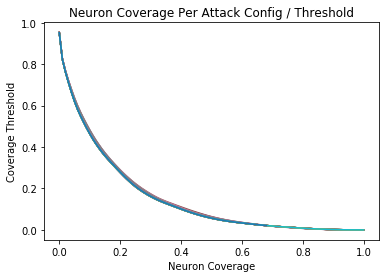

In [12]:
layers = df_adv['layer'].unique()
regularization_weights = df_adv['regularization_weight'].unique()
confidences = df_adv['confidence'].unique()

for l in layers:
    for rw in regularization_weights:
        for c in confidences:
            target_columns = ((df_adv['layer'] == l) 
                              & (df_adv['regularization_weight'] == rw) 
                              & (df_adv['confidence'] == c))
            X_adv = df_adv['threshold'][target_columns].values.reshape(-1, 1)
            y_adv = df_adv['neuron_coverage'][target_columns].values.reshape(-1, 1)
            plt.plot(X_adv, y_adv)
            
plt.title('Neuron Coverage Per Attack Config / Threshold')
plt.xlabel('Neuron Coverage')
plt.ylabel('Coverage Threshold')
plt.show()

# Evaluating Class Averages and Potential Adversarial Bias

NOTE: 

Similarty metrics are argmax'd to get the most similar classes. \
Distance metrics are effectively argmin'd to get the most similar classes. 

In [92]:
from torch.nn.functional import cosine_similarity, pdist
from scipy import spatial
from scipy.stats import wasserstein_distance

In [96]:
data_dir = 'C:\data\CIFAR10'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = len(class_names)
classes = range(num_classes)

dataset = torchvision.datasets.CIFAR10(root=data_dir, 
                                       train=False, 
                                       download=True,
                                       transform=transforms.Compose([
                                           transforms.ToTensor()
                                       ]))

batch_size = len(dataset)

test_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=True)

inputs, targets = next(iter(test_loader))

Files already downloaded and verified


### Get averages for  each class

In [97]:
class_avgs = {}
for i in classes:
    idx = torch.where(targets == i)[0]
    avg_class = np.squeeze(inputs[idx].mean(dim=0))
    class_avgs[i] = avg_class
    # plt.imshow(avg_class)
    # plt.show()

### Cosine Similarity

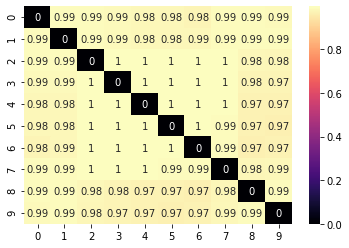

tensor([8, 9, 4, 5, 3, 3, 4, 2, 0, 1])
tensor([0.8888, 0.8900, 0.8931, 0.8911, 0.8898, 0.8884, 0.8885, 0.8924, 0.8834,
        0.8824])
tensor(2)


In [100]:
scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1)
            class_j = class_avgs[j].view(-1)
            scores[i,j] = cosine_similarity(class_i, class_j, dim=0)

sns.heatmap(scores, annot=True, cmap="magma")
plt.show()

print(scores.argmax(dim=0))
print(scores.mean(dim=1))
print(scores.mean(dim=1).argmax())

### Dot Product Similarity

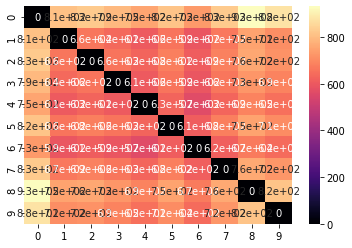

tensor([8, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([737.3531, 610.2699, 624.1873, 603.6008, 576.4905, 619.8812, 564.6127,
        625.9893, 686.1255, 654.6720])
tensor(0)


In [101]:
d_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            d_scores[i,j] = np.dot(class_i, class_j).astype(np.float64)

sns.heatmap(d_scores, annot=True, cmap="magma")
plt.show()

print(d_scores.argmax(dim=0))
print(d_scores.mean(dim=1))
print(d_scores.mean(dim=1).argmax())

### P-Norm Distance

p-norm: 0


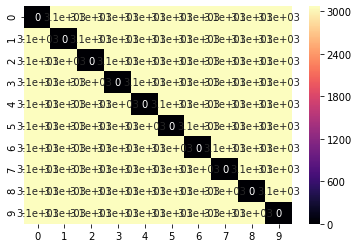

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([2764.8000, 2764.8000, 2764.8000, 2764.8000, 2764.8000, 2764.8000,
        2764.8000, 2764.8000, 2764.8000, 2764.8000])
tensor(9) 

p-norm: 1


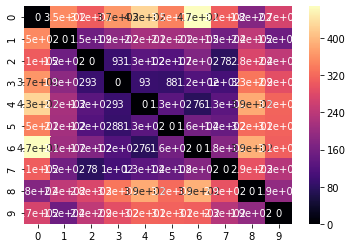

tensor([8, 9, 7, 5, 6, 3, 4, 2, 0, 1])
tensor([302.2643, 188.3949, 157.3931, 167.4520, 190.4084, 183.7906, 208.4549,
        162.7476, 261.5313, 232.2264])
tensor(2) 

p-norm: 2


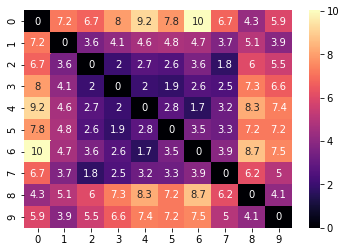

tensor([8, 2, 7, 5, 6, 3, 4, 2, 9, 1])
tensor([6.5832, 4.1550, 3.4535, 3.6953, 4.1917, 4.1096, 4.6263, 3.6240, 5.7187,
        5.3045])
tensor(2) 

p-norm: inf


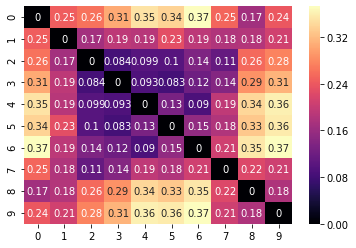

tensor([8, 2, 3, 5, 6, 3, 4, 2, 0, 8])
tensor([0.2537, 0.1792, 0.1496, 0.1623, 0.1850, 0.1903, 0.2000, 0.1701, 0.2323,
        0.2517])
tensor(2) 



In [102]:
p_norms = [0, 1, 2, np.inf]

for p in p_norms:
    
    print('p-norm:', p)
    p_scores = torch.zeros((num_classes, num_classes))
    
    for i in classes:
        for j in classes:
            
            if i !=j:
                class_i = class_avgs[i].view(-1)
                class_j = class_avgs[j].view(-1)
                stacked_classes = torch.stack((class_i, class_j))
                p_scores[i,j] = pdist(stacked_classes, p)

    sns.heatmap(p_scores, annot=True, cmap="magma")
    plt.show()

    print(p_scores.argsort()[:,1:2].view(-1))
    print(p_scores.mean(dim=1))
    print(p_scores.mean(dim=1).argmin(), '\n')

### Wasserstein Distance

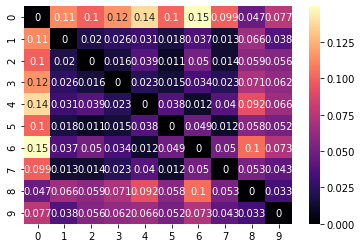

tensor([8, 7, 5, 5, 6, 2, 4, 5, 9, 8])
tensor([0.0940, 0.0362, 0.0366, 0.0387, 0.0480, 0.0353, 0.0557, 0.0347, 0.0583,
        0.0500])
tensor(7)


In [103]:
w_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            w_scores[i,j] = wasserstein_distance(class_i, class_j)

sns.heatmap(w_scores, annot=True, cmap="magma")
plt.show()

print(w_scores.argsort()[:,1:2].view(-1))
print(w_scores.mean(dim=1))
print(w_scores.mean(dim=1).argmin())

### Canberra Distance

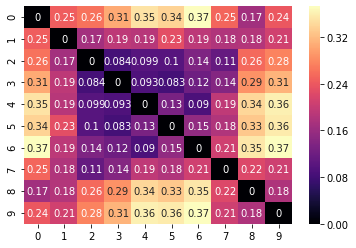

tensor([8, 2, 3, 5, 6, 3, 4, 2, 0, 8])
tensor([0.2537, 0.1792, 0.1496, 0.1623, 0.1850, 0.1903, 0.2000, 0.1701, 0.2323,
        0.2517])
tensor(2)


In [104]:
c_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            c_scores[i,j] = spatial.distance.chebyshev(class_i, class_j).astype(np.float64)

sns.heatmap(c_scores, annot=True, cmap="magma")
plt.show()

print(c_scores.argsort()[:,1:2].view(-1))
print(c_scores.mean(dim=1))
print(c_scores.mean(dim=1).argmin())

### Bray Curtis Distance

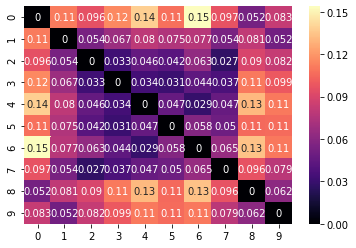

tensor([8, 9, 7, 5, 6, 3, 4, 2, 0, 1])
tensor([0.0956, 0.0651, 0.0533, 0.0572, 0.0664, 0.0623, 0.0736, 0.0552, 0.0864,
        0.0784])
tensor(2)


In [105]:
b_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            b_scores[i,j] = spatial.distance.braycurtis(class_i, class_j)

sns.heatmap(b_scores, annot=True, cmap="magma")
plt.show()

print(b_scores.argsort()[:,1:2].view(-1))
print(b_scores.mean(dim=1))
print(b_scores.mean(dim=1).argmin())